# Import Packages and Define Basic functions

In [1]:
# %pylab notebook
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm     # Relevant Library for colors
from cycler import cycler
from scipy.optimize import curve_fit
# import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
from scipy import stats
import warnings
from mpl_toolkits import mplot3d
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.animation as animation

import matplotlib as mpl
plt.style.use('classic')
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams.update({'figure.autolayout': True})

from IPython.core.display import display, HTML
from matplotlib.backends.backend_pdf import PdfPages
# display(HTML("<style>.container { width:75% !important; }</style>"))

# %matplotlib inline 
# %config InlineBackend.figure_format = 'retina'

from matplotlib import rc
import matplotlib.font_manager
rc('font',**{'family':'sans-serif','sans-serif':['Computer Modern Roman']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

## readSizes
**Input**: 
- seed for run (contained in filename)

**Return**: 
- sizeS_Raw: (type:List) of each avalanche's size, S. 
- params: List of parameters' values

In [2]:
def readSizes(seed, filetype):
    "Read the file of avalanche sizes for given seed. "
    
    with open("Data/sp" + str(seed) + '_' + filetype + '.txt', "r") as f:
        header=[x for x in next(f)]
        params = [float(x) for x in next(f).split()]
        array = [[int(x) for x in line.split() if '\x00' not in x ] for line in f]

    sizeS_raw = [x[0] for x in array if len(x) >= 1]
    params[1] = int(params[1])
    return sizeS_raw, params

## plotSizes

Plots the distribution of Sizes. It is expected that at the critical point, avalanche sizes will scale like:

$$ N(s) \propto s^{-\tau} $$

where $\tau_s \approx 6/5$ for $d=2$. However, theres discrepency in the actual exponent due to multi-scaling for conservative and slow-driving.

In [3]:
def plotSizes(seed, filetype):
    "Plot log-log size histogram (log-binned) "
    sizeS, params = readSizes(seed,filetype)
    sizeS_Log = np.asarray(sizeS)
    hist, bin_edges = np.histogram(sizeS_Log,bins=np.logspace(0,25,50,base=2),density=True)
    for i in range(len(hist)-1,-1,-1):      # Delete any 0 counts. 
        if hist[i]==0:
            hist = np.delete(hist,i)
            bin_edges = np.delete(bin_edges,i)   
    return bin_edges[:-1], hist, params

# Relaxation Times

One quantity of interest which follows from the directed percolation literature is the relaxation time. For a lattice whose initial state is completely active, the time it takes to relax is expected to scale algabracily with distance from the critical point. At the critical point (and in the thermodynamic limit) it should take infinitely long to relax. The scaling is as follows:
\begin{equation}
t_{\text{relax}} \sim \lambda^{-\alpha}
\end{equation}
therefore, we check for both the BTW sandpile and the Manna sandpile to see if we find an $\alpha$ exponent, and even if these exponents match up. 

In [ ]:
def readRelax(seed, filetype):
    "Read the file of avalanche sizes for given seed. "    
    
    with open("Data/sp" + str(seed) + '_' + filetype + '.txt', "r") as f:
        header=[x for x in next(f)]
        params = [float(x) for x in next(f).split()]
        array = [[int(x) for x in line.split() if '\x00' not in x ] for line in f]
    sizeS = [x[0] for x in array if len(x) >= 1]
    params[1] = int(params[1])
    
    return np.mean(sizeS), params

def relaxArray(seedMin,seedMax):
    "Computes the average of each duration file across a range of seed from min to max (Inclusive)"
    timeRelax = []
    for seed in range(seedMin,seedMax):
        dummyRun = readRelax(seed, 'd')
        timeRelax += [[dummyRun[0], dummyRun[1][2]]]  
    return np.asarray(timeRelax)

In [ ]:
# -------------------- Create Figure  -------------------- #                                
fig, (ax1) = plt.subplots(1,1,figsize=(5,4),dpi=120, frameon=True)

data = relaxArray(1100, 1121)
ax1.plot(data[:,1],data[:,0], 'r.-', label="BTW, L=256")

data = relaxArray(1200, 1221)
ax1.plot(data[:,1],data[:,0], 'b.-', label="Manna, L=256")

# data = relaxArray(1230, 1250)
# ax1.plot(data[:,1],data[:,0], 'g.-', label="Manna, L=1024")

x = np.logspace(np.log10(data[0,1]), np.log10(data[-2,1]))
ax1.plot(x,6*x**-0.9, 'k--', label='slope = 0.9')

ax1.set_yscale('log'); ax1.set_xscale('log')
ax1.set_xlabel(r'dissipation - $\lambda$')
ax1.set_ylabel(r'relax. time (sweeps) - $t_r$')
ax1.legend(fontsize=9); 
ax1.grid()
# ax1.set_title("Size distribution: L=" + str(params[1]))
plt.savefig("sp_crit_btwmanna_relaxTime", dpi=240)
plt.show()


## Relaxation time ver. 2

Measuring the number of super-critical sites as a function of time for a system initialized all super-critical (similar to in Nueron model Fig 7). 

We expect the following scaling relation:
\begin{equation}
    \rho \sim t^{-\alpha}
\end{equation}
where $\rho$ is the number (density) of active sites. 

In [ ]:
def readRelax2(seed, filetype):
    "Read the file of tA (active sites over time) for given seed. "
    
    with open("Data/sp" + str(seed) + '_' + filetype + '.txt', "r") as f:
        header=[x for x in next(f)]
        params = [float(x) for x in next(f).split()]
        array = [[float(x) for x in line.split()] for line in f]
    sizeS = [x[0] for x in array]
    params[1] = int(params[1])
    
    return np.asarray(sizeS), params

In [ ]:
# -------------------- Create Figure  -------------------- #
fig1, (ax1) = plt.subplots(1,1,figsize=(6,4), dpi=120, frameon=True)
color = iter( cm.rainbow( np.linspace(0,1,21) ) ) # List of different colors. numPoints --> No. of lines to plot
for i in np.arange(1200, 1221, 1):  #Plot seeds 401-410, the ten lambda runs. 
    c = next( color )
    activeSites, params = readRelax2(i, 'tA')
    disp = params[2]
    time = np.arange(1, len(activeSites)+1)
    ax1.plot(time, activeSites, 
             color=c, label=r'$\lambda$='+str(round(disp, 6)))

# -- Decoration --
ax1.set_ylabel(r'$\rho(t; \lambda)$',fontweight='bold'); 
ax1.set_xlabel('sweeps, $t$',fontweight='bold')
# ax1.set_yscale('log'); 
ax1.set_xscale('log')
ax1.legend(fontsize=7, loc=1, bbox_to_anchor=(1.275, 1.05))
fig1.tight_layout()
ax1.set_title(r"Manna model, $L=256$", fontweight='bold')
plt.savefig('sp_crit_manna_relax.png', dpi=240)


In [ ]:
# -------------------- Create Figure  -------------------- #
fig1, (ax1) = plt.subplots(1,1,figsize=(6,4), dpi=120, frameon=True)
color = iter( cm.rainbow( np.linspace(0,1,21) ) ) # List of different colors. numPoints --> No. of lines to plot
for i in np.arange(1100, 1121, 1):  #Plot seeds 401-410, the ten lambda runs. 
    c = next( color )
    activeSites, params = readRelax2(i, 'tA')
    disp = params[2]
    time = np.arange(1, len(activeSites)+1)
    ax1.plot(time, activeSites, 
             color=c, label=r'$\lambda$='+str(round(disp, 6)))

# -- Decoration --
ax1.set_ylabel(r'$\rho(t; \lambda)$',fontweight='bold'); 
ax1.set_xlabel('sweeps, $t$',fontweight='bold')
# ax1.set_yscale('log'); 
ax1.set_xscale('log')
ax1.legend(fontsize=7, loc=1, bbox_to_anchor=(1.275, 1.05))
fig1.tight_layout()
ax1.set_title(r"BTW model, $L=256$", fontweight='bold')
plt.savefig('sp_crit_btw_relax.png', dpi=240)


# BTW Sandpile model ('final')

These runs have seed 

    900-920
    
They are more 'final' runs to compuate the critical properties of the BTW sandpile model. 

## Scaling plots as $\lambda \to 0$

Fitting the the function

\begin{equation}
    N_s(s,L) \sim s^{-\tau} e^{-s/L^{D_f}} e^{-\lambda s^\sigma}
\end{equation}

we use previous results from FSS to set $D_f \approx 2.1$. We then take the $log_{10}$ of the expression above and fit to that:

\begin{align}
    \log_{10}[N_s(s,L)] = A - \tau \log_{10}[s] - \frac{ sL^{-D_f} }{\log[10]} - \frac{\lambda s^\sigma}{\log[10]} \\
\end{align}

in the code, we fit according to $x = \log_{10}(s)$, which in the above formula corresponds to
\begin{align}
    \log_{10}[N_s(s,L)] = A - \tau x - \frac{ 10^x L^{-D_f} }{\log[10]} - \frac{\lambda 10^{x\sigma}}{\log[10]} \\
\end{align}

### Fitting for the $\tau$ exponent first:

In [ ]:
def plotD_plotSizes(seed, c):
    
    ## Sizes w/ double counting
    x,y,params = plotSizes(seed, filetype='s');  x = np.log10(x); y = np.log10(y)

    za, cova = np.polyfit(x[6:16], y[6:16], 1, cov=True)
    pa = np.poly1d(za)
    perra = np.sqrt(np.diag(cova))
    xpa = np.linspace(x[6], x[16],40)
    ax1.plot(xpa, pa(xpa),linestyle='--', color='grey', 
             label=r'$\tau_s = $'+str(round(-za[0],3))+'$\pm$'+str(round(perra[0], 4)))
    ax1.fill_between(xpa, -10, 0, 
                    facecolor='red', alpha=0.3)
    
    # ---------------------------------------------------- #
    ax1.plot(x, y, '.', color=c, label = r"$\lambda=$"+str(round(params[2],6)))
    taus = round(-za[0],3)
    errors = round(perra[0], 4)
    
    
    ## Sizes w/o double counting
    x,y,params = plotSizes(seed, filetype='a');  x = np.log10(x); y = np.log10(y)

    za, cova = np.polyfit(x[6:16], y[6:16], 1, cov=True)
    pa = np.poly1d(za)
    perra = np.sqrt(np.diag(cova))
    xpa = np.linspace(x[6], x[16],40)
    ax3.plot(xpa, pa(xpa),linestyle='--', color='grey', 
             label=r'$\tau_a = $'+str(round(-za[0],3))+'$\pm$'+str(round(perra[0], 4)))
    ax3.fill_between(xpa, -10, 0, 
                    facecolor='red', alpha=0.3)
    # ---------------------------------------------------- #
    ax3.plot(x, y, '.', color=c, label = r"$\lambda=$"+str(round(params[2],6)))
    taua = round(-za[0],3)
    errora = round(perra[0], 4)
    
    ## Durations
    x,y,params = plotSizes(seed, filetype='d');  x = np.log10(x); y = np.log10(y)
    
    za, cova = np.polyfit(x[6:16], y[6:16], 1, cov=True)
    pa = np.poly1d(za)
    perra = np.sqrt(np.diag(cova))
    xpa = np.linspace(x[6], x[16],40)
    ax2.plot(xpa, pa(xpa),linestyle='--', color='grey', 
             label=r'$\tau_D = $'+str(round(-za[0],3))+'$\pm$'+str(round(perra[0], 4)))
    ax2.fill_between(xpa, -10, 0, 
                    facecolor='red', alpha=0.3)
    # ---------------------------------------------------- #
    ax2.plot(x, y, '.', color=c,label = r"$\lambda=$"+str(round(params[2],6)))
    taud = round(-za[0],3)
    errord = round(perra[0], 4)
    
    print(params)

    return params[2], [taus, taua, taud], [errors, errora, errord]



# -------------------- Create Figure  -------------------- #

exponents = []; error = []; lambdas = []
fig1, (ax1) = plt.subplots(1,1,figsize=(5,4), dpi=120, frameon=True)
fig3, (ax3) = plt.subplots(1,1,figsize=(5,4), dpi=120, frameon=True)
fig2, (ax2) = plt.subplots(1,1,figsize=(5,4), dpi=120, frameon=True)

lamb, new_exp, new_err = plotD_plotSizes(920, 'r')
exponents += [new_exp]; error += [new_err]; lambdas += [lamb]

# -- Decoration --
ax1.set_ylabel(r'$N_s(s,L)$',fontweight='bold'); ax1.set_xlabel('size, $s$',fontweight='bold')
ax2.set_ylabel(r'$N_d(d,L)$',fontweight='bold'); ax2.set_xlabel('duration, $d$',fontweight='bold')
ax3.set_ylabel(r'$N_a(a,L)$',fontweight='bold'); ax3.set_xlabel('size, $a$',fontweight='bold')
ax1.legend(loc=1, fontsize=7)
ax2.legend(loc=1, fontsize=7)
ax3.legend(loc=1, fontsize=7)
# ax2.set_ylim(top=7)
fig1.tight_layout(); fig2.tight_layout(); fig3.tight_layout()

### Scaling Plots w/o data collapse

and fitting to the exponents using a nonlinear curve-fit. 

In [ ]:
def func(s, tau, sigma, A, lambd):
    return A - tau * s - lambd * (10**s)**sigma  / np.log(10) # - 10**s * 256**(-2.2) / np.log(10)

def func_sizeC(s, tau, s_c, A):
    return A - tau * s -  10**(s) / s_c / np.log(10)

def plotD_plotSizes(seed, c):
    
    ## Sizes w/ double counting
    x,y,params = plotSizes(seed, filetype='s');  x = np.log10(x); y = np.log10(y)
    # ------ Fitting to compute avalanche exponents ------ #
    tau = 1.08; er = 0.123
    initGuess = np.asarray([tau, 1, 0])
    paramBounds =         ((tau-er, -1e10, -100),
                           (tau+er, 1e10,   100))
    popt, pcov = curve_fit(func_sizeC, x[2:], y[2:], p0=initGuess, bounds=paramBounds)
    perr = np.sqrt(np.diag(pcov))
    # ---------------------------------------------------- #
    ax1.plot(x, y, '.', color=c, label = r"$\lambda=$"+str(round(params[2],6)))
#     ax1.plot(x, func_sizeC(x, *popt), color=c)
    ax1.plot(np.linspace(0,6), -1.203 * np.linspace(0,6), 'k--')
    
    
    ## Sizes w/o double counting
    x,y,params = plotSizes(seed, filetype='a');  x = np.log10(x); y = np.log10(y)
    # ------ Fitting to compute avalanche exponents ------ #
    tau = 1.075; er = 0.121
    initGuess = np.asarray([tau, 1, 0])
    paramBounds =         ((tau-er, -1e10, -100),
                           (tau+er, 1e10,   100))
    popt3, pcov3 = curve_fit(func_sizeC, x[2:], y[2:], p0=initGuess, bounds=paramBounds)
    perr3 = np.sqrt(np.diag(pcov3))
    # ---------------------------------------------------- #
    ax3.plot(x, y, '.', color=c, label = r"$\lambda=$"+str(round(params[2],6)))
#     ax3.plot(x, func_sizeC(x, *popt3), color=c)
    ax3.plot(np.linspace(0,4.5), -1.162 * np.linspace(0,4.5), 'k--')
    
    
    ## Durations
    x,y,params = plotSizes(seed, filetype='d');  x = np.log10(x); y = np.log10(y)
    # ------ Fitting to compute avalanche exponents ------ #
    tau = 1.142; er = 0.127
    initGuess = np.asarray([tau, 1,    1])
    paramBounds =         ((tau-er, -1e8, -100), 
                           (tau+er, 1e8,  100))
    popt2, pcov2 = curve_fit(func_sizeC, x, y, p0=initGuess, bounds=paramBounds)
    perr2 = np.sqrt(np.diag(pcov2))
    # ---------------------------------------------------- #
    ax2.plot(x, y, '.', color=c,label = r"$\lambda=$"+str(round(params[2],6)))
#     ax2.plot(x, func_sizeC(x, *popt2), color=c)
    ax2.plot(np.linspace(0,4), -1.281 * np.linspace(0,4), 'k--')
    
    
    return params[2], [popt[0], popt[1],popt2[0], popt2[1],popt3[0], popt3[1]], [perr[0], perr[1], perr2[0], perr2[1], perr3[0], perr3[1]]


In [ ]:
# -------------------- Create Figure  -------------------- #
seedrange = np.arange(908,920, 4)
seedrange = [903, 907, 911, 915]

exponents = []; error = []; lambdas = []
fig1, (ax1) = plt.subplots(1,1,figsize=(4, 3.5), dpi=120, frameon=True)
fig3, (ax3) = plt.subplots(1,1,figsize=(4, 3.5), dpi=120, frameon=True)
fig2, (ax2) = plt.subplots(1,1,figsize=(4, 3.5), dpi=120, frameon=True)
color = iter( cm.rainbow( np.linspace(0,1,len(seedrange)) ) ) # List of different colors. numPoints --> No. of lines to plot
for i in seedrange:  #Plot seeds 401-410, the ten lambda runs. 
    c = next( color )
    lamb, new_exp, new_err = plotD_plotSizes(i, c)
    exponents += [new_exp]; error += [new_err]; lambdas += [lamb]

# -- Decoration --
ax1.set_ylabel(r'$\log N_s(s,L)$',fontweight='bold'); ax1.set_xlabel('size, $\log s$',fontweight='bold')
ax2.set_ylabel(r'$\log N_d(d,L)$',fontweight='bold'); ax2.set_xlabel('duration, $\log d$',fontweight='bold')
ax3.set_ylabel(r'$\log N_a(a,L)$',fontweight='bold'); ax3.set_xlabel('size, $\log a$',fontweight='bold')
ax1.legend(loc=1, fontsize=9)
ax2.legend(loc=1, fontsize=9)
ax3.legend(loc=1, fontsize=9)

    

# ax2.set_ylim(top=7)
# fig1.tight_layout(); fig2.tight_layout(); fig3.tight_layout()

fig1.savefig('Plots/sp_crit_btw_s.png', dpi=240)
fig2.savefig('Plots/sp_crit_btw_D.png', dpi=240)
fig3.savefig('Plots/sp_crit_btw_a.png', dpi=240)


### Characteristic size and $\sigma$ exponent

Below we compute the critical exponents using the prescription of fitting to characteristic avalanche size/duration and extracting the $\sigma$ exponent from this. 

In [ ]:
# ---------- Plot of Exponents while lambda -> 0 --------- #
# ---------- Fitting to compute \sigma's  ---------------- #

slopeS, interceptS, r_valueS, p_valueS, std_errS = stats.linregress(np.log(np.asarray(lambdas))[1:-10],np.log(np.asarray(exponents))[1:-10,1])
slopeA, interceptA, r_valueA, p_valueA, std_errS = stats.linregress(np.log(np.asarray(lambdas))[1:-10],np.log(np.asarray(exponents))[1:-10,5])
slopeD, interceptD, r_valueD, p_valueD, std_errD = stats.linregress(np.log(np.asarray(lambdas))[1:-10],np.log(np.asarray(exponents))[1:-10,3])

xs = np.logspace(-4,-1,100)
lineS = slopeS * np.log10(xs) + interceptS
lineA = slopeA * np.log10(xs) + interceptA
lineD = slopeD * np.log10(xs) + interceptD


# -------------------- Create Figure  -------------------- #
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,3.5), dpi=120, frameon=True)
ax1.plot(np.asarray(lambdas),np.asarray(exponents)[:,0], 'r-o', label=r'$\tau_s$')
ax1.plot(np.asarray(lambdas),np.asarray(exponents)[:,2], 'b-o', label=r'$\tau_D$')
ax1.plot(np.asarray(lambdas),np.asarray(exponents)[:,4], 'g-o', label=r'$\tau_a$')

ax2.plot(np.asarray(lambdas),np.asarray(exponents)[:,1],
             'r-o', label=r'$s_c$ w/ $\sigma_s \approx$' + str(round(-1/slopeS, 4)))
ax2.plot(np.asarray(lambdas),np.asarray(exponents)[:,3],
             'b-o', label=r'$D_c$ w/ $\sigma_D \approx $' + str(round(-1/slopeD, 4)))
ax2.plot(np.asarray(lambdas),np.asarray(exponents)[:,5],
             'g-o', label=r'$a_c$ w/ $\sigma_a \approx $' + str(round(-1/slopeA, 4)))

# print(-1/slopeS, -1/slopeD)
ax2.plot(xs, 10**lineS, '--', color='red')
ax2.plot(xs, 10**lineD, '--', color='blue')
ax2.plot(xs, 10**lineA, '--', color='green')

# -- Decoration --
ax1.legend(loc=3, fontsize=9); 
ax2.legend(loc=3, fontsize=9); 
ax1.set_xscale('log'); ax1.set_xlabel('$\lambda$')
ax2.set_xscale('log'); ax2.set_yscale('log'); ax2.set_xlabel('$\lambda$')
fig.suptitle(r"Exponents for $N_x(x,L) \sim x^{-\tau}e^{-x/x_c(\lambda)}$ w/ $x_c  \sim \epsilon^{-1/\sigma_x}$", fontweight='bold', y=1.02)
# fig.savefig('sp_crit_btw_exps', dpi=240)
plt.show()

In [ ]:
# print(exponents, error)
lambdas = [0.100000001, 0.0545559004, 0.0297634993, 0.0162377991, 0.00885870028, 0.00483290013, 0.00263669994, 0.00143840001, 0.00078479998, 0.0004281, 0.000233600003, 0.000127399995, 6.94999981e-05, 3.79000012e-05, 2.06999994e-05, 1.12999996e-05, 6.19999992e-06, 3.39999997e-06, 1.79999995e-06, 9.99999997e-07]
exponents = [[0.9570000000000002, 12.61080407664912, 1.0150000000000003, 4.052789177515682, 0.9540000000000001, 11.88900503674474], [0.9570000000000002, 24.12775372167678, 1.0150000000000001, 6.252609476260731, 0.9540000000000001, 23.614012534871904], [0.9570000000000003, 45.22692090747746, 1.0150000000000001, 9.359471231287806, 0.9540000000000001, 42.866484920477085], [0.9570000000000002, 87.70790363387802, 1.0150000000000001, 13.929148529360734, 0.9540000000000001, 79.43162616087798], [0.9570000000000002, 171.70474901496962, 1.0150000000000001, 21.682320359746864, 0.9540000000000001, 142.25621858633343], [0.9570000000000002, 357.4350630155103, 1.0150000000000001, 31.41372396414024, 0.9540000000000001, 279.8839529148057], [0.9570000000000002, 713.0323457108133, 1.0150000000000001, 45.34343447947397, 0.9540000000000001, 468.82938109903995], [0.9570000000000002, 1342.3272751537415, 1.0150000000000001, 67.856726462309, 0.9540000000000007, 771.8934587753394], [0.9738102296977198, 2475.840658292559, 1.0150000000000001, 94.42161117004751, 0.9540000000000001, 1144.8145186004344], [1.0147789437086403, 4457.965178129168, 1.015000000000001, 124.19584783452505, 0.9540000000000001, 1881.0434256235133], [1.0259280351009419, 6607.638070795759, 1.0150000000000001, 184.8085496025376, 0.9540000000000001, 2771.633860538995], [1.021895165663645, 8374.774521514779, 1.0150000000000035, 213.679071198371, 0.9540000000000001, 1808.3372245748938], [1.0474568105160733, 11028.826741056926, 1.0150000000000012, 235.97686688858934, 0.9540000000000001, 2377.2361658991517], [1.0322805920970823, 11592.260824031553, 1.0150000000000001, 253.3901829454813, 0.9540000000000001, 2541.645742110839], [1.043492608941865, 12717.538048145952, 1.0150000000000001, 287.6164282570088, 0.9540000000000001, 2682.4407976994244], [1.051420506472148, 13682.93241871642, 1.0150000000000001, 288.15838567645164, 0.9540000000000001, 2818.8008747946087], [1.0757017163564322, 15261.77433885351, 1.0150000000000001, 290.1677447710125, 0.9540000000000001, 2873.946919736512], [1.053476024162264, 14167.554223884568, 1.0150000000000001, 294.7925898691035, 0.9540000000000001, 2858.6191388633965], [1.0430437861818964, 13573.152142359348, 1.0150000000000001, 293.6937718647803, 0.9540000000000001, 2803.2829916697706], [1.0515584183520885, 14215.427449593779, 1.0150000000000001, 293.748445226956, 0.9540000000000001, 2939.4432973667854]]


# ---------- Plot of Exponents while lambda -> 0 --------- #
# ---------- Fitting to compute \sigma's  ---------------- #

slopeS, interceptS, r_valueS, p_valueS, std_errS = stats.linregress(np.log(np.asarray(lambdas))[1:-10],np.log(np.asarray(exponents))[1:-10,1])
slopeA, interceptA, r_valueA, p_valueA, std_errS = stats.linregress(np.log(np.asarray(lambdas))[1:-10],np.log(np.asarray(exponents))[1:-10,5])
slopeD, interceptD, r_valueD, p_valueD, std_errD = stats.linregress(np.log(np.asarray(lambdas))[1:-10],np.log(np.asarray(exponents))[1:-10,3])

xs = np.logspace(-4,-1,100)
lineS = slopeS * np.log10(xs) + interceptS
lineA = slopeA * np.log10(xs) + interceptA
lineD = slopeD * np.log10(xs) + interceptD


# -------------------- Create Figure  -------------------- #
fig1, (ax1) = plt.subplots(1,1,figsize=(4, 4), dpi=120, frameon=True)
fig2, (ax2) = plt.subplots(1,1,figsize=(4, 4), dpi=120, frameon=True)
fig3, (ax3) = plt.subplots(1,1,figsize=(4, 4), dpi=120, frameon=True)

ax1.plot(np.asarray(lambdas),np.asarray(exponents)[:,1], 'ro-', 
         label=r'$\sigma_s \approx $' + str(round(-1/slopeS, 4)) + '$\pm$' + str(round(std_errS, 4)))
ax2.plot(np.asarray(lambdas),np.asarray(exponents)[:,3],'go-', 
         label=r'$\sigma_D \approx $' + str(round(-1/slopeD, 4)) + '$\pm$' + str(round(std_errD, 4)))
ax3.plot(np.asarray(lambdas),np.asarray(exponents)[:,5],'bo-', 
         label=r'$\sigma_a \approx $' + str(round(-1/slopeA, 4)) + '$\pm$' + str(round(std_errA, 4)))

# print(-1/slopeS, -1/slopeD)
ax1.plot(xs, 10**lineS, '--', color='red')
ax2.plot(xs, 10**lineD, '--', color='green')
ax3.plot(xs, 10**lineA, '--', color='blue')

# -- Decoration --
ax1.legend(loc=2, fontsize=9); 
ax2.legend(loc=2, fontsize=9); 
ax3.legend(loc=2, fontsize=9); 
ax1.set_xscale('log'); ax1.set_yscale('log'); ax1.set_xlabel('dissipation, $\lambda$'); ax1.set_ylabel('$s_c$')
ax2.set_xscale('log'); ax2.set_yscale('log'); ax2.set_xlabel('dissipation, $\lambda$'); ax2.set_ylabel('$D_c$')
ax3.set_xscale('log'); ax3.set_yscale('log'); ax3.set_xlabel('dissipation, $\lambda$'); ax3.set_ylabel('$a_c$')
# fig.suptitle(r"Critical exponents consistency check for $N(s,L) \sim s^{-\tau}e^{-s/s_c(\lambda)}$", fontweight='bold', y=1.02)
# plt.show()

fig1.savefig('Plots/sp_crit_btw_s_sigma.png', dpi=240)
fig2.savefig('Plots/sp_crit_btw_D_sigma.png', dpi=240)
fig3.savefig('Plots/sp_crit_btw_a_sigma.png', dpi=240)

### Re-scaled scaling plots (data collapse)


Plotting the following axis:
\begin{equation}
    N(x) x^{\tau_x} = h(x / \lambda^{1/\sigma_x})
\end{equation}
where we expect to see data collapse since $h(.)$ should be a universal function independent of $\lambda$ other than the single argument. 

We also expect that $h(x) = \exp[x]$, at least from previous results (e.g. the neuron paper). 


In [ ]:

# 1.211847389558233 2.7751004016064256
# 1.1716867469879517 2.0281124497991967
# 1.2720883534136547 1.5783132530120483

def plotD_plotSizes_rescaled(seed, c):
    
    ## Sizes w/ double counting
    x,y,params = plotSizes(seed, filetype='s');  
#     x = np.log10(x);     y = np.log10(y)
    lambd = params[2];
    tau = 1.203; sigma = 1.09143
    ax1.plot(x * lambd**(1/sigma), y * lambd**(-tau/sigma) , '.-', color=c, label = r"$\lambda=$"+str(round(lambd,6)))
    
    
    ## Sizes w/o double counting
    x,y,params = plotSizes(seed, filetype='a');  
#     x = np.log10(x); y = np.log10(y)
    lambd = params[2];
    tau = 1.179; sigma = 1.0982
    ax2.plot(x * lambd**(1/sigma), y * lambd**(-tau/sigma) , '.-', color=c, label = r"$\lambda=$"+str(round(lambd,6)))
    
    
    ## Durations
    x,y,params = plotSizes(seed, filetype='d');  
#     x = np.log10(x); y = np.log10(y)
    lambd = params[2];
    tau = 1.281; sigma = 1.595
    ax3.plot(x * lambd**(1/sigma), y * lambd**(-tau/sigma) , '.-', color=c, label = r"$\lambda=$"+str(round(lambd,6)))

    

In [ ]:
# -------------------- Create Figure  -------------------- #

seedrange = np.arange(900,912,1)

exponents = []; error = []; lambdas = []
# fig1, (ax1) = plt.subplots(1,1,figsize=(5,4), dpi=120, frameon=True)
# fig3, (ax3) = plt.subplots(1,1,figsize=(5,4), dpi=120, frameon=True)
# fig2, (ax2) = plt.subplots(1,1,figsize=(5,4), dpi=120, frameon=True)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5), dpi=240, frameon=True)
color = iter( cm.rainbow( np.linspace(0,1,len(seedrange)) ) ) # List of different colors. numPoints --> No. of lines to plot
for i in seedrange: 
    c = next( color )
    plotD_plotSizes_rescaled(i, c)

    
# -- Decoration --

ax1.set_ylabel(r'$N_s(s,L)$',fontweight='bold'); ax1.set_xlabel('size, $s$',fontweight='bold')
ax2.set_ylabel(r'$N_d(d,L)$',fontweight='bold'); ax2.set_xlabel('duration, $d$',fontweight='bold')
ax3.set_ylabel(r'$N_a(a,L)$',fontweight='bold'); ax3.set_xlabel('size, $a$',fontweight='bold')
ax1.set_xscale('log'); 
ax1.set_yscale('log')
ax2.set_xscale('log'); 
ax2.set_yscale('log')
ax3.set_xscale('log'); 
ax3.set_yscale('log')
ax1.legend(loc=1, fontsize=6)
ax2.legend(loc=1, fontsize=6)
ax3.legend(loc=1, fontsize=6)
# fig1.tight_layout(); fig2.tight_layout(); fig3.tight_layout()
# ax1.set_title('BTW, L='+params[1])
# ax2.set_title('BTW, L='+params[1])
# ax3.set_title('BTW, L='+params[1])

# fig1.savefig('sp_crit_btw_s.png', dpi=240)
# fig2.savefig('sp_crit_btw_D.png', dpi=240)
# fig3.savefig('sp_crit_btw_a.png', dpi=240)

### Searching for exponents which produce data collapse 

Perform the same methods used in the FSS data collapse to find good data collapse with this criticality form. 


In [ ]:
# -------------------- Fitting to FSS  -------------------- #
def plotFSS_1(seed, c, tau, d, filetype):
    """ seed - seed of run to plot
        c - color of the line being plotted
        tau, d - exponents for rescaling
        filetype - which quantity to plot / file to draw from
    """    
    x,y,params = plotSizes(seed, filetype);  #x = np.log10(x); y = np.log10(y)
    lambd = float(params[2])
    ax1.plot(x * lambd**(1/sigma), y * lambd**(-tau/sigma), 
             '.-', color=c, label = "L="+str(params[1]))
             
             
def diff_1(tau, d,  x1,y1,params1,  x2,y2,params2,  filetype, plotYes):
    """ Computes the difference w/ rescaled axis of two given runs with a given exponent set. Seed1/2 are the seeds of our desired runs."""
    
    x1_r = np.log10(x1 * float(params1[2])**(1/d)) 
    y1_r = np.log10(y1 * float(params1[2])**(-tau/d))

    x2_r = np.log10(x2 * float(params2[2])**(1/d)) 
    y2_r = np.log10(y2 * float(params2[2])**(-tau/d))
    
    if plotYes==True:
        plotPolyFit(x1_r, y1_r, x2_r, y2_r)

    Xstart = max(x1_r[0], x2_r[0])
    Xend = min(x1_r[-1], x2_r[-1])
#     with warnings.catch_warnings():
#         warnings.simplefilter('ignore', np.RankWarning)
    z1 = np.polyfit(x1_r, y1_r, 10)
    z2 = np.polyfit(x2_r, y2_r, 10)
    p1 = np.poly1d(z1)
    p2 = np.poly1d(z2)
    xp = np.linspace(Xstart,Xend, 100)

    return np.sqrt( np.sum( (p2(xp) - p1(xp))**2 ) )


def plotPolyFit(x1_r, y1_r, x2_r, y2_r):

    Xstart = max(x1_r[0], x2_r[0])
    Xend = min(x1_r[-1], x2_r[-1])

    z1 = np.polyfit(x1_r, y1_r, 10)
    z2 = np.polyfit(x2_r, y2_r, 10)
    p1 = np.poly1d(z1)
    p2 = np.poly1d(z2)
    xp = np.linspace(Xstart,Xend, 100)

    fig1, ax1 = plt.subplots(1,1,figsize=(4, 3.5), dpi=120,frameon=False)
    ax1.plot(x1_r, y1_r, 'r-')
    ax1.plot(xp, p1(xp), 'r--')
    ax1.plot(x2_r, y2_r, 'b-')
    ax1.plot(xp, p2(xp), 'b--')
    fig.show()

    
def diffoverRange(tauRange, dRange, seed1, seed2, filetype, plotYes):
    x1,y1,params1 = plotSizes(seed1, filetype)
    x2,y2,params2 = plotSizes(seed2, filetype)
    
    Z = np.zeros((len(tauRange), len(dRange)))
    for xxx in range(len(tauRange)):
        for yyy in range(len(dRange)):
            Z[xxx, yyy] = diff_1(tauRange[xxx], dRange[yyy],  x1,y1,params1,  x2,y2,params2,  filetype, plotYes)
    return Z

def find_min_idx(x):
    k = x.argmin()
    ncol = x.shape[1]
    return k//ncol, k%ncol

In [ ]:
tauRange = np.linspace(0.75, 2, 150)
sigmaRange = np.linspace(0.75, 2, 150)

Zs = diffoverRange(tauRange, sigmaRange, 907, 910, 's', plotYes=False)
Za = diffoverRange(tauRange, sigmaRange, 907, 910, 'a', plotYes=False)
Zd = diffoverRange(tauRange, sigmaRange, 907, 910, 'd', plotYes=False)
# print(Z)

In [ ]:
x1,y1,params1 = plotSizes(903, 'a')
x2,y2,params2 = plotSizes(907, 'a')

tau = 1.179; sigma = 1.0982

diff_1(tau, sigma,  x1,y1,params1,  x2,y2,params2,  'a', True)

In [ ]:

Z = Zs #==============================================
tauBest=tauRange[find_min_idx(Z)[0]]
sigmaBest=sigmaRange[find_min_idx(Z)[1]]
print(tauBest, sigmaBest)

fig = plt.figure(figsize=(6,4), dpi=120, frameon=True)
ax = plt.axes()
heatmap = ax.contourf(sigmaRange, tauRange, Z, 50, cmap='viridis')
ax.plot(sigmaBest, tauBest, color='red', marker='o')

ax.set_ylabel(r'$\tau_s$')
ax.set_xlabel(r'$\sigma_s$')
fig.colorbar(heatmap)
ax.set_title('Manna; size $s$', fontweight='bold')
fig.tight_layout()

Z = Za #==============================================
tauBest=tauRange[find_min_idx(Z)[0]]
sigmaBest=sigmaRange[find_min_idx(Z)[1]]
print(tauBest, sigmaBest)

fig = plt.figure(figsize=(6,4), dpi=120, frameon=True)
ax = plt.axes()
heatmap = ax.contourf(sigmaRange, tauRange, Z, 50, cmap='viridis')
ax.plot(sigmaBest, tauBest, color='red', marker='o')

ax.set_ylabel(r'$\tau_s$')
ax.set_xlabel(r'$\sigma_s$')
fig.colorbar(heatmap)
ax.set_title('Manna; size $a$', fontweight='bold')
fig.tight_layout()


Z = Zd #==============================================
tauBest=tauRange[find_min_idx(Z)[0]]
sigmaBest=sigmaRange[find_min_idx(Z)[1]]
print(tauBest, sigmaBest)

fig = plt.figure(figsize=(6,4), dpi=120, frameon=True)
ax = plt.axes()
heatmap = ax.contourf(sigmaRange, tauRange, Z, 50, cmap='viridis')
ax.plot(sigmaBest, tauBest, color='red', marker='o')

ax.set_ylabel(r'$\tau_s$')
ax.set_xlabel(r'$\sigma_s$')
fig.colorbar(heatmap)
ax.set_title('Manna; duration $D$', fontweight='bold')
fig.tight_layout()



### Inset Scaling Plots

In [ ]:
def func(s, tau, sigma, A, lambd):
    return A - tau * s - lambd * (10**s)**sigma  / np.log(10) # - 10**s * 256**(-2.2) / np.log(10)

def func_sizeC(s, tau, s_c, A):
    return A - tau * s -  10**(s) / s_c / np.log(10)

def plotD_plotSizes1(seed, c,lab):
    
    seedRange = [903, 907, 911, 915] # the ones that will be plotted
    
    ## Sizes w/ double counting
    x,y,params = plotSizes(seed, filetype='s');  x = np.log10(x); y = np.log10(y)
    # ------ Fitting to compute avalanche exponents ------ #
    tau = 1.08; er = 0.123
    initGuess = np.asarray([tau, 1, 0])
    paramBounds =         ((tau-er, -1e10, -100),
                           (tau+er, 1e10,   100))
    popt, pcov = curve_fit(func_sizeC, x[2:], y[2:], p0=initGuess, bounds=paramBounds)
    perr = np.sqrt(np.diag(pcov))
    # ---------------------------------------------------- #
    if seed in seedRange:
        ax1.plot(x, y, '.', color=c, label = lab)
#     ax1.plot(x, func_sizeC(x, *popt), color=c)
    
    
    ## Sizes w/o double counting
    x,y,params = plotSizes(seed, filetype='a');  x = np.log10(x); y = np.log10(y)
    # ------ Fitting to compute avalanche exponents ------ #
    tau = 1.075; er = 0.121
    initGuess = np.asarray([tau, 1, 0])
    paramBounds =         ((tau-er, -1e10, -100),
                           (tau+er, 1e10,   100))
    popt3, pcov3 = curve_fit(func_sizeC, x[2:], y[2:], p0=initGuess, bounds=paramBounds)
    perr3 = np.sqrt(np.diag(pcov3))
    # ---------------------------------------------------- #
    
    if seed in seedRange:
        ax3.plot(x, y, '.', color=c, label = lab)
#     ax3.plot(x, func_sizeC(x, *popt3), color=c)
    
    
    ## Durations
    x,y,params = plotSizes(seed, filetype='d');  x = np.log10(x); y = np.log10(y)
    # ------ Fitting to compute avalanche exponents ------ #
    tau = 1.142; er = 0.127
    initGuess = np.asarray([tau, 1,    1])
    paramBounds =         ((tau-er, -1e8, -100), 
                           (tau+er, 1e8,  100))
    popt2, pcov2 = curve_fit(func_sizeC, x, y, p0=initGuess, bounds=paramBounds)
    perr2 = np.sqrt(np.diag(pcov2))
    # ---------------------------------------------------- #
    if seed in seedRange:
        ax2.plot(x, y, '.', color=c, label = lab)
#     ax2.plot(x, func_sizeC(x, *popt2), color=c)

    return params[2], [popt[0], popt[1],popt2[0], popt2[1],popt3[0], popt3[1]], [perr[0], perr[1], perr2[0], perr2[1], perr3[0], perr3[1]]



# -------------------- Create Figure  -------------------- #
# seedrange = np.arange(900,920, 1)
seedrange = [903, 907, 911, 915]
labrange = [0.01, 0.001, 0.0001, 0.00001]

exponents = []; error = []; lambdas = []
fig1, (ax1) = plt.subplots(1,1,figsize=(4, 3.5), dpi=120, frameon=True)
fig3, (ax3) = plt.subplots(1,1,figsize=(4, 3.5), dpi=120, frameon=True)
fig2, (ax2) = plt.subplots(1,1,figsize=(4, 3.5), dpi=120, frameon=True)
color = iter( cm.rainbow( np.linspace(0,1,len(seedrange)) ) ) # List of different colors. numPoints --> No. of lines to plot
for i in range(len(seedrange)):  #Plot seeds 401-410, the ten lambda runs. 
    c = next( color )
    lab = r"$\lambda= %10.1e$"%labrange[i]
    lamb, new_exp, new_err = plotD_plotSizes1(seedrange[i], c, lab)
    exponents += [new_exp]; error += [new_err]; lambdas += [lamb]

# -- Decoration --
ax1.set_ylabel(r'$\log N_s(s,L)$',fontweight='bold'); ax1.set_xlabel('size, $\log s$',fontweight='bold')
ax2.set_ylabel(r'$\log N_d(d,L)$',fontweight='bold'); ax2.set_xlabel('duration, $\log d$',fontweight='bold')
ax3.set_ylabel(r'$\log N_a(a,L)$',fontweight='bold'); ax3.set_xlabel('size, $\log a$',fontweight='bold')
ax1.legend(loc=1, fontsize=9)
ax2.legend(loc=1, fontsize=9)
ax3.legend(loc=1, fontsize=9)



# print(exponents, error)

# ---------- Plot of Exponents while lambda -> 0 --------- #
# ---------- Fitting to compute \sigma's  ---------------- #

lambdas = [0.100000001, 0.0545559004, 0.0297634993, 0.0162377991, 0.00885870028, 0.00483290013, 0.00263669994, 0.00143840001, 0.00078479998, 0.0004281, 0.000233600003, 0.000127399995, 6.94999981e-05, 3.79000012e-05, 2.06999994e-05, 1.12999996e-05, 6.19999992e-06, 3.39999997e-06, 1.79999995e-06, 9.99999997e-07]
exponents = [[0.9570000000000002, 12.61080407664912, 1.0150000000000003, 4.052789177515682, 0.9540000000000001, 11.88900503674474], [0.9570000000000002, 24.12775372167678, 1.0150000000000001, 6.252609476260731, 0.9540000000000001, 23.614012534871904], [0.9570000000000003, 45.22692090747746, 1.0150000000000001, 9.359471231287806, 0.9540000000000001, 42.866484920477085], [0.9570000000000002, 87.70790363387802, 1.0150000000000001, 13.929148529360734, 0.9540000000000001, 79.43162616087798], [0.9570000000000002, 171.70474901496962, 1.0150000000000001, 21.682320359746864, 0.9540000000000001, 142.25621858633343], [0.9570000000000002, 357.4350630155103, 1.0150000000000001, 31.41372396414024, 0.9540000000000001, 279.8839529148057], [0.9570000000000002, 713.0323457108133, 1.0150000000000001, 45.34343447947397, 0.9540000000000001, 468.82938109903995], [0.9570000000000002, 1342.3272751537415, 1.0150000000000001, 67.856726462309, 0.9540000000000007, 771.8934587753394], [0.9738102296977198, 2475.840658292559, 1.0150000000000001, 94.42161117004751, 0.9540000000000001, 1144.8145186004344], [1.0147789437086403, 4457.965178129168, 1.015000000000001, 124.19584783452505, 0.9540000000000001, 1881.0434256235133], [1.0259280351009419, 6607.638070795759, 1.0150000000000001, 184.8085496025376, 0.9540000000000001, 2771.633860538995], [1.021895165663645, 8374.774521514779, 1.0150000000000035, 213.679071198371, 0.9540000000000001, 1808.3372245748938], [1.0474568105160733, 11028.826741056926, 1.0150000000000012, 235.97686688858934, 0.9540000000000001, 2377.2361658991517], [1.0322805920970823, 11592.260824031553, 1.0150000000000001, 253.3901829454813, 0.9540000000000001, 2541.645742110839], [1.043492608941865, 12717.538048145952, 1.0150000000000001, 287.6164282570088, 0.9540000000000001, 2682.4407976994244], [1.051420506472148, 13682.93241871642, 1.0150000000000001, 288.15838567645164, 0.9540000000000001, 2818.8008747946087], [1.0757017163564322, 15261.77433885351, 1.0150000000000001, 290.1677447710125, 0.9540000000000001, 2873.946919736512], [1.053476024162264, 14167.554223884568, 1.0150000000000001, 294.7925898691035, 0.9540000000000001, 2858.6191388633965], [1.0430437861818964, 13573.152142359348, 1.0150000000000001, 293.6937718647803, 0.9540000000000001, 2803.2829916697706], [1.0515584183520885, 14215.427449593779, 1.0150000000000001, 293.748445226956, 0.9540000000000001, 2939.4432973667854]]

# slopeS, interceptS, r_valueS, p_valueS, std_errS = stats.linregress(np.log(np.asarray(lambdas))[1:-10],np.log(np.asarray(exponents))[1:-10,1])
# slopeA, interceptA, r_valueA, p_valueA, std_errA = stats.linregress(np.log(np.asarray(lambdas))[1:-10],np.log(np.asarray(exponents))[1:-10,5])
# slopeD, interceptD, r_valueD, p_valueD, std_errD = stats.linregress(np.log(np.asarray(lambdas))[1:-10],np.log(np.asarray(exponents))[1:-10,3])

# xs = np.logspace(-4,-1,100)
# lineS = slopeS * np.log10(xs) + interceptS
# lineA = slopeA * np.log10(xs) + interceptA
# lineD = slopeD * np.log10(xs) + interceptD


# -------------------- Create Figure  -------------------- #
# axins1 = inset_axes(ax1, width="30%", height="35%", loc=3, borderpad=1)
# axins2 = inset_axes(ax2, width="30%", height="35%", loc=3, borderpad=1)
# axins3 = inset_axes(ax3, width="30%", height="35%", loc=3, borderpad=1)

# axins1.plot(np.asarray(lambdas),np.asarray(exponents)[:,1], 'r.-') 
# print('$\\sigma_s \\approx ' + str(round(-1/slopeS, 4)), '\\pm', round(std_errS, 4), '$')

# axins2.plot(np.asarray(lambdas),np.asarray(exponents)[:,3], 'b.-') 
# print('$\\sigma_D \\approx ' + str(round(-1/slopeD, 4)), '\\pm', round(std_errA, 4), '$')

# axins3.plot(np.asarray(lambdas),np.asarray(exponents)[:,5], 'g.-')
# print('$\\sigma_a \\approx ' + str(round(-1/slopeA, 4)), '\\pm', round(std_errD, 4), '$')

# # print(-1/slopeS, -1/slopeD)
# axins1.plot(xs, 10**lineS, '--', color='red')
# axins2.plot(xs, 10**lineD, '--', color='blue')
# axins3.plot(xs, 10**lineA, '--', color='green')

# # -- Decoration --
# # axins1.legend(loc=2, fontsize=9); 
# # axins2.legend(loc=2, fontsize=9); 
# # axins3.legend(loc=2, fontsize=9); 
# axins1.set_xscale('log'); axins1.set_yscale('log'); 
# # axins1.set_xlabel('$\lambda$'); axins1.set_ylabel('$s_c$')
# axins2.set_xscale('log'); axins2.set_yscale('log'); 
# # axins2.set_xlabel('$\lambda$'); axins2.set_ylabel('$D_c$')
# axins3.set_xscale('log'); axins3.set_yscale('log'); 
# # axins3.set_xlabel('$\lambda$'); axins3.set_ylabel('$a_c$')

# axins1.tick_params(labelleft=False, labelbottom=False)
# axins2.tick_params(labelleft=False, labelbottom=False)
# axins3.tick_params(labelleft=False, labelbottom=False)


# ax2.set_ylim(top=7)
# fig1.tight_layout(); fig2.tight_layout(); fig3.tight_layout()

fig1.savefig('Plots/sp_crit_btw_s.png', dpi=240)
fig2.savefig('Plots/sp_crit_btw_D.png', dpi=240)
fig3.savefig('Plots/sp_crit_btw_a.png', dpi=240)

In [ ]:
# print(lambdas)
# print(exponents)

print(std_errS)

### Generational Plots

Plotting the distribution only considering a certain number of avalanches. After how many do we see correct scaling behavior?

In [ ]:
def plotD_plotSizes_generation(seed, c):

    
    ## Sizes w/ double counting
    x,y,params = plotSizes(seed, filetype='s');  

    lambd = params[2];
    ax1.plot(x, y, '.-', color=c, label = r"$\lambda=$"+str(round(lambd,6)))
    
    
    ## Sizes w/o double counting
    x,y,params = plotSizes(seed, filetype='a');  
    
    lambd = params[2];
    ax2.plot(x, y, '.-', color=c, label = r"$\lambda=$"+str(round(lambd,6)))
    
    
    ## Durations
    x,y,params = plotSizes(seed, filetype='d');  

    lambd = params[2];
    ax3.plot(x, y, '.-', color=c, label = r"$\lambda=$"+str(round(lambd,6)))



In [ ]:
# -------------------- Create Figure  -------------------- #

seedrange = np.arange(919,920,1)

exponents = []; error = []; lambdas = []

fig1, ax1 = plt.subplots(1,1,figsize=(5,5), dpi=120, frameon=True)
fig2, ax2 = plt.subplots(1,1,figsize=(5,5), dpi=120, frameon=True)
fig3, ax3 = plt.subplots(1,1,figsize=(5,5), dpi=120, frameon=True)
color = iter( cm.rainbow( np.linspace(0,1,len(seedrange)) ) ) # List of different colors. numPoints --> No. of lines to plot
for i in seedrange: 
    c = next( color )
    plotD_plotSizes_generation(i, c)

    
# -- Decoration --

ax1.set_ylabel(r'$N_s(s,L)$',fontweight='bold'); ax1.set_xlabel('size, $s$',fontweight='bold')
ax2.set_ylabel(r'$N_d(d,L)$',fontweight='bold'); ax2.set_xlabel('duration, $d$',fontweight='bold')
ax3.set_ylabel(r'$N_a(a,L)$',fontweight='bold'); ax3.set_xlabel('size, $a$',fontweight='bold')
ax1.set_xscale('log'); 
ax1.set_yscale('log')
ax2.set_xscale('log'); 
ax2.set_yscale('log')
ax3.set_xscale('log'); 
ax3.set_yscale('log')
ax1.legend(loc=1, fontsize=6)
ax2.legend(loc=1, fontsize=6)
ax3.legend(loc=1, fontsize=6)
# fig1.tight_layout(); fig2.tight_layout(); fig3.tight_layout()

## Mean cluster size $\chi(\lambda)$

In [ ]:
def calc_chi_disp(seed_list, filetype):
    chi_s = np.zeros_like(seed_list);  lambda_s = np.zeros_like(seed_list).astype('float')
    for s in range(len(seed_list)):
        sizeS, params = readSizes(seed_list[s],filetype)
        lambda_s[s] = params[2]
        chi_s[s] = np.sum(np.power(sizeS, 2)) / np.sum(np.power(sizeS, 1))
    return lambda_s, chi_s


In [ ]:
seed_list = np.arange(900,920);   
lambda_s, chi_s = calc_chi_disp(seed_list,'s')
lambda_a, chi_a = calc_chi_disp(seed_list,'a')


In [ ]:
loglambd_s = np.log10(lambda_s); logchi_s = np.log10(chi_s)
loglambd_a = np.log10(lambda_a); logchi_a = np.log10(chi_a)

# -------------------- Create Figure  -------------------- #       
fig1, (ax1) = plt.subplots(1,1,figsize=(5,4), dpi=120, frameon=True)
fig2, (ax2) = plt.subplots(1,1,figsize=(5,4), dpi=120, frameon=True)
ax1.plot(loglambd_s, logchi_s, 'ro-')
ax2.plot(loglambd_a, logchi_a, 'bo-')

zs, covs = np.polyfit(loglambd_s[:9], logchi_s[:9], 1, cov=True)
ps = np.poly1d(zs)
perrs = np.sqrt(np.diag(covs))
xps = np.linspace(loglambd_s[9],-1,40)
ax1.plot(xps, ps(xps),linestyle='--', color='grey', 
         label='$\gamma_s = $'+str(round(-zs[0],3))+'$\pm$'+str(round(perrs[0], 4)))
ax1.fill_between(xps, 1, 4.5, 
                facecolor='red', alpha=0.3)


za, cova = np.polyfit(loglambd_a[:10], logchi_a[:10], 1, cov=True)
pa = np.poly1d(za)
perra = np.sqrt(np.diag(cova))
xpa = np.linspace(loglambd_a[9],-1,40)
ax2.plot(xpa, pa(xpa),linestyle='--', color='grey', 
         label='$\gamma_a = $'+str(round(-za[0],3))+'$\pm$'+str(round(perra[0], 4)))
ax2.fill_between(xps, 1, 4.5, 
                facecolor='blue', alpha=0.3)


# -- Decoration --
ax1.set_ylabel(r'repsonse function, $\log\chi_s(\lambda)$',fontweight='bold')
ax1.set_xlabel(r'dissipation, $\log\lambda$', fontweight='bold')
ax1.legend(loc=3, fontsize=10)
ax1.set_title("OBC, fixed drop, $L = 128$", fontsize=12, fontweight='bold')
ax2.set_ylabel(r'repsonse function, $\log\chi_a(\lambda)$',fontweight='bold')
ax2.set_xlabel(r'dissipation, $\log\lambda$', fontweight='bold')
ax2.legend(loc=3, fontsize=10)
ax2.set_title("OBC, fixed drop, $L = 128$", fontsize=12, fontweight='bold')
fig1.savefig("sp_crit_btw_chi_s", dpi=240)
fig2.savefig("sp_crit_btw_chi_a", dpi=240)
plt.show()


In [ ]:
lambda_d, chi_d = calc_chi_disp(seed_list,'d')

In [ ]:
loglambd_d = np.log10(lambda_d); logchi_d = np.log10(chi_d)

# -------------------- Create Figure  -------------------- #       
fig, (ax1) = plt.subplots(1,1,figsize=(5,4), dpi=120, frameon=True)
ax1.plot(loglambd_d, logchi_d, 'go-')

zd, covd = np.polyfit(loglambd_d[:10], logchi_d[:10], 1, cov=True)
pd = np.poly1d(zd)
perrd = np.sqrt(np.diag(covd))
xpd = np.linspace(loglambd_d[9],-1,40)
ax1.plot(xpd, pd(xpd),linestyle='--', color='grey', 
         label='$\gamma_d = $'+str(round(-zd[0],3))+'$\pm$'+str(round(perrd[0], 4)))
ax1.fill_between(xpd, 0, 3, #where=y > theta,
                facecolor='green', alpha=0.3)

# -- Decoration --
ax1.set_ylabel(r'repsonse function, $\log\chi(\lambda)$',fontweight='bold')
ax1.set_xlabel(r'dissipation, $\log\lambda$', fontweight='bold')
ax1.legend(loc=3, fontsize=10)
ax1.set_title("OBC, fixed drop, $L = 128$", fontsize=12, fontweight='bold')
plt.savefig("sp_crit_btw_chi_d", dpi=240)
plt.show()



## Correlation length $\xi(\lambda)$

In [ ]:
def readRG(seed, filetype):
    "Read the file of avalanche sizes for given seed. "
    
    with open("Data/sp" + str(seed) + '_' + filetype + '.txt', "r") as f:
        header=[x for x in next(f)]
        params = [float(x) for x in next(f).split()]
        array_list = [[float(x) for x in line.split() if '\x00' not in x ] for line in f]
    sizeS = np.asarray([x[0] for x in array_list if len(x) >= 4])
    rg = np.asarray([x[1] for x in array_list if len(x) >= 4])
    params[1] = int(params[1])
    return sizeS, rg, params

def calc_xi_disp(seed_list, filetype):
    xi_s = np.zeros_like(seed_list);  lambda_s = np.zeros_like(seed_list).astype('float')
    for s in range(len(seed_list)):
        sizeS, rg, params = readRG(seed_list[s],filetype)
        lambda_s[s] = params[2]
        xi_s[s] = np.sum(sizeS * rg * rg) / np.sum(sizeS)
    return lambda_s, np.sqrt(xi_s)

In [ ]:
seed_list = np.arange(900,920)
lambda_s, xi_s = calc_xi_disp(seed_list, 'rgs')
lambda_a, xi_a = calc_xi_disp(seed_list, 'rga')


In [ ]:
loglambd_s = np.log10(lambda_s); logxi_s = np.log10(xi_s)
loglambd_a = np.log10(lambda_a); logxi_a = np.log10(xi_a)

# -------------------- Create Figure  -------------------- #       
fig1, (ax1) = plt.subplots(1,1,figsize=(5,4), dpi=120, frameon=True)
fig2, (ax2) = plt.subplots(1,1,figsize=(5,4), dpi=120, frameon=True)
ax1.plot(loglambd_s, logxi_s, 'ro-')
ax2.plot(loglambd_a, logxi_a, 'bo-')

zs, covs = np.polyfit(loglambd_s[:7], logxi_s[:7], 1, cov=True)
ps = np.poly1d(zs)
perrs = np.sqrt(np.diag(covs))
xps = np.linspace(loglambd_s[7],-1,40)
ax1.plot(xps, ps(xps),linestyle='--', color='red', 
         label=r'$\nu_s = $'+str(round(-zs[0],3))+'$\pm$'+str(round(perrs[0], 4)))
ax1.fill_between(xps, 0, 4.5, 
                facecolor='red', alpha=0.3)


za, cova = np.polyfit(loglambd_a[:7], logxi_a[:7], 1, cov=True)
pa = np.poly1d(za)
perra = np.sqrt(np.diag(cova))
xpa = np.linspace(loglambd_a[7],-1,40)
ax2.plot(xpa, pa(xpa),linestyle='--', color='blue', 
         label=r'$\nu_a = $'+str(round(-za[0],3))+'$\pm$'+str(round(perra[0], 4)))
ax2.fill_between(xps, 0, 4.5, 
                facecolor='blue', alpha=0.3)

# -- Decorations -- 
ax1.set_ylabel(r'correlation length, $\log\xi(\lambda)$', fontweight='bold') 
ax1.set_xlabel(r'dissipation, $\log\lambda$', fontweight='bold')
ax1.legend(loc=3,fontsize=10)
ax1.set_title("OBC, fixed drop, $L = 128$", fontsize=12, fontweight='bold')
ax1.set_ylim(bottom=np.min(logxi_s)-0.1, top=np.max(logxi_s)+0.1)

ax2.set_ylabel(r'correlation length, $\log\xi(\lambda)$', fontweight='bold') 
ax2.set_xlabel(r'dissipation, $\log\lambda$', fontweight='bold')
ax2.legend(loc=3,fontsize=10)
ax2.set_title("OBC, fixed drop, $L = 128$", fontsize=12, fontweight='bold')
ax2.set_ylim(bottom=np.min(logxi_a)-0.1, top=np.max(logxi_a)+0.1)


fig1.savefig("sp_crit_btw_xi_s", dpi=240)
fig2.savefig("sp_crit_btw_xi_a", dpi=240)
plt.show()

## Average Size vs. Duration; $\langle s \rangle \sim D^{1/\sigma\nu z}$

In [ ]:
def findSizeVsDur(seed):
    size, params = readSizes(seed,'s')
    duration, params = readSizes(seed,'d')
        
    # Create arrays for durations and corresponding average size
    size_avg = np.arange(np.min(duration),np.max(duration)+1) * 0
    size_counts = np.arange(np.min(duration),np.max(duration)+1) * 0
    duration_each = np.arange(np.min(duration),np.max(duration)+1)

    end_iter = min(len(size), len(duration))
    for i in range(end_iter):      # count up the avergae size for each given duration. 
        size_avg[duration[i]-1] += size[i]
        size_counts[duration[i]-1] += 1

    for i in range(len(size_avg)-1,-1,-1):      # Delete any 0 counts. 
        if size_avg[i]==0:
            size_avg = np.delete(size_avg,i)
            size_counts = np.delete(size_counts,i)
            duration_each = np.delete(duration_each,i)
    size_avg = np.divide(size_avg, size_counts)
    return size_avg, duration_each, params

def findSizeAVsDur(seed):
    size, params = readSizes(seed,'a')
    duration, params = readSizes(seed,'d')
        
    # Create arrays for durations and corresponding average size
    size_avg = np.arange(np.min(duration),np.max(duration)+1) * 0
    size_counts = np.arange(np.min(duration),np.max(duration)+1) * 0
    duration_each = np.arange(np.min(duration),np.max(duration)+1)

    end_iter = min(len(size), len(duration))
    for i in range(end_iter):      # count up the avergae size for each given duration. 
        size_avg[duration[i]-1] += size[i]
        size_counts[duration[i]-1] += 1

    for i in range(len(size_avg)-1,-1,-1):      # Delete any 0 counts. 
        if size_avg[i]==0:
            size_avg = np.delete(size_avg,i)
            size_counts = np.delete(size_counts,i)
            duration_each = np.delete(duration_each,i)
    size_avg = np.divide(size_avg, size_counts)
    return size_avg, duration_each, params

def plotSizeVsDur(seed):
    y, x, params = findSizeVsDur(seed)
    ya, x, params = findSizeAVsDur(seed)
    
#     hist, bin_edges = np.histogram(y,bins=np.logspace(0,5,50,base=2),density=True)
    
    # -------------------- Create Figure  -------------------- #                                
    fig1, (ax1) = plt.subplots(1,1,figsize=(3.5,3), dpi = 120, frameon=True)
    ax1.plot(np.log10(x), np.log10(y), 'r.' )#, label=r'$\lambda = $' + str(round(params[2],6)))
    
    # Fitting... 
    result = np.where(x > 10**2.5); result = result[0][0]
    zs, covs = np.polyfit(np.log10(x[8:result]), np.log10(y[8:result]), 1, cov=True)
    ps = np.poly1d(zs)
    perrs = np.sqrt(np.diag(covs))
    xps = np.linspace(np.log10(x[0]),np.log10(x[-1]),40)
    ax1.plot(xps, ps(xps),linestyle='--', color='r',
         label=r'$\frac{1}{\sigma_s\nu_s z_s} = $'+str(round(-zs[0],3))+'$\pm$'+str(round(perrs[0], 4)))

    
    fig2, (ax2) = plt.subplots(1,1,figsize=(3.5,3), dpi = 120, frameon=True)
    ax2.plot(np.log10(x), np.log10(ya), 'b.')#, label=r'$\lambda = $' + str(round(params[2],6)))

    # Fitting... 
    result = np.where(x > 10**2.5); result = result[0][0]
    zs, covs = np.polyfit(np.log10(x[8:result]), np.log10(ya[8:result]), 1, cov=True)
    ps = np.poly1d(zs)
    perrs = np.sqrt(np.diag(covs))
    xps = np.linspace(np.log10(x[0]),np.log10(x[-1]),40)
    ax2.plot(xps, ps(xps),linestyle='--', color='b',
         label=r'$\frac{1}{\sigma_s\nu_s z_s} = $'+str(round(-zs[0],3))+'$\pm$'+str(round(perrs[0], 4)))

    

#     t = np.logspace(np.log10(x[0]), np.log10(x[-1]), 100)
#     ax1.plot(np.log10(t), 1.7*np.log10(t)-0.5, '--',color='grey', label='exp. = 1.7')
#     ax2.plot(np.log10(t), 1.5*np.log10(t)-0.25, '--',color='grey', label='exp. = 1.5')
    ax1.set_ylabel(r'average size, $\log_{10}\langle s \rangle$'); ax1.set_xlabel(r'duration, $\log_{10}d$')
    ax2.set_ylabel(r'average size, $\log_{10}\langle a \rangle$'); ax2.set_xlabel(r'duration, $\log_{10}d$')
    
    ax1.tick_params(labelsize=9)
    ax2.tick_params(labelsize=9)
    ax1.legend(fontsize=8,loc=4)
    ax2.legend(fontsize=8,loc=4)
    fig1.savefig('sp_crit_btw_SvD.png', dpi=240)
    fig2.savefig('sp_crit_btw_AvD.png', dpi=240)
#     plt.savefig('sp_lambda_SvsD.png', dpi=240)
    plt.show(fig1)
    plt.show(fig2)
    

In [ ]:
for seed in range(920,921):
    plotSizeVsDur(seed)

## Firing Rate (data collapse?)

In [ ]:
def readFiring(seed, filetype):
    "Read the file of tA (active sites over time) for given seed. "
    
    with open("Data/sp" + str(seed) + '_' + filetype + '.txt', "r") as f:
        header=[x for x in next(f)]
        params = [float(x) for x in next(f).split()]
        array = [[float(x) for x in line.split()] for line in f]
    sizeS = np.asarray([x for x in array])
    params[1] = int(params[1])
    
    outputArray = np.asarray(sizeS[:,:])
    avgOutArray = np.mean(outputArray, axis=0)
    
#     return np.mean(avgOutArray.reshape(-1, divisor//100), axis=1), params
    return avgOutArray, params

This code was for bad runs... testing for durations which were **Off the scaling plot**

In [ ]:
# availableSeeds=[2001,2002,2003,2004]
# for seed in availableSeeds:
#     firingArray50, params = readFiring(seed, 'fr50')
#     firingArray100, params = readFiring(seed, 'fr100')
#     firingArray200, params = readFiring(seed, 'fr200')
#     firingArray400, params = readFiring(seed, 'fr400')

#     fig1, (ax1) = plt.subplots(1,1,figsize=(5,3), dpi = 100, frameon=True)

#     ax1.plot(np.arange(len(firingArray50[:]))/50, firingArray50 * 50**(1-1.75), 
#              'm.',label= "D=50")
#     ax1.plot(np.arange(len(firingArray100[:]))/100, firingArray100 * 100**(1-1.75), 
#              'r.', label= "D=100")
#     ax1.plot(np.arange(len(firingArray200[:]))/200, firingArray200 * 200**(1-1.75), 
#              'c.', label= "D=200")
#     ax1.plot(np.arange(len(firingArray400[:]))/400, firingArray400 * 400**(1-1.75), 
#              'b.', label= "D=400")

#     ax1.set_xlabel(r'time, $t/D$', fontweight='bold');
#     ax1.set_ylabel(r'firing rate, $f_r D^{1 - \frac{1}{\sigma\nu z}}$', fontweight='bold')
#     ax1.set_title( 'BTW Model: $L=$' + str(params[1]) + '$; \lambda=$'+str(params[2]))
#     ax1.tick_params(labelsize=9)
#     ax1.legend(fontsize=8,loc=8)
#     plt.show(fig1)


These runs clearly show better data collapse when looking at durations which are **On the scaling plot**. 

In [ ]:
seed=2000

firingArray25, params = readFiring(seed, 'fr25')
firingArray50, params = readFiring(seed, 'fr50')
firingArray75, params = readFiring(seed, 'fr75')
firingArray100, params = readFiring(seed, 'fr100')
firingArray150, params = readFiring(seed, 'fr150')
firingArray200, params = readFiring(seed, 'fr200')

fig1, (ax1) = plt.subplots(1,1,figsize=(4, 3.5), dpi = 100, frameon=True)

# ax1.plot(np.arange(len(firingArray25[:]))/25, firingArray25 * 25**(1-1.7), 
#          'm.',label= "D=25")
ax1.plot(np.arange(len(firingArray50[:]))/50, firingArray50 * 50**(1-1.614), 
         'r.',label= "D=50")
ax1.plot(np.arange(len(firingArray75[:]))/75, firingArray75 * 75**(1-1.614), 
         'y.',label= "D=25")
ax1.plot(np.arange(len(firingArray100[:]))/100, firingArray100 * 100**(1-1.614), 
         'g.', label= "D=100")
ax1.plot(np.arange(len(firingArray150[:]))/150, firingArray150 * 150**(1-1.614), 
         'c.', label= "D=150")
ax1.plot(np.arange(len(firingArray200[:]))/200, firingArray200 * 200**(1-1.614), 
         'b.', label= "D=200")


ax1.set_xlabel(r'time, $t/D$', fontweight='bold');
ax1.set_ylabel(r'firing rate, $f_r D^{1 - \frac{1}{\sigma\nu z}}$', fontweight='bold')
ax1.set_title( 'Abelian Model: $L=$' + str(params[1]) + '$; \lambda=$'+str(params[2]))
ax1.tick_params(labelsize=9)
ax1.legend(fontsize=8,loc=8)
fig1.savefig('sp_crit_btw_firing.png', dpi=240)
plt.show(fig1)


# Manna Sandpile model ('final')

These runs have seed 

    800-820
    
They are more 'final' runs to compuate the critical properties of the BTW sandpile model. 

## Scaling plots as $\lambda \to 0$

Fitting the the function

\begin{equation}
    N_s(s,L) \sim s^{-\tau} e^{-s/L^{D_f}} e^{-\lambda s^\sigma}
\end{equation}

we use previous results from FSS to set $D_f \approx 2.1$. We then take the $log_{10}$ of the expression above and fit to that:

\begin{align}
    \log_{10}[N_s(s,L)] = A - \tau \log_{10}[s] - \frac{ sL^{-D_f} }{\log[10]} - \frac{\lambda s^\sigma}{\log[10]} \\
\end{align}

in the code, we fit according to $x = \log_{10}(s)$, which in the above formula corresponds to
\begin{align}
    \log_{10}[N_s(s,L)] = A - \tau x - \frac{ 10^x L^{-D_f} }{\log[10]} - \frac{\lambda 10^{x\sigma}}{\log[10]} \\
\end{align}

### Fitting for the $\tau$ exponent first:

In [ ]:
def plotD_plotSizes(seed, c):
    
    ## Sizes w/ double counting
    x,y,params = plotSizes(seed, filetype='s');  x = np.log10(x); y = np.log10(y)

    za, cova = np.polyfit(x[6:16], y[6:16], 1, cov=True)
    pa = np.poly1d(za)
    perra = np.sqrt(np.diag(cova))
    xpa = np.linspace(x[6], x[16],40)
    ax1.plot(xpa, pa(xpa),linestyle='--', color='grey', 
             label=r'$\tau_s = $'+str(round(-za[0],3))+'$\pm$'+str(round(perra[0], 4)))
    ax1.fill_between(xpa, -10, 0, 
                    facecolor='red', alpha=0.3)
    
    # ---------------------------------------------------- #
    ax1.plot(x, y, '.', color=c, label = r"$\lambda=$"+str(round(params[2],6)))
    taus = round(-za[0],3)
    errors = round(perra[0], 4)
    
    
    ## Sizes w/o double counting
    x,y,params = plotSizes(seed, filetype='a');  x = np.log10(x); y = np.log10(y)

    za, cova = np.polyfit(x[6:16], y[6:16], 1, cov=True)
    pa = np.poly1d(za)
    perra = np.sqrt(np.diag(cova))
    xpa = np.linspace(x[6], x[16],40)
    ax3.plot(xpa, pa(xpa),linestyle='--', color='grey', 
             label=r'$\tau_a = $'+str(round(-za[0],3))+'$\pm$'+str(round(perra[0], 4)))
    ax3.fill_between(xpa, -10, 0, 
                    facecolor='red', alpha=0.3)
    # ---------------------------------------------------- #
    ax3.plot(x, y, '.', color=c, label = r"$\lambda=$"+str(round(params[2],6)))
    taua = round(-za[0],3)
    errora = round(perra[0], 4)
    
    ## Durations
    x,y,params = plotSizes(seed, filetype='d');  x = np.log10(x); y = np.log10(y)
    
    za, cova = np.polyfit(x[6:16], y[6:16], 1, cov=True)
    pa = np.poly1d(za)
    perra = np.sqrt(np.diag(cova))
    xpa = np.linspace(x[6], x[16],40)
    ax2.plot(xpa, pa(xpa),linestyle='--', color='grey', 
             label=r'$\tau_D = $'+str(round(-za[0],3))+'$\pm$'+str(round(perra[0], 4)))
    ax2.fill_between(xpa, -10, 0, 
                    facecolor='red', alpha=0.3)
    # ---------------------------------------------------- #
    ax2.plot(x, y, '.', color=c,label = r"$\lambda=$"+str(round(params[2],6)))
    taud = round(-za[0],3)
    errord = round(perra[0], 4)

    return params[2], [taus, taua, taud], [errors, errora, errord]



# -------------------- Create Figure  -------------------- #

exponents = []; error = []; lambdas = []
fig1, (ax1) = plt.subplots(1,1,figsize=(5,4), dpi=120, frameon=True)
fig3, (ax3) = plt.subplots(1,1,figsize=(5,4), dpi=120, frameon=True)
fig2, (ax2) = plt.subplots(1,1,figsize=(5,4), dpi=120, frameon=True)

lamb, new_exp, new_err = plotD_plotSizes(820, 'r')
exponents += [new_exp]; error += [new_err]; lambdas += [lamb]

# -- Decoration --
ax1.set_ylabel(r'$N_s(s,L)$',fontweight='bold'); ax1.set_xlabel('size, $s$',fontweight='bold')
ax2.set_ylabel(r'$N_d(d,L)$',fontweight='bold'); ax2.set_xlabel('duration, $d$',fontweight='bold')
ax3.set_ylabel(r'$N_a(a,L)$',fontweight='bold'); ax3.set_xlabel('size, $a$',fontweight='bold')
ax1.legend(loc=1, fontsize=7)
ax2.legend(loc=1, fontsize=7)
ax3.legend(loc=1, fontsize=7)
# ax2.set_ylim(top=7)
fig1.tight_layout(); fig2.tight_layout(); fig3.tight_layout()

### Scaling Plots w/o data collapse

and fitting to the exponents using a nonlinear curve-fit. 

In [ ]:
def func(s, tau, sigma, A, lambd):
    return A - tau * s - lambd * (10**s)**sigma  / np.log(10) # - 10**s * 256**(-2.2) / np.log(10)

def func_sizeC(s, tau, s_c, A):
    return A - tau * s -  10**(s) / s_c / np.log(10)

def plotD_plotSizes(seed, c):
    
    ## Sizes w/ double counting
    x,y,params = plotSizes(seed, filetype='s');  x = np.log10(x); y = np.log10(y)
    # ------ Fitting to compute avalanche exponents ------ #
    tau = 1.248; er=0.012
    initGuess = np.asarray([tau, 1, 0])
    paramBounds =         ((tau-er, -1e10, -100),
                           (tau+er, 1e10,   100))
    popt, pcov = curve_fit(func_sizeC, x[2:], y[2:], p0=initGuess, bounds=paramBounds)
    perr = np.sqrt(np.diag(pcov))
    # ---------------------------------------------------- #
    ax1.plot(x, y, '.', color=c, label = r"$\lambda=$"+str(round(params[2],6)))
    ax1.plot(x, func_sizeC(x, *popt), color=c)
    
    
    ## Sizes w/o double counting
    x,y,params = plotSizes(seed, filetype='a');  x = np.log10(x); y = np.log10(y)
    # ------ Fitting to compute avalanche exponents ------ #
    tau = 1.289; er = 0.013
    initGuess = np.asarray([tau, 1, 0])
    paramBounds =         ((tau-er, -1e10, -100),
                           (tau+er, 1e10,   100))
    popt3, pcov3 = curve_fit(func_sizeC, x[2:], y[2:], p0=initGuess, bounds=paramBounds)
    perr3 = np.sqrt(np.diag(pcov3))
    # ---------------------------------------------------- #
    ax3.plot(x, y, '.', color=c, label = r"$\lambda=$"+str(round(params[2],6)))
    ax3.plot(x, func_sizeC(x, *popt3), color=c)
    
    
    ## Durations
    x,y,params = plotSizes(seed, filetype='d');  x = np.log10(x); y = np.log10(y)
    # ------ Fitting to compute avalanche exponents ------ #
    tau = 1.385; er=0.0176
    initGuess = np.asarray([tau, 1,    1])
    paramBounds =         ((tau-er, -1e8, -100), 
                           (tau+er, 1e8,  100))
    popt2, pcov2 = curve_fit(func_sizeC, x, y, p0=initGuess, bounds=paramBounds)
    perr2 = np.sqrt(np.diag(pcov2))
    # ---------------------------------------------------- #
    ax2.plot(x, y, '.', color=c,label = r"$\lambda=$"+str(round(params[2],6)))
    ax2.plot(x, func_sizeC(x, *popt2), color=c)
    return params[2], [popt[0], popt[1],popt2[0], popt2[1],popt3[0], popt3[1]], [perr[0], perr[1], perr2[0], perr2[1], perr3[0], perr3[1]]


In [ ]:
# -------------------- Create Figure  -------------------- #

seedrange = np.arange(800,820)

exponents = []; error = []; lambdas = []
fig1, (ax1) = plt.subplots(1,1,figsize=(4, 3.5), dpi=120, frameon=True)
fig3, (ax3) = plt.subplots(1,1,figsize=(4, 3.5), dpi=120, frameon=True)
fig2, (ax2) = plt.subplots(1,1,figsize=(4, 3.5), dpi=120, frameon=True)


color = iter( cm.rainbow( np.linspace(0,1,len(seedrange)) ) ) # List of different colors. numPoints --> No. of lines to plot
for i in seedrange:  #Plot seeds 401-410, the ten lambda runs. 
    c = next( color )
    lamb, new_exp, new_err = plotD_plotSizes(i, c)
    exponents += [new_exp]; error += [new_err]; lambdas += [lamb]

# -- Decoration --
ax1.set_ylabel(r'$N_s(s,L)$',fontweight='bold'); ax1.set_xlabel('size, $s$',fontweight='bold')
ax2.set_ylabel(r'$N_d(d,L)$',fontweight='bold'); ax2.set_xlabel('duration, $d$',fontweight='bold')
ax3.set_ylabel(r'$N_a(a,L)$',fontweight='bold'); ax3.set_xlabel('size, $a$',fontweight='bold')
ax1.legend(loc=1, fontsize=6)
ax2.legend(loc=1, fontsize=6)
ax3.legend(loc=1, fontsize=6)
fig1.tight_layout(); fig2.tight_layout(); fig3.tight_layout()
# fig.suptitle(r"OBC, $L=256$, fixed $\Delta h$", fontweight='bold')
# ax1.set_title('BTW, L='+params[1])
# ax2.set_title('BTW, L='+params[1])
# ax3.set_title('BTW, L='+params[1])

# fig1.savefig('sp_crit_manna_s.png', dpi=240)
# fig2.savefig('sp_crit_manna_D.png', dpi=240)
# fig3.savefig('sp_crit_manna_a.png', dpi=240)

### Characteristic size and $\sigma$ exponent

Below we compute the critical exponents using the prescription of fitting to characteristic avalanche size/duration and extracting the $\sigma$ exponent from this. 

In [ ]:
# ---------- Plot of Exponents while lambda -> 0 --------- #
# ---------- Fitting to compute \sigma's  ---------------- #

slopeS, interceptS, r_valueS, p_valueS, std_errS = stats.linregress(np.log(np.asarray(lambdas))[1:-10],np.log(np.asarray(exponents))[1:-10,1])
slopeA, interceptA, r_valueA, p_valueA, std_errS = stats.linregress(np.log(np.asarray(lambdas))[1:-10],np.log(np.asarray(exponents))[1:-10,5])
slopeD, interceptD, r_valueD, p_valueD, std_errD = stats.linregress(np.log(np.asarray(lambdas))[1:-10],np.log(np.asarray(exponents))[1:-10,3])

xs = np.logspace(-4,-1,100)
lineS = slopeS * np.log10(xs) + interceptS
lineA = slopeA * np.log10(xs) + interceptA
lineD = slopeD * np.log10(xs) + interceptD


# -------------------- Create Figure  -------------------- #
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,3.5), dpi=120, frameon=True)
ax1.plot(np.asarray(lambdas),np.asarray(exponents)[:,0], 'r-o', label=r'$\tau_s$')
ax1.plot(np.asarray(lambdas),np.asarray(exponents)[:,2], 'b-o', label=r'$\tau_D$')
ax1.plot(np.asarray(lambdas),np.asarray(exponents)[:,4], 'g-o', label=r'$\tau_a$')

ax2.plot(np.asarray(lambdas),np.asarray(exponents)[:,1],
             'r-o', label=r'$s_c$ w/ $\sigma_s \approx$' + str(round(-1/slopeS, 4)))
ax2.plot(np.asarray(lambdas),np.asarray(exponents)[:,3],
             'b-o', label=r'$D_c$ w/ $\sigma_D \approx $' + str(round(-1/slopeD, 4)))
ax2.plot(np.asarray(lambdas),np.asarray(exponents)[:,5],
             'g-o', label=r'$a_c$ w/ $\sigma_a \approx $' + str(round(-1/slopeA, 4)))

# print(-1/slopeS, -1/slopeD)
ax2.plot(xs, 10**lineS, '--', color='red')
ax2.plot(xs, 10**lineD, '--', color='blue')
ax2.plot(xs, 10**lineA, '--', color='green')

# -- Decoration --
ax1.legend(loc=3, fontsize=9); 
ax2.legend(loc=3, fontsize=9); 
ax1.set_xscale('log'); ax1.set_xlabel('$\lambda$')
ax2.set_xscale('log'); ax2.set_yscale('log'); ax2.set_xlabel('$\lambda$')
fig.suptitle(r"Exponents for $N_x(x,L) \sim x^{-\tau}e^{-x/x_c(\lambda)}$ w/ $x_c  \sim \epsilon^{-1/\sigma_x}$", fontweight='bold', y=1.02)
# fig.savefig('sp_crit_manna_exps', dpi=240)
plt.show()

In [ ]:
# ---------- Plot of Exponents while lambda -> 0 --------- #
# ---------- Fitting to compute \sigma's  ---------------- #

slopeS, interceptS, r_valueS, p_valueS, std_errS = stats.linregress(np.log(np.asarray(lambdas))[1:-10],np.log(np.asarray(exponents))[1:-10,1])
slopeA, interceptA, r_valueA, p_valueA, std_errA = stats.linregress(np.log(np.asarray(lambdas))[1:-10],np.log(np.asarray(exponents))[1:-10,5])
slopeD, interceptD, r_valueD, p_valueD, std_errD = stats.linregress(np.log(np.asarray(lambdas))[1:-10],np.log(np.asarray(exponents))[1:-10,3])

xs = np.logspace(-4,-1,100)
lineS = slopeS * np.log10(xs) + interceptS
lineA = slopeA * np.log10(xs) + interceptA
lineD = slopeD * np.log10(xs) + interceptD


# -------------------- Create Figure  -------------------- #
fig1, (ax1) = plt.subplots(1,1,figsize=(4, 4), dpi=120, frameon=True)
fig2, (ax2) = plt.subplots(1,1,figsize=(4, 4), dpi=120, frameon=True)
fig3, (ax3) = plt.subplots(1,1,figsize=(4, 4), dpi=120, frameon=True)

ax1.plot(np.asarray(lambdas),np.asarray(exponents)[:,1], 'ro-', 
         label=r'$\sigma_s \approx $' + str(round(-1/slopeS, 4)) + '$\pm$' + str(round(std_errS, 4)))
ax2.plot(np.asarray(lambdas),np.asarray(exponents)[:,3],'go-', 
         label=r'$\sigma_D \approx $' + str(round(-1/slopeD, 4)) + '$\pm$' + str(round(std_errD, 4)))
ax3.plot(np.asarray(lambdas),np.asarray(exponents)[:,5],'bo-', 
         label=r'$\sigma_a \approx $' + str(round(-1/slopeA, 4)) + '$\pm$' + str(round(std_errA, 4)))

# print(-1/slopeS, -1/slopeD)
ax1.plot(xs, 10**lineS, '--', color='red')
ax2.plot(xs, 10**lineD, '--', color='green')
ax3.plot(xs, 10**lineA, '--', color='blue')

# -- Decoration --
ax1.legend(loc=2, fontsize=9); 
ax2.legend(loc=2, fontsize=9); 
ax3.legend(loc=2, fontsize=9); 
ax1.set_xscale('log'); ax1.set_yscale('log'); ax1.set_xlabel('dissipation, $\lambda$'); ax1.set_ylabel('$s_c$')
ax2.set_xscale('log'); ax2.set_yscale('log'); ax2.set_xlabel('dissipation, $\lambda$'); ax2.set_ylabel('$D_c$')
ax3.set_xscale('log'); ax3.set_yscale('log'); ax3.set_xlabel('dissipation, $\lambda$'); ax3.set_ylabel('$a_c$')
# fig.suptitle(r"Critical exponents consistency check for $N(s,L) \sim s^{-\tau}e^{-s/s_c(\lambda)}$", fontweight='bold', y=1.02)
# plt.show()

fig1.savefig('Plots/sp_crit_manna_s_sigma.png', dpi=240)
fig2.savefig('Plots/sp_crit_manna_D_sigma.png', dpi=240)
fig3.savefig('Plots/sp_crit_manna_a_sigma.png', dpi=240)

print(lambdas)
print(exponents)


### Re-scaled scaling plots (data collapse)


Plotting the following axis:
\begin{equation}
    N(x) x^{\tau_x} = h(x / \lambda^{1/\sigma_x})
\end{equation}
where we expect to see data collapse since $h(.)$ should be a universal function independent of $\lambda$ other than the single argument. 

We also expect that $h(x) = \exp[x]$, at least from previous results (e.g. the neuron paper). 


In [ ]:
def plotD_plotSizes_rescaled(seed, c):
    
    ## Sizes w/ double counting
    x,y,params = plotSizes(seed, filetype='s');  
    lambd = params[2];
    tau = 1.248; sigma = 0.7467
    ax1.plot(x * lambd**(1/sigma), y * lambd**(-tau/sigma) , '.-', color=c, label = r"$\lambda=$"+str(round(lambd,6)))
    
    
    ## Sizes w/o double counting
    x,y,params = plotSizes(seed, filetype='a');  
    lambd = params[2];
    tau = 1.289; sigma = 0.9526
    ax2.plot(x * lambd**(1/sigma), y * lambd**(-tau/sigma) , '.-', color=c, label = r"$\lambda=$"+str(round(lambd,6)))
    
    
    ## Durations
    x,y,params = plotSizes(seed, filetype='d');  
    lambd = params[2];
    tau = 1.385; sigma = 1.2938
    ax3.plot(x * lambd**(1/sigma), y * lambd**(-tau/sigma) , '.-', color=c, label = r"$\lambda=$"+str(round(lambd,6)))

    

In [ ]:
# -------------------- Create Figure  -------------------- #

seedrange = np.arange(800,812)

exponents = []; error = []; lambdas = []
# fig1, (ax1) = plt.subplots(1,1,figsize=(5,4), dpi=120, frameon=True)
# fig3, (ax3) = plt.subplots(1,1,figsize=(5,4), dpi=120, frameon=True)
# fig2, (ax2) = plt.subplots(1,1,figsize=(5,4), dpi=120, frameon=True)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5), dpi=240, frameon=True)

color = iter( cm.rainbow( np.linspace(0,1,len(seedrange)) ) ) # List of different colors. numPoints --> No. of lines to plot
for i in seedrange: 
    c = next( color )
    plotD_plotSizes_rescaled(i, c)

    
# -- Decoration --

ax1.set_ylabel(r'$N_s(s,L)$',fontweight='bold'); ax1.set_xlabel('size, $s$',fontweight='bold')
ax2.set_ylabel(r'$N_d(d,L)$',fontweight='bold'); ax2.set_xlabel('duration, $d$',fontweight='bold')
ax3.set_ylabel(r'$N_a(a,L)$',fontweight='bold'); ax3.set_xlabel('size, $a$',fontweight='bold')
ax1.set_xscale('log'); 
ax1.set_yscale('log')
ax2.set_xscale('log'); 
ax2.set_yscale('log')
ax3.set_xscale('log'); 
ax3.set_yscale('log')
ax1.legend(loc=1, fontsize=6)
ax2.legend(loc=1, fontsize=6)
ax3.legend(loc=1, fontsize=6)
# fig1.tight_layout(); fig2.tight_layout(); fig3.tight_layout()

### Inset Scaling Plots

In [ ]:
def func(s, tau, sigma, A, lambd):
    return A - tau * s - lambd * (10**s)**sigma  / np.log(10) # - 10**s * 256**(-2.2) / np.log(10)

def func_sizeC(s, tau, s_c, A):
    return A - tau * s -  10**(s) / s_c / np.log(10)

def plotD_plotSizes1(seed, c,lab):
    
    seedRange = [803, 807, 811, 815] # the ones that will be plotted
    
    ## Sizes w/ double counting
    x,y,params = plotSizes(seed, filetype='s');  x = np.log10(x); y = np.log10(y)
    # ------ Fitting to compute avalanche exponents ------ #
    tau = 1.08; er = 0.123
    initGuess = np.asarray([tau, 1, 0])
    paramBounds =         ((tau-er, -1e10, -100),
                           (tau+er, 1e10,   100))
    popt, pcov = curve_fit(func_sizeC, x[2:], y[2:], p0=initGuess, bounds=paramBounds)
    perr = np.sqrt(np.diag(pcov))
    # ---------------------------------------------------- #
    if seed in seedRange:
        ax1.plot(x, y, '.', color=c, label = lab)
        ax1.plot(np.linspace(0,6.25), -1.248 * np.linspace(0,6.25), 'k--')
    
    
    ## Sizes w/o double counting
    x,y,params = plotSizes(seed, filetype='a');  x = np.log10(x); y = np.log10(y)
    # ------ Fitting to compute avalanche exponents ------ #
    tau = 1.075; er = 0.121
    initGuess = np.asarray([tau, 1, 0])
    paramBounds =         ((tau-er, -1e10, -100),
                           (tau+er, 1e10,   100))
    popt3, pcov3 = curve_fit(func_sizeC, x[2:], y[2:], p0=initGuess, bounds=paramBounds)
    perr3 = np.sqrt(np.diag(pcov3))
    # ---------------------------------------------------- #
    
    if seed in seedRange:
        ax3.plot(x, y, '.', color=c, label = lab)
        ax3.plot(np.linspace(0,5.5), -1.249 * np.linspace(0,5.5), 'k--')
#     ax3.plot(x, func_sizeC(x, *popt3), color=c)
    
    
    ## Durations
    x,y,params = plotSizes(seed, filetype='d');  x = np.log10(x); y = np.log10(y)
    # ------ Fitting to compute avalanche exponents ------ #
    tau = 1.142; er = 0.127
    initGuess = np.asarray([tau, 1,    1])
    paramBounds =         ((tau-er, -1e8, -100), 
                           (tau+er, 1e8,  100))
    popt2, pcov2 = curve_fit(func_sizeC, x, y, p0=initGuess, bounds=paramBounds)
    perr2 = np.sqrt(np.diag(pcov2))
    # ---------------------------------------------------- #
    if seed in seedRange:
        ax2.plot(x, y, '.', color=c, label = lab)
        ax2.plot(np.linspace(0,5), -1.385 * np.linspace(0,5), 'k--')
#     ax2.plot(x, func_sizeC(x, *popt2), color=c)

    return params[2], [popt[0], popt[1],popt2[0], popt2[1],popt3[0], popt3[1]], [perr[0], perr[1], perr2[0], perr2[1], perr3[0], perr3[1]]



# -------------------- Create Figure  -------------------- #
# seedrange = np.arange(900,920, 1)
seedrange = [803, 807, 811, 815]
labrange = [0.01, 0.001, 0.0001, 0.00001]

exponents = []; error = []; lambdas = []
fig1, (ax1) = plt.subplots(1,1,figsize=(4, 3.5), dpi=120, frameon=True)
fig3, (ax3) = plt.subplots(1,1,figsize=(4, 3.5), dpi=120, frameon=True)
fig2, (ax2) = plt.subplots(1,1,figsize=(4, 3.5), dpi=120, frameon=True)
color = iter( cm.rainbow( np.linspace(0,1,len(seedrange)) ) ) # List of different colors. numPoints --> No. of lines to plot
for i in range(len(seedrange)):  #Plot seeds 401-410, the ten lambda runs. 
    c = next( color )
    lab = r"$\lambda= %10.1e$"%labrange[i]
    lamb, new_exp, new_err = plotD_plotSizes1(seedrange[i], c, lab)
    exponents += [new_exp]; error += [new_err]; lambdas += [lamb]

# -- Decoration --
ax1.set_ylabel(r'$\log N_s(s,L)$',fontweight='bold'); ax1.set_xlabel('size, $\log s$',fontweight='bold')
ax2.set_ylabel(r'$\log N_d(d,L)$',fontweight='bold'); ax2.set_xlabel('duration, $\log d$',fontweight='bold')
ax3.set_ylabel(r'$\log N_a(a,L)$',fontweight='bold'); ax3.set_xlabel('size, $\log a$',fontweight='bold')
ax1.legend(loc=1, fontsize=9)
ax2.legend(loc=1, fontsize=9)
ax3.legend(loc=1, fontsize=9)



# print(exponents, error)

# ---------- Plot of Exponents while lambda -> 0 --------- #
# ---------- Fitting to compute \sigma's  ---------------- #

lambdas = [0.100000001, 0.0545559004, 0.0297634993, 0.0162377991, 0.00885870028, 0.00483290013, 0.00263669994, 0.00143840001, 0.00078479998, 0.0004281, 0.000233600003, 0.000127399995, 6.94999981e-05, 3.79000012e-05, 2.06999994e-05, 1.12999996e-05, 6.19999992e-06, 3.39999997e-06, 1.79999995e-06, 9.99999997e-07]
exponents = [[0.9570000000000002, 12.61080407664912, 1.0150000000000003, 4.052789177515682, 0.9540000000000001, 11.88900503674474], [0.9570000000000002, 24.12775372167678, 1.0150000000000001, 6.252609476260731, 0.9540000000000001, 23.614012534871904], [0.9570000000000003, 45.22692090747746, 1.0150000000000001, 9.359471231287806, 0.9540000000000001, 42.866484920477085], [0.9570000000000002, 87.70790363387802, 1.0150000000000001, 13.929148529360734, 0.9540000000000001, 79.43162616087798], [0.9570000000000002, 171.70474901496962, 1.0150000000000001, 21.682320359746864, 0.9540000000000001, 142.25621858633343], [0.9570000000000002, 357.4350630155103, 1.0150000000000001, 31.41372396414024, 0.9540000000000001, 279.8839529148057], [0.9570000000000002, 713.0323457108133, 1.0150000000000001, 45.34343447947397, 0.9540000000000001, 468.82938109903995], [0.9570000000000002, 1342.3272751537415, 1.0150000000000001, 67.856726462309, 0.9540000000000007, 771.8934587753394], [0.9738102296977198, 2475.840658292559, 1.0150000000000001, 94.42161117004751, 0.9540000000000001, 1144.8145186004344], [1.0147789437086403, 4457.965178129168, 1.015000000000001, 124.19584783452505, 0.9540000000000001, 1881.0434256235133], [1.0259280351009419, 6607.638070795759, 1.0150000000000001, 184.8085496025376, 0.9540000000000001, 2771.633860538995], [1.021895165663645, 8374.774521514779, 1.0150000000000035, 213.679071198371, 0.9540000000000001, 1808.3372245748938], [1.0474568105160733, 11028.826741056926, 1.0150000000000012, 235.97686688858934, 0.9540000000000001, 2377.2361658991517], [1.0322805920970823, 11592.260824031553, 1.0150000000000001, 253.3901829454813, 0.9540000000000001, 2541.645742110839], [1.043492608941865, 12717.538048145952, 1.0150000000000001, 287.6164282570088, 0.9540000000000001, 2682.4407976994244], [1.051420506472148, 13682.93241871642, 1.0150000000000001, 288.15838567645164, 0.9540000000000001, 2818.8008747946087], [1.0757017163564322, 15261.77433885351, 1.0150000000000001, 290.1677447710125, 0.9540000000000001, 2873.946919736512], [1.053476024162264, 14167.554223884568, 1.0150000000000001, 294.7925898691035, 0.9540000000000001, 2858.6191388633965], [1.0430437861818964, 13573.152142359348, 1.0150000000000001, 293.6937718647803, 0.9540000000000001, 2803.2829916697706], [1.0515584183520885, 14215.427449593779, 1.0150000000000001, 293.748445226956, 0.9540000000000001, 2939.4432973667854]]

# slopeS, interceptS, r_valueS, p_valueS, std_errS = stats.linregress(np.log(np.asarray(lambdas))[1:-10],np.log(np.asarray(exponents))[1:-10,1])
# slopeA, interceptA, r_valueA, p_valueA, std_errA = stats.linregress(np.log(np.asarray(lambdas))[1:-10],np.log(np.asarray(exponents))[1:-10,5])
# slopeD, interceptD, r_valueD, p_valueD, std_errD = stats.linregress(np.log(np.asarray(lambdas))[1:-10],np.log(np.asarray(exponents))[1:-10,3])

# xs = np.logspace(-4,-1,100)
# lineS = slopeS * np.log10(xs) + interceptS
# lineA = slopeA * np.log10(xs) + interceptA
# lineD = slopeD * np.log10(xs) + interceptD


# -------------------- Create Figure  -------------------- #
# axins1 = inset_axes(ax1, width="30%", height="35%", loc=3, borderpad=1)
# axins2 = inset_axes(ax2, width="30%", height="35%", loc=3, borderpad=1)
# axins3 = inset_axes(ax3, width="30%", height="35%", loc=3, borderpad=1)

# axins1.plot(np.asarray(lambdas),np.asarray(exponents)[:,1], 'r.-') 
# print('$\\sigma_s \\approx ' + str(round(-1/slopeS, 4)), '\\pm', round(std_errS, 4), '$')

# axins2.plot(np.asarray(lambdas),np.asarray(exponents)[:,3], 'b.-') 
# print('$\\sigma_D \\approx ' + str(round(-1/slopeD, 4)), '\\pm', round(std_errA, 4), '$')

# axins3.plot(np.asarray(lambdas),np.asarray(exponents)[:,5], 'g.-')
# print('$\\sigma_a \\approx ' + str(round(-1/slopeA, 4)), '\\pm', round(std_errD, 4), '$')

# # print(-1/slopeS, -1/slopeD)
# axins1.plot(xs, 10**lineS, '--', color='red')
# axins2.plot(xs, 10**lineD, '--', color='blue')
# axins3.plot(xs, 10**lineA, '--', color='green')

# # -- Decoration --
# # axins1.legend(loc=2, fontsize=9); 
# # axins2.legend(loc=2, fontsize=9); 
# # axins3.legend(loc=2, fontsize=9); 
# axins1.set_xscale('log'); axins1.set_yscale('log'); 
# # axins1.set_xlabel('$\lambda$'); axins1.set_ylabel('$s_c$')
# axins2.set_xscale('log'); axins2.set_yscale('log'); 
# # axins2.set_xlabel('$\lambda$'); axins2.set_ylabel('$D_c$')
# axins3.set_xscale('log'); axins3.set_yscale('log'); 
# # axins3.set_xlabel('$\lambda$'); axins3.set_ylabel('$a_c$')

# axins1.tick_params(labelleft=False, labelbottom=False)
# axins2.tick_params(labelleft=False, labelbottom=False)
# axins3.tick_params(labelleft=False, labelbottom=False)


# ax2.set_ylim(top=7)
# fig1.tight_layout(); fig2.tight_layout(); fig3.tight_layout()

fig1.savefig('Plots/sp_crit_manna_s.png', dpi=240)
fig2.savefig('Plots/sp_crit_manna_D.png', dpi=240)
fig3.savefig('Plots/sp_crit_manna_a.png', dpi=240)

In [ ]:
# axins1.plot(np.asarray(lambdas),np.asarray(exponents)[:,1], 'r.-') 
print('$\\sigma_s \\approx ' + str(round(-1/slopeS, 4)), '\\pm', round(std_errS, 4), '$')

# axins2.plot(np.asarray(lambdas),np.asarray(exponents)[:,3], 'b.-') 
print('$\\sigma_D \\approx ' + str(round(-1/slopeD, 4)), '\\pm', round(std_errA, 4), '$')

# axins3.plot(np.asarray(lambdas),np.asarray(exponents)[:,5], 'g.-')
print('$\\sigma_a \\approx ' + str(round(-1/slopeA, 4)), '\\pm', round(std_errD, 4), '$')

## Mean cluster size $\chi(\lambda)$

In [ ]:
def calc_chi_disp(seed_list, filetype):
    chi_s = np.zeros_like(seed_list);  lambda_s = np.zeros_like(seed_list).astype('float')
    for s in range(len(seed_list)):
        sizeS, params = readSizes(seed_list[s],filetype)
        lambda_s[s] = params[2]
        chi_s[s] = np.sum(np.power(sizeS, 2)) / np.sum(np.power(sizeS, 1))
    return lambda_s, chi_s


In [ ]:
seed_list = np.arange(800,820);   
lambda_s, chi_s = calc_chi_disp(seed_list,'s')
lambda_a, chi_a = calc_chi_disp(seed_list,'a')


In [ ]:
loglambd_s = np.log10(lambda_s); logchi_s = np.log10(chi_s)
loglambd_a = np.log10(lambda_a); logchi_a = np.log10(chi_a)

# -------------------- Create Figure  -------------------- #       
fig1, (ax1) = plt.subplots(1,1,figsize=(5,4), dpi=120, frameon=True)
fig2, (ax2) = plt.subplots(1,1,figsize=(5,4), dpi=120, frameon=True)
ax1.plot(loglambd_s, logchi_s, 'ro-')
ax2.plot(loglambd_a, logchi_a, 'bo-')

zs, covs = np.polyfit(loglambd_s[:9], logchi_s[:9], 1, cov=True)
ps = np.poly1d(zs)
perrs = np.sqrt(np.diag(covs))
xps = np.linspace(loglambd_s[9],-1,40)
ax1.plot(xps, ps(xps),linestyle='--', color='grey', 
         label='$\gamma_s = $'+str(round(-zs[0],3))+'$\pm$'+str(round(perrs[0], 4)))
ax1.fill_between(xps, 1, 6, 
                facecolor='red', alpha=0.3)


za, cova = np.polyfit(loglambd_a[:10], logchi_a[:10], 1, cov=True)
pa = np.poly1d(za)
perra = np.sqrt(np.diag(cova))
xpa = np.linspace(loglambd_a[9],-1,40)
ax2.plot(xpa, pa(xpa),linestyle='--', color='grey', 
         label='$\gamma_a = $'+str(round(-za[0],3))+'$\pm$'+str(round(perra[0], 4)))
ax2.fill_between(xps, 1, 5, 
                facecolor='blue', alpha=0.3)


# -- Decoration --
ax1.set_ylabel(r'repsonse function, $\log\chi_s(\lambda)$',fontweight='bold')
ax1.set_xlabel(r'dissipation, $\log\lambda$', fontweight='bold')
ax1.legend(loc=3, fontsize=10)
ax1.set_title("OBC, fixed drop, $L = 128$", fontsize=12, fontweight='bold')
ax1.set_ylim(bottom=np.min(logchi_s)-0.1, top=np.max(logchi_s)+0.1)

ax2.set_ylabel(r'repsonse function, $\log\chi_a(\lambda)$',fontweight='bold')
ax2.set_xlabel(r'dissipation, $\log\lambda$', fontweight='bold')
ax2.legend(loc=3, fontsize=10)
ax2.set_title("OBC, fixed drop, $L = 128$", fontsize=12, fontweight='bold')
ax2.set_ylim(bottom=np.min(logchi_a)-0.1, top=np.max(logchi_a)+0.1)
fig1.savefig("sp_crit_manna_chi_s", dpi=240)
fig2.savefig("sp_crit_manna_chi_a", dpi=240)
plt.show()


In [ ]:
lambda_d, chi_d = calc_chi_disp(seed_list,'d')

In [ ]:
loglambd_d = np.log10(lambda_d); logchi_d = np.log10(chi_d)

# -------------------- Create Figure  -------------------- #       
fig, (ax1) = plt.subplots(1,1,figsize=(5,4), dpi=120, frameon=True)
ax1.plot(loglambd_d, logchi_d, 'go-')

zd, covd = np.polyfit(loglambd_d[:10], logchi_d[:10], 1, cov=True)
pd = np.poly1d(zd)
perrd = np.sqrt(np.diag(covd))
xpd = np.linspace(loglambd_d[9],-1,40)
ax1.plot(xpd, pd(xpd),linestyle='--', color='grey', 
         label='$\gamma_d = $'+str(round(-zd[0],3))+'$\pm$'+str(round(perrd[0], 4)))
ax1.fill_between(xpd, 0, 4, #where=y > theta,
                facecolor='green', alpha=0.3)

# -- Decoration --
ax1.set_ylabel(r'repsonse function, $\log\chi(\lambda)$',fontweight='bold')
ax1.set_xlabel(r'dissipation, $\log\lambda$', fontweight='bold')
ax1.legend(loc=3, fontsize=10)
ax1.set_title("OBC, fixed drop, $L = 128$", fontsize=12, fontweight='bold')
ax1.set_ylim(bottom=np.min(logchi_d)-0.1, top=np.max(logchi_d)+0.1)

plt.savefig("sp_crit_manna_chi_d", dpi=240)
plt.show()



## Correlation length $\xi(\lambda)$

In [ ]:
def readRG(seed, filetype):
    "Read the file of avalanche sizes for given seed. "
    
    with open("Data/sp" + str(seed) + '_' + filetype + '.txt', "r") as f:
        header=[x for x in next(f)]
        params = [float(x) for x in next(f).split()]
        array_list = [[float(x) for x in line.split() if '\x00' not in x ] for line in f]
    sizeS = np.asarray([x[0] for x in array_list if len(x) >= 4])
    rg = np.asarray([x[1] for x in array_list if len(x) >= 4])
    params[1] = int(params[1])
    return sizeS, rg, params

def calc_xi_disp(seed_list, filetype):
    xi_s = np.zeros_like(seed_list);  lambda_s = np.zeros_like(seed_list).astype('float')
    for s in range(len(seed_list)):
        sizeS, rg, params = readRG(seed_list[s],filetype)
        lambda_s[s] = params[2]
        xi_s[s] = np.sum(sizeS * rg * rg) / np.sum(sizeS)
    return lambda_s, np.sqrt(xi_s)

In [ ]:
seed_list = np.arange(800,820)
lambda_s, xi_s = calc_xi_disp(seed_list, 'rgs')
lambda_a, xi_a = calc_xi_disp(seed_list, 'rga')


In [ ]:
loglambd_s = np.log10(lambda_s); logxi_s = np.log10(xi_s)
loglambd_a = np.log10(lambda_a); logxi_a = np.log10(xi_a)

# -------------------- Create Figure  -------------------- #       
fig1, (ax1) = plt.subplots(1,1,figsize=(5,4), dpi=120, frameon=True)
fig2, (ax2) = plt.subplots(1,1,figsize=(5,4), dpi=120, frameon=True)
ax1.plot(loglambd_s, logxi_s, 'ro-')
ax2.plot(loglambd_a, logxi_a, 'bo-')

zs, covs = np.polyfit(loglambd_s[8:13], logxi_s[8:13], 1, cov=True)
ps = np.poly1d(zs)
perrs = np.sqrt(np.diag(covs))
xps = np.linspace(loglambd_s[8],loglambd_s[13],40)
ax1.plot(xps, ps(xps),linestyle='--', color='red', 
         label=r'$\nu_s = $'+str(round(-zs[0],3))+'$\pm$'+str(round(perrs[0], 4)))
ax1.fill_between(xps, 0, 4.5, 
                facecolor='red', alpha=0.3)


za, cova = np.polyfit(loglambd_a[9:13], logxi_a[9:13], 1, cov=True)
pa = np.poly1d(za)
perra = np.sqrt(np.diag(cova))
xpa = np.linspace(loglambd_a[8],loglambd_a[13],40)
ax2.plot(xpa, pa(xpa),linestyle='--', color='blue', 
         label=r'$\nu_a = $'+str(round(-za[0],3))+'$\pm$'+str(round(perra[0], 4)))
ax2.fill_between(xps, 0, 4.5, 
                facecolor='blue', alpha=0.3)

# -- Decorations -- 
ax1.set_ylabel(r'correlation length, $\log\xi(\lambda)$', fontweight='bold') 
ax1.set_xlabel(r'dissipation, $\log\lambda$', fontweight='bold')
ax1.legend(loc=3,fontsize=10)
ax1.set_title("OBC, fixed drop, $L = 128$", fontsize=12, fontweight='bold')
ax1.set_ylim(bottom=np.min(logxi_s)-0.1, top=np.max(logxi_s)+0.1)

ax2.set_ylabel(r'correlation length, $\log\xi(\lambda)$', fontweight='bold') 
ax2.set_xlabel(r'dissipation, $\log\lambda$', fontweight='bold')
ax2.legend(loc=3,fontsize=10)
ax2.set_title("OBC, fixed drop, $L = 128$", fontsize=12, fontweight='bold')
ax2.set_ylim(bottom=np.min(logxi_a)-0.1, top=np.max(logxi_a)+0.1)


fig1.savefig("sp_crit_manna_xi_s", dpi=240)
fig2.savefig("sp_crit_manna_xi_a", dpi=240)
plt.show()

## Average Size vs. Duration; $\langle s \rangle \sim D^{1/\sigma\nu z}$

In [ ]:
def readSizes(seed, filetype):
    "Read the file of avalanche sizes for given seed. "
    
    with open("Data/sp" + str(seed) + '_' + filetype + '.txt', "r") as f:
        content_siz = f.readlines()
    
    with open("Data/sp" + str(seed) + '_' + 'd' + '.txt', "r") as f:
        content_dur = f.readlines()
    
    header=[x for x in content_siz[0]]
    params = [float(x) for x in content_siz[1].split()]
    
    array_siz = []
    array_dur = []

    for line_ind in range(2, len(content_siz)):
        x = content_siz[line_ind].split()
        y = content_dur[line_ind].split()
        if '\x00' in x[0]:
            print('bad in siz: ' + str(line_ind))
            break
        elif '\x00' in y[0]:
            print('bad in dur: ' + str(line_ind))
            break
        else: 
            array_siz += [int(x[0])]
            array_dur += [int(y[0])]

    sizeS_raw = [x for x in array_siz]
    durD_raw = [x for x in array_dur]
    params[1] = int(params[1])
    return sizeS_raw,durD_raw, params


def findSizeVsDur(seed):
#     size, params = readSizes(seed,'s')
#     duration, params = readSizes(seed,'d')
    
    size, duration, params = readSizes(seed,'s')
        
    # Create arrays for durations and corresponding average size
    size_avg = np.arange(np.min(duration),np.max(duration)+1) * 0
    size_counts = np.arange(np.min(duration),np.max(duration)+1) * 0
    duration_each = np.arange(np.min(duration),np.max(duration)+1)

    end_iter = min(len(size), len(duration))
    for i in range(end_iter):      # count up the avergae size for each given duration. 
        size_avg[duration[i]-1] += size[i]
        size_counts[duration[i]-1] += 1

    for i in range(len(size_avg)-1,-1,-1):      # Delete any 0 counts. 
        if size_avg[i]==0:
            size_avg = np.delete(size_avg,i)
            size_counts = np.delete(size_counts,i)
            duration_each = np.delete(duration_each,i)
    size_avg = np.divide(size_avg, size_counts)
    return size_avg, duration_each, params

def findSizeAVsDur(seed):        
    size, duration, params = readSizes(seed,'a')
    
    # Create arrays for durations and corresponding average size
    size_avg = np.arange(np.min(duration),np.max(duration)+1) * 0
    size_counts = np.arange(np.min(duration),np.max(duration)+1) * 0
    duration_each = np.arange(np.min(duration),np.max(duration)+1)

    end_iter = min(len(size), len(duration))
    for i in range(end_iter):      # count up the avergae size for each given duration. 
        size_avg[duration[i]-1] += size[i]
        size_counts[duration[i]-1] += 1

    for i in range(len(size_avg)-1,-1,-1):      # Delete any 0 counts. 
        if size_avg[i]==0:
            size_avg = np.delete(size_avg,i)
            size_counts = np.delete(size_counts,i)
            duration_each = np.delete(duration_each,i)
    size_avg = np.divide(size_avg, size_counts)
    return size_avg, duration_each, params

def plotSizeVsDur(seed):
    y, x, params = findSizeVsDur(seed)
    ya, x, params = findSizeAVsDur(seed)
    
#     hist, bin_edges = np.histogram(y,bins=np.logspace(0,5,50,base=2),density=True)
    
    # -------------------- Create Figure  -------------------- #                                
    fig1, (ax1) = plt.subplots(1,1,figsize=(3.5,3), dpi = 120, frameon=True)
    ax1.plot(np.log10(x), np.log10(y), 'r.', label=r'$\lambda = $' + str(round(params[2],6)))
    
    # Fitting... 
    result = np.where(x > 10**2.5); result = result[0][0]
    zs, covs = np.polyfit(np.log10(x[8:result]), np.log10(y[8:result]), 1, cov=True)
    ps = np.poly1d(zs)
    perrs = np.sqrt(np.diag(covs))
    xps = np.linspace(np.log10(x[0]),np.log10(x[-1]),40)
    ax1.plot(xps, ps(xps),linestyle='-', color='grey',
         label=r'$\frac{1}{\sigma_s\nu_s z_s} = $'+str(round(-zs[0],3))+'$\pm$'+str(round(perrs[0], 4)))

    
    fig2, (ax2) = plt.subplots(1,1,figsize=(3.5,3), dpi = 120, frameon=True)
    ax2.plot(np.log10(x), np.log10(ya), 'r.', label=r'$\lambda = $' + str(round(params[2],6)))

    # Fitting... 
    result = np.where(x > 10**2.5); result = result[0][0]
    zs, covs = np.polyfit(np.log10(x[8:result]), np.log10(ya[8:result]), 1, cov=True)
    ps = np.poly1d(zs)
    perrs = np.sqrt(np.diag(covs))
    xps = np.linspace(np.log10(x[0]),np.log10(x[-1]),40)
    ax2.plot(xps, ps(xps),linestyle='-', color='grey',
         label=r'$\frac{1}{\sigma_s\nu_s z_s} = $'+str(round(-zs[0],3))+'$\pm$'+str(round(perrs[0], 4)))

    

#     t = np.logspace(np.log10(x[0]), np.log10(x[-1]), 100)
#     ax1.plot(np.log10(t), 1.7*np.log10(t)-0.5, '--',color='grey', label='exp. = 1.7')
#     ax2.plot(np.log10(t), 1.5*np.log10(t)-0.25, '--',color='grey', label='exp. = 1.5')
    ax1.set_ylabel(r'average size, $\log_{10}\langle s \rangle$'); ax1.set_xlabel(r'duration, $\log_{10}d$')
    ax2.set_ylabel(r'average size, $\log_{10}\langle a \rangle$'); ax2.set_xlabel(r'duration, $\log_{10}d$')
    
    ax1.tick_params(labelsize=9)
    ax2.tick_params(labelsize=9)
    ax1.legend(fontsize=8,loc=4)
    ax2.legend(fontsize=8,loc=4)
    fig1.savefig('sp_crit_manna_SvD.png', dpi=240)
    fig2.savefig('sp_crit_manna_AvD.png', dpi=240)
#     plt.savefig('sp_lambda_SvsD.png', dpi=240)
    plt.show(fig1)
    plt.show(fig2)
    

In [ ]:
for seed in range(820,821):
    plotSizeVsDur(seed)

## Firing Rate (data collapse?)

In [ ]:
def readFiring(seed, filetype):
    "Read the file of tA (active sites over time) for given seed. "
    
    with open("Data/sp" + str(seed) + '_' + filetype + '.txt', "r") as f:
        header=[x for x in next(f)]
        params = [float(x) for x in next(f).split()]
        array = [[float(x) for x in line.split()] for line in f]
    sizeS = np.asarray([x for x in array])
    params[1] = int(params[1])
    
    outputArray = np.asarray(sizeS[:,:])
    avgOutArray = np.mean(outputArray, axis=0)
    
#     return np.mean(avgOutArray.reshape(-1, divisor//100), axis=1), params
    return avgOutArray, params

This code was for bad runs... testing for durations which were **Off the scaling plot**

In [ ]:
# availableSeeds=[2001,2002,2003,2004]
# for seed in availableSeeds:
#     firingArray50, params = readFiring(seed, 'fr50')
#     firingArray100, params = readFiring(seed, 'fr100')
#     firingArray200, params = readFiring(seed, 'fr200')
#     firingArray400, params = readFiring(seed, 'fr400')

#     fig1, (ax1) = plt.subplots(1,1,figsize=(5,3), dpi = 100, frameon=True)

#     ax1.plot(np.arange(len(firingArray50[:]))/50, firingArray50 * 50**(1-1.75), 
#              'm.',label= "D=50")
#     ax1.plot(np.arange(len(firingArray100[:]))/100, firingArray100 * 100**(1-1.75), 
#              'r.', label= "D=100")
#     ax1.plot(np.arange(len(firingArray200[:]))/200, firingArray200 * 200**(1-1.75), 
#              'c.', label= "D=200")
#     ax1.plot(np.arange(len(firingArray400[:]))/400, firingArray400 * 400**(1-1.75), 
#              'b.', label= "D=400")

#     ax1.set_xlabel(r'time, $t/D$', fontweight='bold');
#     ax1.set_ylabel(r'firing rate, $f_r D^{1 - \frac{1}{\sigma\nu z}}$', fontweight='bold')
#     ax1.set_title( 'BTW Model: $L=$' + str(params[1]) + '$; \lambda=$'+str(params[2]))
#     ax1.tick_params(labelsize=9)
#     ax1.legend(fontsize=8,loc=8)
#     plt.show(fig1)


These runs clearly show better data collapse when looking at durations which are **On the scaling plot**. 

In [ ]:
seed=2010

firingArray25, params = readFiring(seed, 'fr25')
firingArray50, params = readFiring(seed, 'fr50')
firingArray75, params = readFiring(seed, 'fr75')
firingArray100, params = readFiring(seed, 'fr100')
firingArray150, params = readFiring(seed, 'fr150')
firingArray200, params = readFiring(seed, 'fr200')

# fig1, (ax1) = plt.subplots(1,1,figsize=(5,3), dpi = 100, frameon=True)
fig1, (ax1) = plt.subplots(1,1,figsize=(4, 3.5), dpi = 100, frameon=True)

# ax1.plot(np.arange(len(firingArray25[:]))/25, firingArray25 * 25**(1-1.7), 
#          'm.',label= "D=25")
ax1.plot(np.arange(len(firingArray50[:]))/50, firingArray50 * 50**(1-1.7), 
         'r.',label= "D=50")
ax1.plot(np.arange(len(firingArray75[:]))/75, firingArray75 * 75**(1-1.7), 
         'y.',label= "D=25")
ax1.plot(np.arange(len(firingArray100[:]))/100, firingArray100 * 100**(1-1.7), 
         'g.', label= "D=100")
ax1.plot(np.arange(len(firingArray150[:]))/150, firingArray150 * 150**(1-1.7), 
         'c.', label= "D=150")
ax1.plot(np.arange(len(firingArray200[:]))/200, firingArray200 * 200**(1-1.7), 
         'b.', label= "D=200")


ax1.set_xlabel(r'time, $t/D$', fontweight='bold');
ax1.set_ylabel(r'firing rate, $f_r D^{1 - \frac{1}{\sigma\nu z}}$', fontweight='bold')
ax1.set_title( 'Manna Model: $L=$' + str(params[1]) + '$; \lambda=$'+str(params[2]))
ax1.tick_params(labelsize=9)
ax1.legend(fontsize=8,loc=8)
fig1.savefig('sp_crit_manna_firing.png', dpi=240)
plt.show(fig1)


# Post-Transience Lattice Statistics

Mostly out of curoiusity, but also to see if some 1,000,000 plate update can be eliminated, we look at the lattice directly after the transience. We assume that after $t=1,000,000$ grains of sand being added, the lattice has exited any transient state due to starting with all sites $h_i = 0$. We ask, "what does the lattice look like?" and "what are the distribution of site heights?"

## Snapshots of the lattice

In [ ]:
def readLattice(seed):
    "Read the file of avalanche sizes for given seed. "
    
    with open("Data/sp" + str(seed) + '.txt', "r") as f:
        header=[x for x in next(f)]
        params = [float(x) for x in next(f).split()]
        array = [[int(x) for x in line.split()] for line in f]
    sizeS = np.asarray([x for x in array])
    params[1] = int(params[1])
    return sizeS, params

In [ ]:
for seed in range(9000,9020):
    fig1, (ax1) = plt.subplots(1,1,figsize=(8,6), dpi = 300, frameon=True)
    lattice, params = readLattice(seed)
    im = ax1.imshow(lattice, cmap='hot', interpolation='nearest')
    plt.colorbar(im, boundaries=[-1,0,1,2,3,4])
    ax1.set_title(r'$L=$' + str(params[1])+ r', $\lambda=$'+str(params[2]))
    plt.show()

## Histogram of lattice heights

In [ ]:
def make_hist(seed):
    lattice, params = readLattice(seed)

    flattenedLattice = lattice.reshape( (len(lattice[:,0])*len(lattice[0,:]), 1 ) )
    histLattice, bin_edges = np.histogram( flattenedLattice, bins= (-0.5,0.5,1.5,2.5,3.5), density=True )

    mean = np.mean(flattenedLattice)
    var = np.var(flattenedLattice)
    
    return histLattice, '$\lambda=$'+str(params[2])


In [ ]:
fig1, (ax1) = plt.subplots(1,1,figsize=(6,5), dpi = 200, frameon=True)
color = iter( cm.rainbow( np.linspace(0,1,20) ) )

x = np.arange(0,4,1)
for seed in range(9000,9020):
    y,lab = make_hist(seed)
    ax1.plot(x, y, marker='x', color=next(color),label=lab)
ax1.set_xlim(left=-0.5, right=3.5)
ax1.set_title(r'$L=128$')
ax1.legend(loc=2, fontsize=6)
ax1.set_xlabel('height, $h$')
ax1.set_ylabel('frequency')
plt.show()

# Combined Plots for Thesis

Code below is essentially copy-pasted, but slightly altered in order to overlay AM and MM plots. 

## Scaling plots as $\lambda \to 0$

Fitting the the function

\begin{equation}
    N_s(s,L) \sim s^{-\tau} e^{-s/L^{D_f}} e^{-\lambda s^\sigma}
\end{equation}

we use previous results from FSS to set $D_f \approx 2.1$. We then take the $log_{10}$ of the expression above and fit to that:

\begin{align}
    \log_{10}[N_s(s,L)] = A - \tau \log_{10}[s] - \frac{ sL^{-D_f} }{\log[10]} - \frac{\lambda s^\sigma}{\log[10]} \\
\end{align}

in the code, we fit according to $x = \log_{10}(s)$, which in the above formula corresponds to
\begin{align}
    \log_{10}[N_s(s,L)] = A - \tau x - \frac{ 10^x L^{-D_f} }{\log[10]} - \frac{\lambda 10^{x\sigma}}{\log[10]} \\
\end{align}

### Fitting for the $\tau$ exponent first:

In [ ]:
def plotD_plotSizes(seed, c):
    
    ## Sizes w/ double counting
    x,y,params = plotSizes(seed, filetype='s');  x = np.log10(x); y = np.log10(y)

    za, cova = np.polyfit(x[6:16], y[6:16], 1, cov=True)
    pa = np.poly1d(za)
    perra = np.sqrt(np.diag(cova))
    xpa = np.linspace(x[6], x[16],40)
    ax1.plot(xpa, pa(xpa),linestyle='--', color='grey', 
             label=r'$\tau_s = $'+str(round(-za[0],3))+'$\pm$'+str(round(perra[0], 4)))
    ax1.fill_between(xpa, -10, 0, 
                    facecolor='red', alpha=0.3)
    
    # ---------------------------------------------------- #
    ax1.plot(x, y, '.', color=c, label = r"$\lambda=$"+str(round(params[2],6)))
    taus = round(-za[0],3)
    errors = round(perra[0], 4)
    
    
    ## Sizes w/o double counting
    x,y,params = plotSizes(seed, filetype='a');  x = np.log10(x); y = np.log10(y)

    za, cova = np.polyfit(x[6:16], y[6:16], 1, cov=True)
    pa = np.poly1d(za)
    perra = np.sqrt(np.diag(cova))
    xpa = np.linspace(x[6], x[16],40)
    ax3.plot(xpa, pa(xpa),linestyle='--', color='grey', 
             label=r'$\tau_a = $'+str(round(-za[0],3))+'$\pm$'+str(round(perra[0], 4)))
    ax3.fill_between(xpa, -10, 0, 
                    facecolor='red', alpha=0.3)
    # ---------------------------------------------------- #
    ax3.plot(x, y, '.', color=c, label = r"$\lambda=$"+str(round(params[2],6)))
    taua = round(-za[0],3)
    errora = round(perra[0], 4)
    
    ## Durations
    x,y,params = plotSizes(seed, filetype='d');  x = np.log10(x); y = np.log10(y)
    
    za, cova = np.polyfit(x[6:16], y[6:16], 1, cov=True)
    pa = np.poly1d(za)
    perra = np.sqrt(np.diag(cova))
    xpa = np.linspace(x[6], x[16],40)
    ax2.plot(xpa, pa(xpa),linestyle='--', color='grey', 
             label=r'$\tau_D = $'+str(round(-za[0],3))+'$\pm$'+str(round(perra[0], 4)))
    ax2.fill_between(xpa, -10, 0, 
                    facecolor='red', alpha=0.3)
    # ---------------------------------------------------- #
    ax2.plot(x, y, '.', color=c,label = r"$\lambda=$"+str(round(params[2],6)))
    taud = round(-za[0],3)
    errord = round(perra[0], 4)

    return params[2], [taus, taua, taud], [errors, errora, errord]



# -------------------- Create Figure  -------------------- #

exponents = []; error = []; lambdas = []
fig1, (ax1) = plt.subplots(1,1,figsize=(5,4), dpi=120, frameon=True)
fig3, (ax3) = plt.subplots(1,1,figsize=(5,4), dpi=120, frameon=True)
fig2, (ax2) = plt.subplots(1,1,figsize=(5,4), dpi=120, frameon=True)

lamb, new_exp, new_err = plotD_plotSizes(920, 'r')
exponents += [new_exp]; error += [new_err]; lambdas += [lamb]

# -- Decoration --
ax1.set_ylabel(r'$N_s(s,L)$',fontweight='bold'); ax1.set_xlabel('size, $s$',fontweight='bold')
ax2.set_ylabel(r'$N_d(d,L)$',fontweight='bold'); ax2.set_xlabel('duration, $d$',fontweight='bold')
ax3.set_ylabel(r'$N_a(a,L)$',fontweight='bold'); ax3.set_xlabel('size, $a$',fontweight='bold')
ax1.legend(loc=1, fontsize=7)
ax2.legend(loc=1, fontsize=7)
ax3.legend(loc=1, fontsize=7)
# ax2.set_ylim(top=7)
fig1.tight_layout(); fig2.tight_layout(); fig3.tight_layout()

### Scaling Plots w/o data collapse

and fitting to the exponents using a nonlinear curve-fit. 

In [ ]:
def func(s, tau, sigma, A, lambd):
    return A - tau * s - lambd * (10**s)**sigma  / np.log(10) # - 10**s * 256**(-2.2) / np.log(10)

def func_sizeC(s, tau, s_c, A):
    return A - tau * s -  10**(s) / s_c / np.log(10)

def plotD_plotSizes(seed, c):
    
    ## Sizes w/ double counting
    x,y,params = plotSizes(seed, filetype='s');  x = np.log10(x); y = np.log10(y)
    # ------ Fitting to compute avalanche exponents ------ #
    tau = 1.08; er = 0.123
    initGuess = np.asarray([tau, 1, 0])
    paramBounds =         ((tau-er, -1e10, -100),
                           (tau+er, 1e10,   100))
    popt, pcov = curve_fit(func_sizeC, x[2:], y[2:], p0=initGuess, bounds=paramBounds)
    perr = np.sqrt(np.diag(pcov))
    # ---------------------------------------------------- #
    ax1.plot(x, y, '.', color=c, label = r"$\lambda=$"+str(round(params[2],6)))
#     ax1.plot(x, func_sizeC(x, *popt), color=c)
    
    
    ## Sizes w/o double counting
    x,y,params = plotSizes(seed, filetype='a');  x = np.log10(x); y = np.log10(y)
    # ------ Fitting to compute avalanche exponents ------ #
    tau = 1.075; er = 0.121
    initGuess = np.asarray([tau, 1, 0])
    paramBounds =         ((tau-er, -1e10, -100),
                           (tau+er, 1e10,   100))
    popt3, pcov3 = curve_fit(func_sizeC, x[2:], y[2:], p0=initGuess, bounds=paramBounds)
    perr3 = np.sqrt(np.diag(pcov3))
    # ---------------------------------------------------- #
    ax3.plot(x, y, '.', color=c, label = r"$\lambda=$"+str(round(params[2],6)))
#     ax3.plot(x, func_sizeC(x, *popt3), color=c)
    
    
    ## Durations
    x,y,params = plotSizes(seed, filetype='d');  x = np.log10(x); y = np.log10(y)
    # ------ Fitting to compute avalanche exponents ------ #
    tau = 1.142; er = 0.127
    initGuess = np.asarray([tau, 1,    1])
    paramBounds =         ((tau-er, -1e8, -100), 
                           (tau+er, 1e8,  100))
    popt2, pcov2 = curve_fit(func_sizeC, x, y, p0=initGuess, bounds=paramBounds)
    perr2 = np.sqrt(np.diag(pcov2))
    # ---------------------------------------------------- #
    ax2.plot(x, y, '.', color=c,label = r"$\lambda=$"+str(round(params[2],6)))
#     ax2.plot(x, func_sizeC(x, *popt2), color=c)
    return params[2], [popt[0], popt[1],popt2[0], popt2[1],popt3[0], popt3[1]], [perr[0], perr[1], perr2[0], perr2[1], perr3[0], perr3[1]]


In [ ]:
# -------------------- Create Figure  -------------------- #
seedrange = np.arange(908,920, 4)
seedrange = [903, 907, 911, 915]

exponents = []; error = []; lambdas = []
fig1, (ax1) = plt.subplots(1,1,figsize=(4, 3.5), dpi=120, frameon=True)
fig3, (ax3) = plt.subplots(1,1,figsize=(4, 3.5), dpi=120, frameon=True)
fig2, (ax2) = plt.subplots(1,1,figsize=(4, 3.5), dpi=120, frameon=True)
color = iter( cm.rainbow( np.linspace(0,1,len(seedrange)) ) ) # List of different colors. numPoints --> No. of lines to plot
for i in seedrange:  #Plot seeds 401-410, the ten lambda runs. 
    c = next( color )
    lamb, new_exp, new_err = plotD_plotSizes(i, c)
    exponents += [new_exp]; error += [new_err]; lambdas += [lamb]

# -- Decoration --
ax1.set_ylabel(r'$\log N_s(s,L)$',fontweight='bold'); ax1.set_xlabel('size, $\log s$',fontweight='bold')
ax2.set_ylabel(r'$\log N_d(d,L)$',fontweight='bold'); ax2.set_xlabel('duration, $\log d$',fontweight='bold')
ax3.set_ylabel(r'$\log N_a(a,L)$',fontweight='bold'); ax3.set_xlabel('size, $\log a$',fontweight='bold')
ax1.legend(loc=1, fontsize=9)
ax2.legend(loc=1, fontsize=9)
ax3.legend(loc=1, fontsize=9)

    

# ax2.set_ylim(top=7)
# fig1.tight_layout(); fig2.tight_layout(); fig3.tight_layout()

# fig1.savefig('sp_crit_btw_s.png', dpi=240)
# fig2.savefig('sp_crit_btw_D.png', dpi=240)
# fig3.savefig('sp_crit_btw_a.png', dpi=240)

### Characteristic size and $\sigma$ exponent

Below we compute the critical exponents using the prescription of fitting to characteristic avalanche size/duration and extracting the $\sigma$ exponent from this. 

In [ ]:
# ---------- Plot of Exponents while lambda -> 0 --------- #
# ---------- Fitting to compute \sigma's  ---------------- #

slopeS, interceptS, r_valueS, p_valueS, std_errS = stats.linregress(np.log(np.asarray(lambdas))[1:-10],np.log(np.asarray(exponents))[1:-10,1])
slopeA, interceptA, r_valueA, p_valueA, std_errS = stats.linregress(np.log(np.asarray(lambdas))[1:-10],np.log(np.asarray(exponents))[1:-10,5])
slopeD, interceptD, r_valueD, p_valueD, std_errD = stats.linregress(np.log(np.asarray(lambdas))[1:-10],np.log(np.asarray(exponents))[1:-10,3])

xs = np.logspace(-4,-1,100)
lineS = slopeS * np.log10(xs) + interceptS
lineA = slopeA * np.log10(xs) + interceptA
lineD = slopeD * np.log10(xs) + interceptD


# -------------------- Create Figure  -------------------- #
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,3.5), dpi=120, frameon=True)
ax1.plot(np.asarray(lambdas),np.asarray(exponents)[:,0], 'r-o', label=r'$\tau_s$')
ax1.plot(np.asarray(lambdas),np.asarray(exponents)[:,2], 'b-o', label=r'$\tau_D$')
ax1.plot(np.asarray(lambdas),np.asarray(exponents)[:,4], 'g-o', label=r'$\tau_a$')

ax2.plot(np.asarray(lambdas),np.asarray(exponents)[:,1],
             'r-o', label=r'$s_c$ w/ $\sigma_s \approx$' + str(round(-1/slopeS, 4)))
ax2.plot(np.asarray(lambdas),np.asarray(exponents)[:,3],
             'b-o', label=r'$D_c$ w/ $\sigma_D \approx $' + str(round(-1/slopeD, 4)))
ax2.plot(np.asarray(lambdas),np.asarray(exponents)[:,5],
             'g-o', label=r'$a_c$ w/ $\sigma_a \approx $' + str(round(-1/slopeA, 4)))

# print(-1/slopeS, -1/slopeD)
ax2.plot(xs, 10**lineS, '--', color='red')
ax2.plot(xs, 10**lineD, '--', color='blue')
ax2.plot(xs, 10**lineA, '--', color='green')

# -- Decoration --
ax1.legend(loc=3, fontsize=9); 
ax2.legend(loc=3, fontsize=9); 
ax1.set_xscale('log'); ax1.set_xlabel('$\lambda$')
ax2.set_xscale('log'); ax2.set_yscale('log'); ax2.set_xlabel('$\lambda$')
fig.suptitle(r"Exponents for $N_x(x,L) \sim x^{-\tau}e^{-x/x_c(\lambda)}$ w/ $x_c  \sim \epsilon^{-1/\sigma_x}$", fontweight='bold', y=1.02)
# fig.savefig('sp_crit_btw_exps', dpi=240)
plt.show()

In [ ]:
# print(exponents, error)

# ---------- Plot of Exponents while lambda -> 0 --------- #
# ---------- Fitting to compute \sigma's  ---------------- #

slopeS, interceptS, r_valueS, p_valueS, std_errS = stats.linregress(np.log(np.asarray(lambdas))[1:-10],np.log(np.asarray(exponents))[1:-10,1])
slopeA, interceptA, r_valueA, p_valueA, std_errS = stats.linregress(np.log(np.asarray(lambdas))[1:-10],np.log(np.asarray(exponents))[1:-10,5])
slopeD, interceptD, r_valueD, p_valueD, std_errD = stats.linregress(np.log(np.asarray(lambdas))[1:-10],np.log(np.asarray(exponents))[1:-10,3])

xs = np.logspace(-4,-1,100)
lineS = slopeS * np.log10(xs) + interceptS
lineA = slopeA * np.log10(xs) + interceptA
lineD = slopeD * np.log10(xs) + interceptD


# -------------------- Create Figure  -------------------- #
fig1, (ax1) = plt.subplots(1,1,figsize=(4, 3), dpi=120, frameon=True)
fig2, (ax2) = plt.subplots(1,1,figsize=(4, 3), dpi=120, frameon=True)
fig3, (ax3) = plt.subplots(1,1,figsize=(4, 3), dpi=120, frameon=True)

ax1.plot(np.asarray(lambdas),np.asarray(exponents)[:,1], 
             'ro-', label=r'$\sigma_s \approx$' + str(round(-1/slopeS, 4)))
ax2.plot(np.asarray(lambdas),np.asarray(exponents)[:,3],
             'bo-', label=r'$\sigma_D \approx $' + str(round(-1/slopeD, 4)))
ax3.plot(np.asarray(lambdas),np.asarray(exponents)[:,5],
             'go-', label=r'$\sigma_a \approx $' + str(round(-1/slopeA, 4)))

# print(-1/slopeS, -1/slopeD)
ax1.plot(xs, 10**lineS, '--', color='red')
ax2.plot(xs, 10**lineD, '--', color='blue')
ax3.plot(xs, 10**lineA, '--', color='green')

# -- Decoration --
ax1.legend(loc=2, fontsize=9); 
ax2.legend(loc=2, fontsize=9); 
ax3.legend(loc=2, fontsize=9); 
ax1.set_xscale('log'); ax1.set_yscale('log'); ax1.set_xlabel('$\lambda$'); ax1.set_ylabel('$s_c$')
ax2.set_xscale('log'); ax2.set_yscale('log'); ax2.set_xlabel('$\lambda$'); ax2.set_ylabel('$D_c$')
ax3.set_xscale('log'); ax3.set_yscale('log'); ax3.set_xlabel('$\lambda$'); ax3.set_ylabel('$a_c$')
# fig.suptitle(r"Critical exponents consistency check for $N(s,L) \sim s^{-\tau}e^{-s/s_c(\lambda)}$", fontweight='bold', y=1.02)
# plt.show()

fig1.savefig('sp_crit_btw_s_sigma.png', dpi=240)
fig2.savefig('sp_crit_btw_D_sigma.png', dpi=240)
fig3.savefig('sp_crit_btw_a_sigma.png', dpi=240)

### Re-scaled scaling plots (data collapse)


Plotting the following axis:
\begin{equation}
    N(x) x^{\tau_x} = h(x / \lambda^{1/\sigma_x})
\end{equation}
where we expect to see data collapse since $h(.)$ should be a universal function independent of $\lambda$ other than the single argument. 

We also expect that $h(x) = \exp[x]$, at least from previous results (e.g. the neuron paper). 


In [ ]:

# 1.211847389558233 2.7751004016064256
# 1.1716867469879517 2.0281124497991967
# 1.2720883534136547 1.5783132530120483

def plotD_plotSizes_rescaled(seed, c):
    
    ## Sizes w/ double counting
    x,y,params = plotSizes(seed, filetype='s');  
#     x = np.log10(x);     y = np.log10(y)
    lambd = params[2];
    tau = 1.05; sigma = 0.89
    ax1.plot(x**sigma *lambd, y * x**tau , '.-', color=c, label = r"$\lambda=$"+str(round(lambd,6)))
    
    
    ## Sizes w/o double counting
    x,y,params = plotSizes(seed, filetype='a');  
#     x = np.log10(x); y = np.log10(y)
    lambd = params[2];
    tau = 1.0; sigma = 1.1
    ax2.plot(x**sigma *lambd, y * x**tau , '.-', color=c, label = r"$\lambda=$"+str(round(lambd,6)))
    
    
    ## Durations
    x,y,params = plotSizes(seed, filetype='d');  
#     x = np.log10(x); y = np.log10(y)
    lambd = params[2];
    tau = 0.85; sigma = 1.56
    ax3.plot(x**sigma *lambd, y * x**tau , '.-', color=c, label = r"$\lambda=$"+str(round(lambd,6)))

    

In [ ]:
# -------------------- Create Figure  -------------------- #

seedrange = np.arange(900,920, 3)

exponents = []; error = []; lambdas = []
fig1, (ax1) = plt.subplots(1,1,figsize=(5,4), dpi=120, frameon=True)
fig3, (ax3) = plt.subplots(1,1,figsize=(5,4), dpi=120, frameon=True)
fig2, (ax2) = plt.subplots(1,1,figsize=(5,4), dpi=120, frameon=True)
color = iter( cm.rainbow( np.linspace(0,1,len(seedrange)) ) ) # List of different colors. numPoints --> No. of lines to plot
for i in seedrange: 
    c = next( color )
    plotD_plotSizes_rescaled(i, c)

    
# -- Decoration --

ax1.set_ylabel(r'$N_s(s,L)$',fontweight='bold'); ax1.set_xlabel('size, $s$',fontweight='bold')
ax2.set_ylabel(r'$N_d(d,L)$',fontweight='bold'); ax2.set_xlabel('duration, $d$',fontweight='bold')
ax3.set_ylabel(r'$N_a(a,L)$',fontweight='bold'); ax3.set_xlabel('size, $a$',fontweight='bold')
ax1.set_xscale('log'); 
ax1.set_yscale('log')
ax2.set_xscale('log'); 
ax2.set_yscale('log')
ax3.set_xscale('log'); 
ax3.set_yscale('log')
ax1.legend(loc=1, fontsize=6)
ax2.legend(loc=1, fontsize=6)
ax3.legend(loc=1, fontsize=6)
fig1.tight_layout(); fig2.tight_layout(); fig3.tight_layout()
# ax1.set_title('BTW, L='+params[1])
# ax2.set_title('BTW, L='+params[1])
# ax3.set_title('BTW, L='+params[1])

# fig1.savefig('sp_crit_btw_s.png', dpi=240)
# fig2.savefig('sp_crit_btw_D.png', dpi=240)
# fig3.savefig('sp_crit_btw_a.png', dpi=240)

## Mean cluster size $\chi(\lambda)$

In [ ]:
def calc_chi_disp(seed_list, filetype):
    chi_s = np.zeros_like(seed_list);  lambda_s = np.zeros_like(seed_list).astype('float')
    for s in range(len(seed_list)):
        sizeS, params = readSizes(seed_list[s],filetype)
        lambda_s[s] = params[2]
        chi_s[s] = np.sum(np.power(sizeS, 2)) / np.sum(np.power(sizeS, 1))
    return lambda_s, chi_s


In [ ]:
seed_list = np.arange(900,920);   
lambda_s_A, chi_s_A = calc_chi_disp(seed_list,'s')
lambda_a_A, chi_a_A = calc_chi_disp(seed_list,'a')

seed_list = np.arange(800,820);   
lambda_s_M, chi_s_M = calc_chi_disp(seed_list,'s')
lambda_a_M, chi_a_M = calc_chi_disp(seed_list,'a')


In [ ]:
loglambd_s_A = np.log10(lambda_s_A); 
loglambd_a_A = np.log10(lambda_a_A); 
logchi_s_A = np.log10(chi_s_A)
logchi_a_A = np.log10(chi_a_A)

loglambd_s_M = np.log10(lambda_s_M); 
loglambd_a_M = np.log10(lambda_a_M); 
logchi_s_M = np.log10(chi_s_M)
logchi_a_M = np.log10(chi_a_M)

# -------------------- Create Figure  -------------------- #       
fig1, (ax1) = plt.subplots(1,1,figsize=(5,4), dpi=120, frameon=True)
fig2, (ax2) = plt.subplots(1,1,figsize=(5,4), dpi=120, frameon=True)
# ---------------------- Data

ax1.plot(loglambd_s_A, logchi_s_A, 'ro-')
ax2.plot(loglambd_a_A, logchi_a_A, 'bo-')

ax1.plot(loglambd_s_M, logchi_s_M, 'rX-')
ax2.plot(loglambd_a_M, logchi_a_M, 'bX-')

# ---------------------- Fitting ----------------------

# # ----------------------Abelian Model
zs, covs = np.polyfit(loglambd_s_A[:9], logchi_s_A[:9], 1, cov=True)
ps = np.poly1d(zs)
perrs = np.sqrt(np.diag(covs))
xps = np.linspace(loglambd_s_A[9],-1,40)
# ax1.plot(xps, ps(xps),linestyle='--', color='grey')
ax1.plot(loglambd_s_A, logchi_s_A, 'ro-', 
         label='AM: $\gamma_s = $'+str(round(-zs[0],3))+'$\pm$'+str(round(perrs[0], 4)))



za, cova = np.polyfit(loglambd_a_A[:9], logchi_a_A[:9], 1, cov=True)
pa = np.poly1d(za)
perra = np.sqrt(np.diag(cova))
xpa = np.linspace(loglambd_a_A[9],-1,40)
# ax2.plot(xpa, pa(xpa),linestyle='--', color='grey')
ax2.plot(loglambd_a_A, logchi_a_A, 'bo-',
         label='AM: $\gamma_a = $'+str(round(-za[0],3))+'$\pm$'+str(round(perra[0], 4)))


# # ----------------------Manna Model
zs, covs = np.polyfit(loglambd_s_M[:9], logchi_s_M[:9], 1, cov=True)
ps = np.poly1d(zs)
perrs = np.sqrt(np.diag(covs))
xps = np.linspace(loglambd_s_M[9],-1,40)
# ax1.plot(xps, ps(xps),linestyle='--', color='grey')
ax1.plot(loglambd_s_M, logchi_s_M, 'rX-',
         label='MM: $\gamma_s = $'+str(round(-zs[0],3))+'$\pm$'+str(round(perrs[0], 4)))
ax1.fill_between(xps, 1, 6.5, 
                facecolor='red', alpha=0.3)


za, cova = np.polyfit(loglambd_a_M[:9], logchi_a_M[:9], 1, cov=True)
pa = np.poly1d(za)
perra = np.sqrt(np.diag(cova))
xpa = np.linspace(loglambd_a_M[9],-1,40)
# ax2.plot(xpa, pa(xpa),linestyle='--', color='grey', 
ax2.plot(loglambd_a_M, logchi_a_M, 'bX-',
         label='MM: $\gamma_a = $'+str(round(-za[0],3))+'$\pm$'+str(round(perra[0], 4)))
ax2.fill_between(xps, 1, 4.5, 
                facecolor='blue', alpha=0.3)


# -- Decoration --
ax1.set_ylabel(r'repsonse function, $\log\chi_s(\lambda)$',fontweight='bold')
ax1.set_xlabel(r'dissipation, $\log\lambda$', fontweight='bold')
ax1.legend(loc=3, fontsize=10)
ax1.set_title("OBC, fixed drop, $L = 128$", fontsize=12, fontweight='bold')
ax1.set_ylim(bottom=1, top=6)

ax2.set_ylabel(r'repsonse function, $\log\chi_a(\lambda)$',fontweight='bold')
ax2.set_xlabel(r'dissipation, $\log\lambda$', fontweight='bold')
ax2.legend(loc=3, fontsize=10)
ax2.set_title("OBC, fixed drop, $L = 128$", fontsize=12, fontweight='bold')
ax2.set_ylim(bottom=1, top=4.5)

fig1.savefig("Plots/sp_crit_chi_s", dpi=240)
fig2.savefig("Plots/sp_crit_chi_a", dpi=240)
plt.show()


### And also duration... 

In [ ]:
lambda_d, chi_d = calc_chi_disp(seed_list,'d')

In [ ]:
loglambd_d = np.log10(lambda_d); logchi_d = np.log10(chi_d)

# -------------------- Create Figure  -------------------- #       
fig, (ax1) = plt.subplots(1,1,figsize=(5,4), dpi=120, frameon=True)
ax1.plot(loglambd_d, logchi_d, 'go-')

zd, covd = np.polyfit(loglambd_d[:10], logchi_d[:10], 1, cov=True)
pd = np.poly1d(zd)
perrd = np.sqrt(np.diag(covd))
xpd = np.linspace(loglambd_d[9],-1,40)
ax1.plot(xpd, pd(xpd),linestyle='--', color='grey', 
         label='$\gamma_d = $'+str(round(-zd[0],3))+'$\pm$'+str(round(perrd[0], 4)))
ax1.fill_between(xpd, 0, 3, #where=y > theta,
                facecolor='green', alpha=0.3)

# -- Decoration --
ax1.set_ylabel(r'repsonse function, $\log\chi(\lambda)$',fontweight='bold')
ax1.set_xlabel(r'dissipation, $\log\lambda$', fontweight='bold')
ax1.legend(loc=3, fontsize=10)
ax1.set_title("OBC, fixed drop, $L = 128$", fontsize=12, fontweight='bold')
plt.savefig("sp_crit_btw_chi_d", dpi=240)
plt.show()



## Correlation length $\xi(\lambda)$

In [ ]:
def readRG(seed, filetype):
    "Read the file of avalanche sizes for given seed. "
    
    with open("Data/sp" + str(seed) + '_' + filetype + '.txt', "r") as f:
        header=[x for x in next(f)]
        params = [float(x) for x in next(f).split()]
        array_list = [[float(x) for x in line.split() if '\x00' not in x ] for line in f]
    sizeS = np.asarray([x[0] for x in array_list if len(x) >= 4])
    rg = np.asarray([x[1] for x in array_list if len(x) >= 4])
    params[1] = int(params[1])
    return sizeS, rg, params

def calc_xi_disp(seed_list, filetype):
    xi_s = np.zeros_like(seed_list);  lambda_s = np.zeros_like(seed_list).astype('float')
    for s in range(len(seed_list)):
        sizeS, rg, params = readRG(seed_list[s],filetype)
        lambda_s[s] = params[2]
        xi_s[s] = np.sum(sizeS * rg * rg) / np.sum(sizeS)
    return lambda_s, np.sqrt(xi_s)

In [ ]:
seed_list = np.arange(900,920)
lambda_s_A, xi_s_A = calc_xi_disp(seed_list, 'rgs')
lambda_a_A, xi_a_A = calc_xi_disp(seed_list, 'rga')

# seed_list = np.arange(800,820)
# lambda_s_M, xi_s_M = calc_xi_disp(seed_list, 'rgs')
# lambda_a_M, xi_a_M = calc_xi_disp(seed_list, 'rga')


In [ ]:
loglambd_s_M = np.log10(lambda_s_M); logxi_s_M = np.log10(xi_s_M)
loglambd_a_M = np.log10(lambda_a_M); logxi_a_M = np.log10(xi_a_M)

loglambd_s_A = np.log10(lambda_s_A); logxi_s_A = np.log10(xi_s_A)
loglambd_a_A = np.log10(lambda_a_A); logxi_a_A = np.log10(xi_a_A)

# -------------------- Create Figure  -------------------- #       
fig1, (ax1) = plt.subplots(1,1,figsize=(5,4), dpi=120, frameon=True)
fig2, (ax2) = plt.subplots(1,1,figsize=(5,4), dpi=120, frameon=True)

# Plotting
ax1.plot(loglambd_s_A, logxi_s_A, 'ro-')
ax2.plot(loglambd_a_A, logxi_a_A, 'bo-')

# ax1.plot(loglambd_s_M, logxi_s_M, 'rX-')
# ax2.plot(loglambd_a_M, logxi_a_M, 'bX-')

#Fitting

# AM:

zs, covs = np.polyfit(loglambd_s_A[:7], logxi_s_A[:7], 1, cov=True)
ps = np.poly1d(zs)
perrs = np.sqrt(np.diag(covs))
xps = np.linspace(loglambd_s_A[7],-1,40)
# ax1.plot(xps, ps(xps),linestyle='--', color='red', 
ax1.plot(loglambd_s_A, logxi_s_A, 'ro-',
         label=r'$\nu_s = $'+str(round(-zs[0],3))+'$\pm$'+str(round(perrs[0], 4)))



za, cova = np.polyfit(loglambd_a_A[:7], logxi_a_A[:7], 1, cov=True)
pa = np.poly1d(za)
perra = np.sqrt(np.diag(cova))
xpa = np.linspace(loglambd_a_A[7],-1,40)
# ax2.plot(xpa, pa(xpa),linestyle='--', color='blue', 
ax2.plot(loglambd_a_A, logxi_a_A, 'bo-', 
         label=r'$\nu_a = $'+str(round(-za[0],3))+'$\pm$'+str(round(perra[0], 4)))



# MM:

# zs, covs = np.polyfit(loglambd_s_M[:7], logxi_s_M[:7], 1, cov=True)
# ps = np.poly1d(zs)
# perrs = np.sqrt(np.diag(covs))
# xps = np.linspace(loglambd_s_M[7],-1,40)
# # ax1.plot(xps, ps(xps),linestyle='--', color='red', 
# ax1.plot(loglambd_s_M, logxi_s_M, 'rX-', 
#          label=r'$\nu_s = $'+str(round(-zs[0],3))+'$\pm$'+str(round(perrs[0], 4)))
ax1.fill_between(xps, 0, 4.5, 
                facecolor='red', alpha=0.3)


# za, cova = np.polyfit(loglambd_a_M[:7], logxi_a_M[:7], 1, cov=True)
# pa = np.poly1d(za)
# perra = np.sqrt(np.diag(cova))
# xpa = np.linspace(loglambd_a_M[7],-1,40)
# # ax2.plot(xpa, pa(xpa),linestyle='--', color='blue',
# ax2.plot(loglambd_a_M, logxi_a_M, 'bX-',
#          label=r'$\nu_a = $'+str(round(-za[0],3))+'$\pm$'+str(round(perra[0], 4)))
ax2.fill_between(xps, 0, 4.5, 
                facecolor='blue', alpha=0.3)




# -- Decorations -- 
ax1.set_ylabel(r'correlation length, $\log\xi(\lambda)$', fontweight='bold') 
ax1.set_xlabel(r'dissipation, $\log\lambda$', fontweight='bold')
ax1.legend(loc=3,fontsize=10)
ax1.set_title("OBC, fixed drop, $L = 128$", fontsize=12, fontweight='bold')
ax1.set_ylim(bottom=0.5, top=4)

ax2.set_ylabel(r'correlation length, $\log\xi(\lambda)$', fontweight='bold') 
ax2.set_xlabel(r'dissipation, $\log\lambda$', fontweight='bold')
ax2.legend(loc=3,fontsize=10)
ax2.set_title("OBC, fixed drop, $L = 128$", fontsize=12, fontweight='bold')
ax2.set_ylim(bottom=0.5, top=4)


fig1.savefig("Plots/sp_crit_xi_s", dpi=240)
fig2.savefig("Plots/sp_crit_xi_a", dpi=240)
plt.show()

# Stochasticity/Noise Analysis

The noise parameter is a probability $\eta$ that the failing site might lose/gain an additional grain of sand. 

## OFC-like Noise, $\eta \to 0$. 

### Scaling plots for $\eta \to 0$. 

In [ ]:
def plotD_plotSizes(seed, c):
    
    ## Sizes w/ double counting
    x,y,params = plotSizes(seed, filetype='s');  x = np.log10(x); y = np.log10(y)
    ax1.plot(x, y, '.-', color=c, label = r"$\eta=$"+str(round(params[3],6)))
    
    ## Sizes w/o double counting
    x,y,params = plotSizes(seed, filetype='a');  x = np.log10(x); y = np.log10(y)
    ax3.plot(x, y, '.-', color=c, label = r"$\eta=$"+str(round(params[3],6)))
    
    ## Durations
    x,y,params = plotSizes(seed, filetype='d');  x = np.log10(x); y = np.log10(y)
    ax2.plot(x, y, '.-', color=c,label = r"$\eta=$"+str(round(params[3],6)))    
    
    return params[3], params[2]

In [ ]:
# -------------------- Create Figure  -------------------- #
seedrange = np.arange(2900,2920, 1)

# fig1, (ax1) = plt.subplots(1,1,figsize=(4, 3.5), dpi=120, frameon=True)
# fig3, (ax3) = plt.subplots(1,1,figsize=(4, 3.5), dpi=120, frameon=True)
# fig2, (ax2) = plt.subplots(1,1,figsize=(4, 3.5), dpi=120, frameon=True)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12, 4), dpi=200, frameon=True)
color = iter( cm.rainbow( np.linspace(0,1,len(seedrange)) ) ) # List of different colors. numPoints --> No. of lines to plot
for i in seedrange:  #Plot seeds 401-410, the ten lambda runs. 
    c = next( color )
    eta, lamb = plotD_plotSizes(i, c)

# -- Decoration --
ax1.set_ylabel(r'$\log N_s(s,L)$',fontweight='bold'); ax1.set_xlabel('size, $\log s$',fontweight='bold')
ax2.set_ylabel(r'$\log N_d(d,L)$',fontweight='bold'); ax2.set_xlabel('duration, $\log d$',fontweight='bold')
ax3.set_ylabel(r'$\log N_a(a,L)$',fontweight='bold'); ax3.set_xlabel('size, $\log a$',fontweight='bold')
ax1.legend(loc=3, fontsize=6)
ax2.legend(loc=3, fontsize=6)
ax3.legend(loc=3, fontsize=6)
ax1.set_title('$\lambda = $' + str(round(lamb, 5)))
ax2.set_title('$\lambda = $' + str(round(lamb, 5)))
ax3.set_title('$\lambda = $' + str(round(lamb, 5)))


In [ ]:
# -------------------- Create Figure  -------------------- #
seedrange = np.arange(2920,2940, 1)

# fig1, (ax1) = plt.subplots(1,1,figsize=(4, 3.5), dpi=120, frameon=True)
# fig3, (ax3) = plt.subplots(1,1,figsize=(4, 3.5), dpi=120, frameon=True)
# fig2, (ax2) = plt.subplots(1,1,figsize=(4, 3.5), dpi=120, frameon=True)
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12, 4), dpi=200, frameon=True)

color = iter( cm.rainbow( np.linspace(0,1,len(seedrange)) ) ) # List of different colors. numPoints --> No. of lines to plot
for i in seedrange:  #Plot seeds 401-410, the ten lambda runs. 
    c = next( color )
    eta, lamb = plotD_plotSizes(i, c)

# -- Decoration --
ax1.set_ylabel(r'$\log N_s(s,L)$',fontweight='bold'); ax1.set_xlabel('size, $\log s$',fontweight='bold')
ax2.set_ylabel(r'$\log N_d(d,L)$',fontweight='bold'); ax2.set_xlabel('duration, $\log d$',fontweight='bold')
ax3.set_ylabel(r'$\log N_a(a,L)$',fontweight='bold'); ax3.set_xlabel('size, $\log a$',fontweight='bold')
ax1.legend(loc=3, fontsize=6)
ax2.legend(loc=3, fontsize=6)
ax3.legend(loc=3, fontsize=6)
ax1.set_title('$\lambda = $' + str(round(lamb, 5)))
ax2.set_title('$\lambda = $' + str(round(lamb, 5)))
ax3.set_title('$\lambda = $' + str(round(lamb, 5)))


### Data collapse

Does the noise parameter effect how good the data collapse we see is? 

In [ ]:

# 1.211847389558233 2.7751004016064256
# 1.1716867469879517 2.0281124497991967
# 1.2720883534136547 1.5783132530120483

def plotD_plotSizes_rescaled(seed, c):
    
    ## Sizes w/ double counting
    x,y,params = plotSizes(seed, filetype='s');  
    lambd = params[2];
    tau = 1.203; sigma = 1.09143
    ax1.plot(x * lambd**(1/sigma), y * lambd**(-tau/sigma) , '.-', color=c, label = r"$\lambda=$"+str(round(lambd,6)))
    
    
    ## Sizes w/o double counting
    x,y,params = plotSizes(seed, filetype='a');  
    lambd = params[2];
    tau = 1.179; sigma = 1.0982
    ax2.plot(x * lambd**(1/sigma), y * lambd**(-tau/sigma) , '.-', color=c, label = r"$\lambda=$"+str(round(lambd,6)))
    
    
    ## Durations
    x,y,params = plotSizes(seed, filetype='d');  
    lambd = params[2];
    tau = 1.281; sigma = 1.595
    ax3.plot(x * lambd**(1/sigma), y * lambd**(-tau/sigma) , '.-', color=c, label = r"$\lambda=$"+str(round(lambd,6)))
    return params[3]


In [ ]:
# -------------------- Create Figure  -------------------- #
seedRange = np.arange(2900,2920)
for seed in seedRange: 
    fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(9,3), dpi=240, frameon=True)

    eta = plotD_plotSizes_rescaled(seed+20, 'r')
    eta = plotD_plotSizes_rescaled(seed, 'b')


    # -- Decoration --

    ax1.set_ylabel(r'$N_s(s,L)$',fontweight='bold'); ax1.set_xlabel('size, $s$',fontweight='bold')
    ax2.set_ylabel(r'$N_d(d,L)$',fontweight='bold'); ax2.set_xlabel('duration, $d$',fontweight='bold')
    ax3.set_ylabel(r'$N_a(a,L)$',fontweight='bold'); ax3.set_xlabel('size, $a$',fontweight='bold')
    ax1.set_xscale('log'); ax1.set_yscale('log')
    ax2.set_xscale('log'); ax2.set_yscale('log')
    ax3.set_xscale('log'); ax3.set_yscale('log')
    ax1.legend(loc=3, fontsize=8)
    ax2.legend(loc=3, fontsize=8)
    ax3.legend(loc=3, fontsize=8)
    ax1.set_title('$\eta = $' + str(round(eta, 4)))
    ax2.set_title('$\eta = $' + str(round(eta, 4)))
    ax3.set_title('$\eta = $' + str(round(eta, 4)))



### Searching for better exponents? 

In [ ]:
# -------------------- Fitting to FSS  -------------------- #
def plotFSS_1(seed, c, tau, d, filetype):
    """ seed - seed of run to plot
        c - color of the line being plotted
        tau, d - exponents for rescaling
        filetype - which quantity to plot / file to draw from
    """    
    x,y,params = plotSizes(seed, filetype);  #x = np.log10(x); y = np.log10(y)
    lambd = float(params[2])
    ax1.plot(x * lambd**(1/sigma), y * lambd**(-tau/sigma), 
             '.-', color=c, label = "L="+str(params[1]))
             
             
def diff_1(tau, d,  x1,y1,params1,  x2,y2,params2,  filetype, plotYes):
    """ Computes the difference w/ rescaled axis of two given runs with a given exponent set. Seed1/2 are the seeds of our desired runs."""
    
    x1_r = np.log10(x1 * float(params1[2])**(1/d)) 
    y1_r = np.log10(y1 * float(params1[2])**(-tau/d))

    x2_r = np.log10(x2 * float(params2[2])**(1/d)) 
    y2_r = np.log10(y2 * float(params2[2])**(-tau/d))
    
    if plotYes==True:
        plotPolyFit(x1_r, y1_r, x2_r, y2_r)

    Xstart = max(x1_r[0], x2_r[0])
    Xend = min(x1_r[-1], x2_r[-1])
#     with warnings.catch_warnings():
#         warnings.simplefilter('ignore', np.RankWarning)
    z1 = np.polyfit(x1_r, y1_r, 10)
    z2 = np.polyfit(x2_r, y2_r, 10)
    p1 = np.poly1d(z1)
    p2 = np.poly1d(z2)
    xp = np.linspace(Xstart,Xend, 100)

    return np.sqrt( np.sum( (p2(xp) - p1(xp))**2 ) )


def plotPolyFit(x1_r, y1_r, x2_r, y2_r):

    Xstart = max(x1_r[0], x2_r[0])
    Xend = min(x1_r[-1], x2_r[-1])

    z1 = np.polyfit(x1_r, y1_r, 10)
    z2 = np.polyfit(x2_r, y2_r, 10)
    p1 = np.poly1d(z1)
    p2 = np.poly1d(z2)
    xp = np.linspace(Xstart,Xend, 100)

    fig1, ax1 = plt.subplots(1,1,figsize=(4, 3.5), dpi=120,frameon=False)
    ax1.plot(x1_r, y1_r, 'r-')
    ax1.plot(xp, p1(xp), 'r--')
    ax1.plot(x2_r, y2_r, 'b-')
    ax1.plot(xp, p2(xp), 'b--')
    fig.show()

    
def diffoverRange(tauRange, dRange, seed1, seed2, filetype, plotYes):
    x1,y1,params1 = plotSizes(seed1, filetype)
    x2,y2,params2 = plotSizes(seed2, filetype)
    
    Z = np.zeros((len(tauRange), len(dRange)))
    for xxx in range(len(tauRange)):
        for yyy in range(len(dRange)):
            Z[xxx, yyy] = diff_1(tauRange[xxx], dRange[yyy],  x1,y1,params1,  x2,y2,params2,  filetype, plotYes)
    return Z

def find_min_idx(x):
    k = x.argmin()
    ncol = x.shape[1]
    return k//ncol, k%ncol

In [ ]:
tauRange = np.linspace(0.1, 5, 500)
sigmaRange = np.linspace(0.1, 5, 500)

Zs = diffoverRange(tauRange, sigmaRange, 2908, 2928, 's', plotYes=False)
Za = diffoverRange(tauRange, sigmaRange, 2908, 2928, 'a', plotYes=False)
Zd = diffoverRange(tauRange, sigmaRange, 2908, 2928, 'd', plotYes=False)
# print(Z)

In [ ]:
x1,y1,params1 = plotSizes(2919, 's')
x2,y2,params2 = plotSizes(2939, 's')
tau = sizExp[-1,0] 
sigma = sizExp[-1,1]
# tau = 1.325; sigma = 1.104026845637584

diff_1(tau, sigma,  x1,y1,params1,  x2,y2,params2,  's', True)

In [ ]:

Z = Zs #==============================================
tauBest=tauRange[find_min_idx(Z)[0]]
sigmaBest=sigmaRange[find_min_idx(Z)[1]]
print(tauBest, sigmaBest)

fig = plt.figure(figsize=(6,4), dpi=120, frameon=True)
ax = plt.axes()
heatmap = ax.contourf(sigmaRange, tauRange, Z, 50, cmap='viridis')
ax.plot(sigmaBest, tauBest, color='red', marker='o')

ax.set_ylabel(r'$\tau_s$')
ax.set_xlabel(r'$\sigma_s$')
fig.colorbar(heatmap)
ax.set_title('Manna; size $s$', fontweight='bold')
fig.tight_layout()

Z = Za #==============================================
tauBest=tauRange[find_min_idx(Z)[0]]
sigmaBest=sigmaRange[find_min_idx(Z)[1]]
print(tauBest, sigmaBest)

fig = plt.figure(figsize=(6,4), dpi=120, frameon=True)
ax = plt.axes()
heatmap = ax.contourf(sigmaRange, tauRange, Z, 50, cmap='viridis')
ax.plot(sigmaBest, tauBest, color='red', marker='o')

ax.set_ylabel(r'$\tau_s$')
ax.set_xlabel(r'$\sigma_s$')
fig.colorbar(heatmap)
ax.set_title('Manna; size $a$', fontweight='bold')
fig.tight_layout()


Z = Zd #==============================================
tauBest=tauRange[find_min_idx(Z)[0]]
sigmaBest=sigmaRange[find_min_idx(Z)[1]]
print(tauBest, sigmaBest)

fig = plt.figure(figsize=(6,4), dpi=120, frameon=True)
ax = plt.axes()
heatmap = ax.contourf(sigmaRange, tauRange, Z, 50, cmap='viridis')
ax.plot(sigmaBest, tauBest, color='red', marker='o')

ax.set_ylabel(r'$\tau_s$')
ax.set_xlabel(r'$\sigma_s$')
fig.colorbar(heatmap)
ax.set_title('Manna; duration $D$', fontweight='bold')
fig.tight_layout()



### Plotting change in exponents vs. noise 

In [ ]:
seedRange = np.arange(2900,2920)
sizExp = []
areExp = []
durExp = []

for seed in seedRange: 
    tauRange = np.linspace(0.8, 1.6, 150)
    sigmaRange = np.linspace(0.5, 2, 150)

    Zs = diffoverRange(tauRange, sigmaRange, seed, seed+20, 's', plotYes=False)
    Za = diffoverRange(tauRange, sigmaRange, seed, seed+20, 'a', plotYes=False)
    Zd = diffoverRange(tauRange, sigmaRange, seed, seed+20, 'd', plotYes=False)


    Z = Zs #==============================================
    tauBest=tauRange[find_min_idx(Z)[0]]
    sigmaBest=sigmaRange[find_min_idx(Z)[1]]    
    sizExp += [ [tauBest, sigmaBest] ]


    Z = Za #==============================================
    tauBest=tauRange[find_min_idx(Z)[0]]
    sigmaBest=sigmaRange[find_min_idx(Z)[1]]
    areExp += [ [tauBest, sigmaBest] ]


    Z = Zd #==============================================
    tauBest=tauRange[find_min_idx(Z)[0]]
    sigmaBest=sigmaRange[find_min_idx(Z)[1]]
    durExp += [ [tauBest, sigmaBest] ]
sizExp = np.asarray(sizExp)
areExp = np.asarray(areExp)
durExp = np.asarray(durExp)

In [ ]:
noise = np.arange(0, 1, 0.05)


fig1, ax1 = plt.subplots(1,1,figsize=(4, 3.5), dpi=120,frameon=False)
ax1.plot(noise, sizExp[:,0], 'bo-', label=r'$\tau_s$')
ax1.plot(noise, sizExp[:,1], 'ro-', label=r'$\sigma_s$')
ax1.set_xlabel(r'$\eta$')
ax1.legend(loc=0)

fig1, ax1 = plt.subplots(1,1,figsize=(4, 3.5), dpi=120,frameon=False)
ax1.plot(noise, areExp[:,0], 'bo-', label=r'$\tau_a$')
ax1.plot(noise, areExp[:,1], 'ro-', label=r'$\sigma_a$')
ax1.set_xlabel(r'$\eta$')
ax1.legend(loc=0)

fig1, ax1 = plt.subplots(1,1,figsize=(4, 3.5), dpi=120,frameon=False)
ax1.plot(noise, durExp[:,0], 'bo-', label=r'$\tau_D$')
ax1.plot(noise, durExp[:,1], 'ro-', label=r'$\sigma_D$')
ax1.set_xlabel(r'$\eta$')
ax1.legend(loc=0)

### Checking how new exponents match with data collpase 

In [ ]:
seedRange = np.arange(2900,2920)
for seed in seedRange: 
    x1,y1,params1 = plotSizes(seed, 's')
    x2,y2,params2 = plotSizes(seed+20, 's')
    tau = sizExp[seed-2900,0] 
    sigma = sizExp[seed-2900,1]

    diff_1(tau, sigma,  x1,y1,params1,  x2,y2,params2,  's', True)

## Threshold Stochasticity

In [ ]:
def plotD_plotSizes(seed, c):
    
    ## Sizes w/ double counting
    x,y,params = plotSizes(seed, filetype='s');  x = np.log10(x); y = np.log10(y)
    ax1.plot(x, y, '.-', color=c, label = r"$\lambda=$"+str(round(params[2],6)))
    
    ## Sizes w/o double counting
    x,y,params = plotSizes(seed, filetype='a');  x = np.log10(x); y = np.log10(y)
    ax3.plot(x, y, '.-', color=c, label = r"$\lambda=$"+str(round(params[2],6)))
    
    ## Durations
    x,y,params = plotSizes(seed, filetype='d');  x = np.log10(x); y = np.log10(y)
    ax2.plot(x, y, '.-', color=c,label = r"$\lambda=$"+str(round(params[2],6)))
    
    return params[3], params[2]

In [ ]:
# -------------------- Create Figure  -------------------- #
seedrange = np.arange(3900,3903, 1)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(9, 3), dpi=200, frameon=True)
color = iter( cm.rainbow( np.linspace(0,1,len(seedrange)) ) )
for i in seedrange:  
    c = next( color )
    eta, lamb = plotD_plotSizes(i, c)

# -- Decoration --
ax1.set_ylabel(r'$\log N_s(s,L)$',fontweight='bold'); ax1.set_xlabel('size, $\log s$',fontweight='bold')
ax2.set_ylabel(r'$\log N_d(d,L)$',fontweight='bold'); ax2.set_xlabel('duration, $\log d$',fontweight='bold')
ax3.set_ylabel(r'$\log N_a(a,L)$',fontweight='bold'); ax3.set_xlabel('size, $\log a$',fontweight='bold')
ax1.legend(loc=3, fontsize=6)
ax2.legend(loc=3, fontsize=6)
ax3.legend(loc=3, fontsize=6)


In [ ]:

# 1.211847389558233 2.7751004016064256
# 1.1716867469879517 2.0281124497991967
# 1.2720883534136547 1.5783132530120483

def plotD_plotSizes_rescaled(seed, c):
    
    ## Sizes w/ double counting
    x,y,params = plotSizes(seed, filetype='s');
    lambd = params[2];
    tau = 1.203; sigma = 1.09143
    
    x_r = x * lambd**(1/sigma)
    y_r = y * lambd**(-tau/sigma)
    ax1.plot(np.log10(x_r), np.log10(y_r) , '.-', color=c, label = r"$\lambda=$"+str(round(lambd,6)))
    
    
    ## Sizes w/o double counting
    x,y,params = plotSizes(seed, filetype='a');  
    lambd = params[2];
    tau = 1.179; sigma = 1.0982
    
    x_r = x * lambd**(1/sigma)
    y_r = y * lambd**(-tau/sigma)
    ax2.plot(np.log10(x_r), np.log10(y_r) , '.-', color=c, label = r"$\lambda=$"+str(round(lambd,6)))
    
    
    ## Durations
    x,y,params = plotSizes(seed, filetype='d');  
    lambd = params[2];
    tau = 1.281; sigma = 1.595
    
    x_r = x * lambd**(1/sigma)
    y_r = y * lambd**(-tau/sigma)
    ax3.plot(np.log10(x_r), np.log10(y_r) , '.-', color=c, label = r"$\lambda=$"+str(round(lambd,6)))
    return params[3]


In [ ]:
# -------------------- Create Figure  -------------------- #
seedrange = np.arange(3900,3903, 1)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(9, 3), dpi=200, frameon= False )
color = iter( cm.rainbow( np.linspace(0,1,len(seedrange)) ) )
for i in seedrange:  
    c = next( color )
    eta = plotD_plotSizes_rescaled(i, c)


# -- Decoration --
ax1.set_ylabel(r'$N_s(s,L)$',fontweight='bold'); ax1.set_xlabel('size, $s$',fontweight='bold')
ax2.set_ylabel(r'$N_d(d,L)$',fontweight='bold'); ax2.set_xlabel('duration, $d$',fontweight='bold')
ax3.set_ylabel(r'$N_a(a,L)$',fontweight='bold'); ax3.set_xlabel('size, $a$',fontweight='bold')
# ax1.set_xscale('log'); ax1.set_yscale('log')
# ax2.set_xscale('log'); ax2.set_yscale('log')
# ax3.set_xscale('log'); ax3.set_yscale('log')
ax1.legend(loc=3, fontsize=8)
ax2.legend(loc=3, fontsize=8)
ax3.legend(loc=3, fontsize=8)
fig.suptitle("MM - OBC, $L = 256, h_c = 3$")



## Manna Model Height Thresholds

### Height 3: MM_3

#### Scaling Plots

In [ ]:
def plotD_plotSizes(seed, c):
    
    ## Sizes w/ double counting
    x,y,params = plotSizes(seed, filetype='s');  x = np.log10(x); y = np.log10(y)
    ax1.plot(x, y, '.-', color=c, label = r"$\lambda=$"+str(round(params[2],6)))
    
    ## Sizes w/o double counting
    x,y,params = plotSizes(seed, filetype='a');  x = np.log10(x); y = np.log10(y)
    ax3.plot(x, y, '.-', color=c, label = r"$\lambda=$"+str(round(params[2],6)))
    
    ## Durations
    x,y,params = plotSizes(seed, filetype='d');  x = np.log10(x); y = np.log10(y)
    ax2.plot(x, y, '.-', color=c,label = r"$\lambda=$"+str(round(params[2],6)))
    
    return params[3], params[2]

In [ ]:
# -------------------- Create Figure  -------------------- #
seedrange = np.arange(4300,4307, 1)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(9, 3), dpi=200, frameon=True)
color = iter( cm.rainbow( np.linspace(0,1,len(seedrange)) ) )
for i in seedrange:  
    c = next( color )
    eta, lamb = plotD_plotSizes(i, c)

# -- Decoration --
ax1.set_ylabel(r'$\log N_s(s,L)$',fontweight='bold'); ax1.set_xlabel('size, $\log s$',fontweight='bold')
ax2.set_ylabel(r'$\log N_d(d,L)$',fontweight='bold'); ax2.set_xlabel('duration, $\log d$',fontweight='bold')
ax3.set_ylabel(r'$\log N_a(a,L)$',fontweight='bold'); ax3.set_xlabel('size, $\log a$',fontweight='bold')
ax1.legend(loc=3, fontsize=6)
ax2.legend(loc=3, fontsize=6)
ax3.legend(loc=3, fontsize=6)


#### Data collapse 

In [6]:

# 1.211847389558233 2.7751004016064256
# 1.1716867469879517 2.0281124497991967
# 1.2720883534136547 1.5783132530120483

def plotD_plotSizes_rescaled(seed, c):
    
    ## Sizes w/ double counting
    x,y,params = plotSizes(seed, filetype='s');
    lambd = params[2];
    tau = 1.223; sigma = 1.19143    # AM critical exponents 
#     tau = 1.3026052104208419        # MM_3 critical exponents 
#     sigma = 0.7705410821643286
    
    x_r = x * lambd**(1/sigma)
    y_r = y * lambd**(-tau/sigma)
    ax1.plot(np.log10(x_r), np.log10(y_r) , '.-', color=c, label = r"$\lambda=$"+str(round(lambd,6)))
    
    
    ## Sizes w/o double counting
    x,y,params = plotSizes(seed, filetype='a');  
    lambd = params[2];
    tau = 1.179; sigma = 1.0982    # AM critical exponents 
#     tau = 1.3206412825651301        # MM_3 critical exponents 
#     sigma = 1.0230460921843687
    
    x_r = x * lambd**(1/sigma)
    y_r = y * lambd**(-tau/sigma)
    ax2.plot(np.log10(x_r), np.log10(y_r) , '.-', color=c, label = r"$\lambda=$"+str(round(lambd,6)))
    
    
    ## Durations
    x,y,params = plotSizes(seed, filetype='d');  
    lambd = params[2];
    tau = 1.281; sigma = 1.595    # AM critical exponents 
#     tau = 1.4018036072144289        # MM_3 critical exponents 
#     sigma = 1.4018036072144289
    
    x_r = x * lambd**(1/sigma)
    y_r = y * lambd**(-tau/sigma)
    ax3.plot(np.log10(x_r), np.log10(y_r) , '.-', color=c, label = r"$\lambda=$"+str(round(lambd,6)))
    return params[3]

# 1.3026052104208419 0.7705410821643286
# 1.3206412825651301 1.0230460921843687
# 1.4018036072144289 1.4018036072144289

Text(0.5, 0.98, 'MM - OBC, $L = 256, h_c = 3$')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


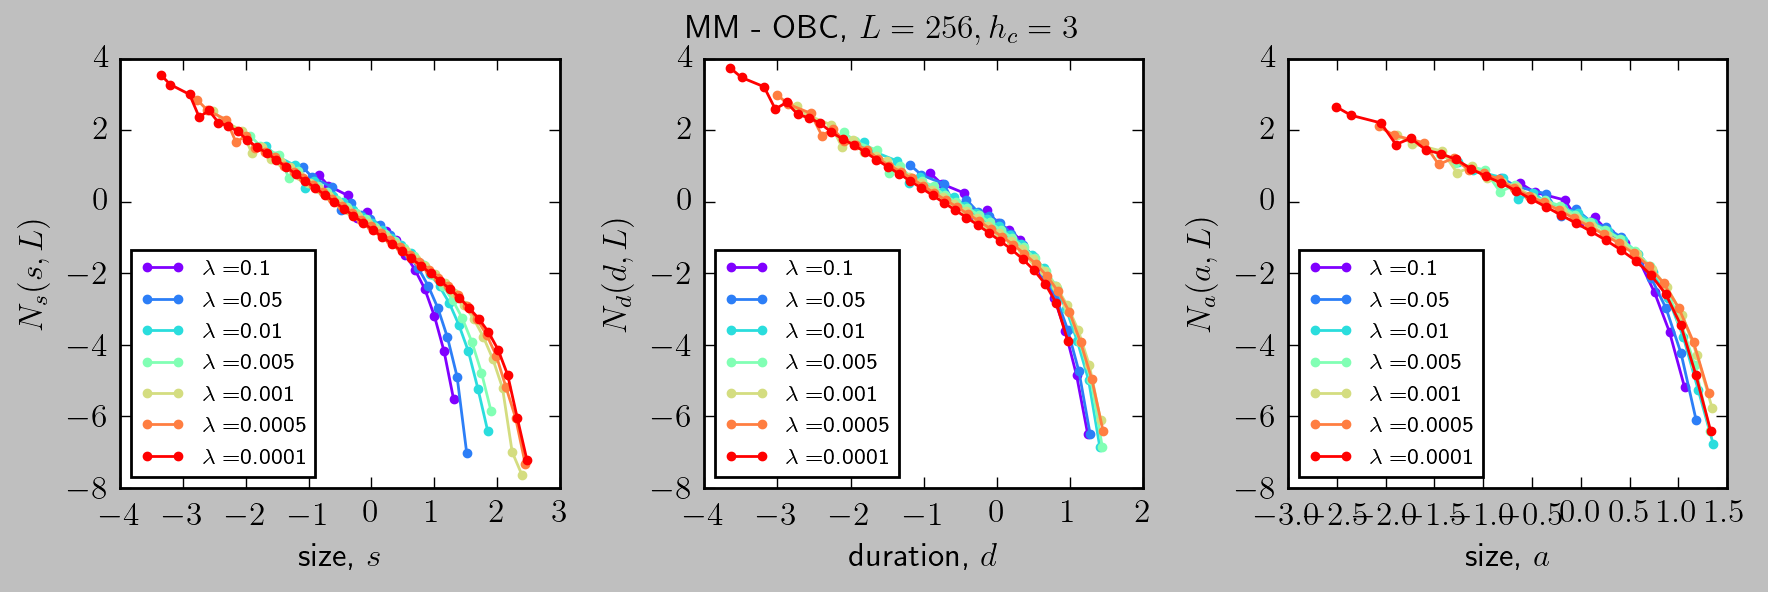

In [7]:
# -------------------- Create Figure  -------------------- #
seedrange = np.arange(4300,4307, 1)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(9, 3), dpi=200, frameon=True)
color = iter( cm.rainbow( np.linspace(0,1,len(seedrange)) ) )
for i in seedrange:  
    c = next( color )
    eta = plotD_plotSizes_rescaled(i, c)


# -- Decoration --
ax1.set_ylabel(r'$N_s(s,L)$',fontweight='bold'); ax1.set_xlabel('size, $s$',fontweight='bold')
ax2.set_ylabel(r'$N_d(d,L)$',fontweight='bold'); ax2.set_xlabel('duration, $d$',fontweight='bold')
ax3.set_ylabel(r'$N_a(a,L)$',fontweight='bold'); ax3.set_xlabel('size, $a$',fontweight='bold')
ax1.legend(loc=3, fontsize=8)
ax2.legend(loc=3, fontsize=8)
ax3.legend(loc=3, fontsize=8)
fig.suptitle("MM - OBC, $L = 256, h_c = 3$")


#### Finding exponents? 

In [ ]:
# -------------------- Fitting to FSS  -------------------- #
def plotFSS_1(seed, c, tau, d, filetype):
    """ seed - seed of run to plot
        c - color of the line being plotted
        tau, d - exponents for rescaling
        filetype - which quantity to plot / file to draw from
    """    
    x,y,params = plotSizes(seed, filetype);  #x = np.log10(x); y = np.log10(y)
    lambd = float(params[2])
    ax1.plot(x * lambd**(1/sigma), y * lambd**(-tau/sigma), 
             '.-', color=c, label = "L="+str(params[1]))
             
             
def diff_1(tau, d,  x1,y1,params1,  x2,y2,params2,  filetype, plotYes):
    """ Computes the difference w/ rescaled axis of two given runs with a given exponent set. Seed1/2 are the seeds of our desired runs."""
    
    x1_r = np.log10(x1 * float(params1[2])**(1/d)) 
    y1_r = np.log10(y1 * float(params1[2])**(-tau/d))

    x2_r = np.log10(x2 * float(params2[2])**(1/d)) 
    y2_r = np.log10(y2 * float(params2[2])**(-tau/d))
    
    if plotYes==True:
        plotPolyFit(x1_r, y1_r, x2_r, y2_r)

    Xstart = max(x1_r[0], x2_r[0])
    Xend = min(x1_r[-1], x2_r[-1])
#     with warnings.catch_warnings():
#         warnings.simplefilter('ignore', np.RankWarning)
    z1 = np.polyfit(x1_r, y1_r, 10)
    z2 = np.polyfit(x2_r, y2_r, 10)
    p1 = np.poly1d(z1)
    p2 = np.poly1d(z2)
    xp = np.linspace(Xstart,Xend, 100)

    return np.sqrt( np.sum( (p2(xp) - p1(xp))**2 ) )


def plotPolyFit(x1_r, y1_r, x2_r, y2_r):

    Xstart = max(x1_r[0], x2_r[0])
    Xend = min(x1_r[-1], x2_r[-1])

    z1 = np.polyfit(x1_r, y1_r, 10)
    z2 = np.polyfit(x2_r, y2_r, 10)
    p1 = np.poly1d(z1)
    p2 = np.poly1d(z2)
    xp = np.linspace(Xstart,Xend, 100)

    fig1, ax1 = plt.subplots(1,1,figsize=(4, 3.5), dpi=120,frameon=False)
    ax1.plot(x1_r, y1_r, 'r-')
    ax1.plot(xp, p1(xp), 'r--')
    ax1.plot(x2_r, y2_r, 'b-')
    ax1.plot(xp, p2(xp), 'b--')
    fig.show()

    
def diffoverRange(tauRange, dRange, seed1, seed2, filetype, plotYes):
    x1,y1,params1 = plotSizes(seed1, filetype)
    x2,y2,params2 = plotSizes(seed2, filetype)
    
    Z = np.zeros((len(tauRange), len(dRange)))
    for xxx in range(len(tauRange)):
        for yyy in range(len(dRange)):
            Z[xxx, yyy] = diff_1(tauRange[xxx], dRange[yyy],  x1,y1,params1,  x2,y2,params2,  filetype, plotYes)
    return Z

def find_min_idx(x):
    k = x.argmin()
    ncol = x.shape[1]
    return k//ncol, k%ncol

In [ ]:
tauRange = np.linspace(0.5, 5, 500)
sigmaRange = np.linspace(0.5, 5, 500)

Zs = diffoverRange(tauRange, sigmaRange, 4302, 4305, 's', plotYes=False)
Za = diffoverRange(tauRange, sigmaRange, 4302, 4305, 'a', plotYes=False)
Zd = diffoverRange(tauRange, sigmaRange, 4302, 4305, 'd', plotYes=False)
# print(Z)

In [ ]:

Z = Zs #==============================================
tauBest=tauRange[find_min_idx(Z)[0]]
sigmaBest=sigmaRange[find_min_idx(Z)[1]]
print(tauBest, sigmaBest)

fig = plt.figure(figsize=(6,4), dpi=120, frameon=True)
ax = plt.axes()
heatmap = ax.contourf(sigmaRange, tauRange, Z, 50, cmap='viridis')
ax.plot(sigmaBest, tauBest, color='red', marker='o')

ax.set_ylabel(r'$\tau_s$')
ax.set_xlabel(r'$\sigma_s$')
fig.colorbar(heatmap)
ax.set_title('Manna; size $s$', fontweight='bold')
fig.tight_layout()

Z = Za #==============================================
tauBest=tauRange[find_min_idx(Z)[0]]
sigmaBest=sigmaRange[find_min_idx(Z)[1]]
print(tauBest, sigmaBest)

fig = plt.figure(figsize=(6,4), dpi=120, frameon=True)
ax = plt.axes()
heatmap = ax.contourf(sigmaRange, tauRange, Z, 50, cmap='viridis')
ax.plot(sigmaBest, tauBest, color='red', marker='o')

ax.set_ylabel(r'$\tau_s$')
ax.set_xlabel(r'$\sigma_s$')
fig.colorbar(heatmap)
ax.set_title('Manna; size $a$', fontweight='bold')
fig.tight_layout()


Z = Zd #==============================================
tauBest=tauRange[find_min_idx(Z)[0]]
sigmaBest=sigmaRange[find_min_idx(Z)[1]]
print(tauBest, sigmaBest)

fig = plt.figure(figsize=(6,4), dpi=120, frameon=True)
ax = plt.axes()
heatmap = ax.contourf(sigmaRange, tauRange, Z, 50, cmap='viridis')
ax.plot(sigmaBest, tauBest, color='red', marker='o')

ax.set_ylabel(r'$\tau_s$')
ax.set_xlabel(r'$\sigma_s$')
fig.colorbar(heatmap)
ax.set_title('Manna; duration $D$', fontweight='bold')
fig.tight_layout()



In [ ]:
x1,y1,params1 = plotSizes(4302, 's')
x2,y2,params2 = plotSizes(4305, 's')
tau = 1.2881763527054109
sigma = 0.7775551102204409
# 1.2881763527054109 0.7775551102204409
# tau = 1.325; sigma = 1.104026845637584

diff_1(tau, sigma,  x1,y1,params1,  x2,y2,params2,  's', True)

### Height 2: MM_2

This is just the regular Manna model... 

#### Scaling Plots

In [ ]:
def plotD_plotSizes(seed, c):
    
    ## Sizes w/ double counting
    x,y,params = plotSizes(seed, filetype='s');  x = np.log10(x); y = np.log10(y)
    ax1.plot(x, y, '.-', color=c, label = r"$\lambda=$"+str(round(params[2],6)))
    
    ## Sizes w/o double counting
    x,y,params = plotSizes(seed, filetype='a');  x = np.log10(x); y = np.log10(y)
    ax3.plot(x, y, '.-', color=c, label = r"$\lambda=$"+str(round(params[2],6)))
    
    ## Durations
    x,y,params = plotSizes(seed, filetype='d');  x = np.log10(x); y = np.log10(y)
    ax2.plot(x, y, '.-', color=c,label = r"$\lambda=$"+str(round(params[2],6)))
    
    return params[3], params[2]

In [ ]:
# -------------------- Create Figure  -------------------- #
seedrange = np.arange(4300,4307, 1)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(9, 3), dpi=200, frameon=True)
color = iter( cm.rainbow( np.linspace(0,1,len(seedrange)) ) )
for i in seedrange:  
    c = next( color )
    eta, lamb = plotD_plotSizes(i, c)

# -- Decoration --
ax1.set_ylabel(r'$\log N_s(s,L)$',fontweight='bold'); ax1.set_xlabel('size, $\log s$',fontweight='bold')
ax2.set_ylabel(r'$\log N_d(d,L)$',fontweight='bold'); ax2.set_xlabel('duration, $\log d$',fontweight='bold')
ax3.set_ylabel(r'$\log N_a(a,L)$',fontweight='bold'); ax3.set_xlabel('size, $\log a$',fontweight='bold')
ax1.legend(loc=3, fontsize=6)
ax2.legend(loc=3, fontsize=6)
ax3.legend(loc=3, fontsize=6)


#### Data Collapse 

In [ ]:

# 1.211847389558233 2.7751004016064256
# 1.1716867469879517 2.0281124497991967
# 1.2720883534136547 1.5783132530120483

def plotD_plotSizes_rescaled(seed, c):
    
    ## Sizes w/ double counting
    x,y,params = plotSizes(seed, filetype='s');
    lambd = params[2];
#     tau = 1.223; sigma = 1.19143    # AM critical exponents 
    tau = 1.2915831663326653        # MM_3 critical exponents 
    sigma = 0.7354709418837675
    
    x_r = x * lambd**(1/sigma)
    y_r = y * lambd**(-tau/sigma)
    ax1.plot(np.log10(x_r), np.log10(y_r) , '.-', color=c, label = r"$\lambda=$"+str(round(lambd,6)))
    
    
    ## Sizes w/o double counting
    x,y,params = plotSizes(seed, filetype='a');  
    lambd = params[2];
#     tau = 1.179; sigma = 1.0982    # AM critical exponents 
    tau = 1.3066132264529058        # MM_3 critical exponents 
    sigma = 0.9809619238476954
    
    x_r = x * lambd**(1/sigma)
    y_r = y * lambd**(-tau/sigma)
    ax2.plot(np.log10(x_r), np.log10(y_r) , '.-', color=c, label = r"$\lambda=$"+str(round(lambd,6)))
    
    
    ## Durations
    x,y,params = plotSizes(seed, filetype='d');  
    lambd = params[2];
#     tau = 1.281; sigma = 1.595    # AM critical exponents 
    tau = 1.3416833667334669        # MM_3 critical exponents 
    sigma = 1.3667334669338675
    
    x_r = x * lambd**(1/sigma)
    y_r = y * lambd**(-tau/sigma)
    ax3.plot(np.log10(x_r), np.log10(y_r) , '.-', color=c, label = r"$\lambda=$"+str(round(lambd,6)))
    return params[3]

# 1.2915831663326653 0.7354709418837675
# 1.3066132264529058 0.9809619238476954
# 1.3416833667334669 1.3667334669338675

In [ ]:
# -------------------- Create Figure  -------------------- #
seedrange = np.arange(4300,4307, 1)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(9, 3), dpi=200, frameon=True)
color = iter( cm.rainbow( np.linspace(0,1,len(seedrange)) ) )
for i in seedrange:  
    c = next( color )
    eta = plotD_plotSizes_rescaled(i, c)


# -- Decoration --
ax1.set_ylabel(r'$N_s(s,L)$',fontweight='bold'); ax1.set_xlabel('size, $s$',fontweight='bold')
ax2.set_ylabel(r'$N_d(d,L)$',fontweight='bold'); ax2.set_xlabel('duration, $d$',fontweight='bold')
ax3.set_ylabel(r'$N_a(a,L)$',fontweight='bold'); ax3.set_xlabel('size, $a$',fontweight='bold')
ax1.legend(loc=3, fontsize=8)
ax2.legend(loc=3, fontsize=8)
ax3.legend(loc=3, fontsize=8)
fig.suptitle("MM - OBC, $L = 256, h_c = 2$")


#### Searching for better exponents? 

In [ ]:
# -------------------- Fitting to FSS  -------------------- #
def plotFSS_1(seed, c, tau, d, filetype):
    """ seed - seed of run to plot
        c - color of the line being plotted
        tau, d - exponents for rescaling
        filetype - which quantity to plot / file to draw from
    """    
    x,y,params = plotSizes(seed, filetype);  #x = np.log10(x); y = np.log10(y)
    lambd = float(params[2])
    ax1.plot(x * lambd**(1/sigma), y * lambd**(-tau/sigma), 
             '.-', color=c, label = "L="+str(params[1]))
             
             
def diff_1(tau, d,  x1,y1,params1,  x2,y2,params2,  filetype, plotYes):
    """ Computes the difference w/ rescaled axis of two given runs with a given exponent set. Seed1/2 are the seeds of our desired runs."""
    
    x1_r = np.log10(x1 * float(params1[2])**(1/d)) 
    y1_r = np.log10(y1 * float(params1[2])**(-tau/d))

    x2_r = np.log10(x2 * float(params2[2])**(1/d)) 
    y2_r = np.log10(y2 * float(params2[2])**(-tau/d))
    
    if plotYes==True:
        plotPolyFit(x1_r, y1_r, x2_r, y2_r)

    Xstart = max(x1_r[0], x2_r[0])
    Xend = min(x1_r[-1], x2_r[-1])
#     with warnings.catch_warnings():
#         warnings.simplefilter('ignore', np.RankWarning)
    z1 = np.polyfit(x1_r, y1_r, 10)
    z2 = np.polyfit(x2_r, y2_r, 10)
    p1 = np.poly1d(z1)
    p2 = np.poly1d(z2)
    xp = np.linspace(Xstart,Xend, 100)

    return np.sqrt( np.sum( (p2(xp) - p1(xp))**2 ) )


def plotPolyFit(x1_r, y1_r, x2_r, y2_r):

    Xstart = max(x1_r[0], x2_r[0])
    Xend = min(x1_r[-1], x2_r[-1])

    z1 = np.polyfit(x1_r, y1_r, 10)
    z2 = np.polyfit(x2_r, y2_r, 10)
    p1 = np.poly1d(z1)
    p2 = np.poly1d(z2)
    xp = np.linspace(Xstart,Xend, 100)

    fig1, ax1 = plt.subplots(1,1,figsize=(4, 3.5), dpi=120,frameon=False)
    ax1.plot(x1_r, y1_r, 'r-')
    ax1.plot(xp, p1(xp), 'r--')
    ax1.plot(x2_r, y2_r, 'b-')
    ax1.plot(xp, p2(xp), 'b--')
    fig.show()

    
def diffoverRange(tauRange, dRange, seed1, seed2, filetype, plotYes):
    x1,y1,params1 = plotSizes(seed1, filetype)
    x2,y2,params2 = plotSizes(seed2, filetype)
    
    Z = np.zeros((len(tauRange), len(dRange)))
    for xxx in range(len(tauRange)):
        for yyy in range(len(dRange)):
            Z[xxx, yyy] = diff_1(tauRange[xxx], dRange[yyy],  x1,y1,params1,  x2,y2,params2,  filetype, plotYes)
    return Z

def find_min_idx(x):
    k = x.argmin()
    ncol = x.shape[1]
    return k//ncol, k%ncol

In [ ]:
tauRange = np.linspace(0.5, 3, 500)
sigmaRange = np.linspace(0.5, 3, 500)

Zs = diffoverRange(tauRange, sigmaRange, 4202, 4204, 's', plotYes=False)
Za = diffoverRange(tauRange, sigmaRange, 4202, 4204, 'a', plotYes=False)
Zd = diffoverRange(tauRange, sigmaRange, 4202, 4204, 'd', plotYes=False)
# print(Z)

In [ ]:

Z = Zs #==============================================
tauBest=tauRange[find_min_idx(Z)[0]]
sigmaBest=sigmaRange[find_min_idx(Z)[1]]
print(tauBest, sigmaBest)

fig = plt.figure(figsize=(6,4), dpi=120, frameon=True)
ax = plt.axes()
heatmap = ax.contourf(sigmaRange, tauRange, Z, 50, cmap='viridis')
ax.plot(sigmaBest, tauBest, color='red', marker='o')

ax.set_ylabel(r'$\tau_s$')
ax.set_xlabel(r'$\sigma_s$')
fig.colorbar(heatmap)
ax.set_title('Manna; size $s$', fontweight='bold')
fig.tight_layout()

Z = Za #==============================================
tauBest=tauRange[find_min_idx(Z)[0]]
sigmaBest=sigmaRange[find_min_idx(Z)[1]]
print(tauBest, sigmaBest)

fig = plt.figure(figsize=(6,4), dpi=120, frameon=True)
ax = plt.axes()
heatmap = ax.contourf(sigmaRange, tauRange, Z, 50, cmap='viridis')
ax.plot(sigmaBest, tauBest, color='red', marker='o')

ax.set_ylabel(r'$\tau_s$')
ax.set_xlabel(r'$\sigma_s$')
fig.colorbar(heatmap)
ax.set_title('Manna; size $a$', fontweight='bold')
fig.tight_layout()


Z = Zd #==============================================
tauBest=tauRange[find_min_idx(Z)[0]]
sigmaBest=sigmaRange[find_min_idx(Z)[1]]
print(tauBest, sigmaBest)

fig = plt.figure(figsize=(6,4), dpi=120, frameon=True)
ax = plt.axes()
heatmap = ax.contourf(sigmaRange, tauRange, Z, 50, cmap='viridis')
ax.plot(sigmaBest, tauBest, color='red', marker='o')

ax.set_ylabel(r'$\tau_s$')
ax.set_xlabel(r'$\sigma_s$')
fig.colorbar(heatmap)
ax.set_title('Manna; duration $D$', fontweight='bold')
fig.tight_layout()



In [ ]:
x1,y1,params1 = plotSizes(4302, 's')
x2,y2,params2 = plotSizes(4305, 's')
tau = 1.2881763527054109
sigma = 0.7775551102204409
# 1.2881763527054109 0.7775551102204409
# tau = 1.325; sigma = 1.104026845637584

diff_1(tau, sigma,  x1,y1,params1,  x2,y2,params2,  's', True)

### Height 4: MM_4

Sakib's stochastic version of the AM. 

#### Scaling Plots

In [ ]:
def plotD_plotSizes(seed, c):
    
    ## Sizes w/ double counting
    x,y,params = plotSizes(seed, filetype='s');  x = np.log10(x); y = np.log10(y)
    ax1.plot(x, y, '.-', color=c, label = r"$\lambda=$"+str(round(params[2],6)))
    
    ## Sizes w/o double counting
    x,y,params = plotSizes(seed, filetype='a');  x = np.log10(x); y = np.log10(y)
    ax3.plot(x, y, '.-', color=c, label = r"$\lambda=$"+str(round(params[2],6)))
    
    ## Durations
    x,y,params = plotSizes(seed, filetype='d');  x = np.log10(x); y = np.log10(y)
    ax2.plot(x, y, '.-', color=c,label = r"$\lambda=$"+str(round(params[2],6)))
    
    return params[3], params[2]

In [ ]:
# -------------------- Create Figure  -------------------- #
seedrange = np.arange(4400,4407, 1)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(9, 3), dpi=200, frameon=True)
color = iter( cm.rainbow( np.linspace(0,1,len(seedrange)) ) )
for i in seedrange:  
    c = next( color )
    eta, lamb = plotD_plotSizes(i, c)

# -- Decoration --
ax1.set_ylabel(r'$\log N_s(s,L)$',fontweight='bold'); ax1.set_xlabel('size, $\log s$',fontweight='bold')
ax2.set_ylabel(r'$\log N_d(d,L)$',fontweight='bold'); ax2.set_xlabel('duration, $\log d$',fontweight='bold')
ax3.set_ylabel(r'$\log N_a(a,L)$',fontweight='bold'); ax3.set_xlabel('size, $\log a$',fontweight='bold')
ax1.legend(loc=3, fontsize=6)
ax2.legend(loc=3, fontsize=6)
ax3.legend(loc=3, fontsize=6)


#### Data Collapse 

In [ ]:

# 1.211847389558233 2.7751004016064256
# 1.1716867469879517 2.0281124497991967
# 1.2720883534136547 1.5783132530120483

def plotD_plotSizes_rescaled(seed, c):
    
    ## Sizes w/ double counting
    x,y,params = plotSizes(seed, filetype='s');
    lambd = params[2];
#     tau = 1.223; sigma = 1.19143    # AM critical exponents 
    tau = 1.276553106212425        # MM_3 critical exponents 
    sigma = 0.7555110220440882
    
    x_r = x * lambd**(1/sigma)
    y_r = y * lambd**(-tau/sigma)
    ax1.plot(np.log10(x_r), np.log10(y_r) , '.-', color=c, label = r"$\lambda=$"+str(round(lambd,6)))
    
    
    ## Sizes w/o double counting
    x,y,params = plotSizes(seed, filetype='a');  
    lambd = params[2];
#     tau = 1.179; sigma = 1.0982    # AM critical exponents 
    tau = 1.3016032064128256        # MM_3 critical exponents 
    sigma = 0.9859719438877755
    
    x_r = x * lambd**(1/sigma)
    y_r = y * lambd**(-tau/sigma)
    ax2.plot(np.log10(x_r), np.log10(y_r) , '.-', color=c, label = r"$\lambda=$"+str(round(lambd,6)))
    
    
    ## Durations
    x,y,params = plotSizes(seed, filetype='d');  
    lambd = params[2];
#     tau = 1.281; sigma = 1.595    # AM critical exponents 
    tau = 1.3366733466933867        # MM_3 critical exponents 
    sigma = 1.376753507014028
    
    x_r = x * lambd**(1/sigma)
    y_r = y * lambd**(-tau/sigma)
    ax3.plot(np.log10(x_r), np.log10(y_r) , '.-', color=c, label = r"$\lambda=$"+str(round(lambd,6)))
    return params[3]

# 1.276553106212425 0.7555110220440882
# 1.3016032064128256 0.9859719438877755
# 1.3366733466933867 1.376753507014028


In [ ]:
# -------------------- Create Figure  -------------------- #
seedrange = np.arange(4400,4407, 1)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(9, 3), dpi=200, frameon=True)
color = iter( cm.rainbow( np.linspace(0,1,len(seedrange)) ) )
for i in seedrange:  
    c = next( color )
    eta = plotD_plotSizes_rescaled(i, c)


# -- Decoration --
ax1.set_ylabel(r'$N_s(s,L)$',fontweight='bold'); ax1.set_xlabel('size, $s$',fontweight='bold')
ax2.set_ylabel(r'$N_d(d,L)$',fontweight='bold'); ax2.set_xlabel('duration, $d$',fontweight='bold')
ax3.set_ylabel(r'$N_a(a,L)$',fontweight='bold'); ax3.set_xlabel('size, $a$',fontweight='bold')
ax1.legend(loc=3, fontsize=8)
ax2.legend(loc=3, fontsize=8)
ax3.legend(loc=3, fontsize=8)
fig.suptitle("MM - OBC, $L = 256, h_c = 4$")


#### Searching for better exponents? 

In [ ]:
# -------------------- Fitting to FSS  -------------------- #
def plotFSS_1(seed, c, tau, d, filetype):
    """ seed - seed of run to plot
        c - color of the line being plotted
        tau, d - exponents for rescaling
        filetype - which quantity to plot / file to draw from
    """    
    x,y,params = plotSizes(seed, filetype);  #x = np.log10(x); y = np.log10(y)
    lambd = float(params[2])
    ax1.plot(x * lambd**(1/sigma), y * lambd**(-tau/sigma), 
             '.-', color=c, label = "L="+str(params[1]))
             
             
def diff_1(tau, d,  x1,y1,params1,  x2,y2,params2,  filetype, plotYes):
    """ Computes the difference w/ rescaled axis of two given runs with a given exponent set. Seed1/2 are the seeds of our desired runs."""
    
    x1_r = np.log10(x1 * float(params1[2])**(1/d)) 
    y1_r = np.log10(y1 * float(params1[2])**(-tau/d))

    x2_r = np.log10(x2 * float(params2[2])**(1/d)) 
    y2_r = np.log10(y2 * float(params2[2])**(-tau/d))
    
    if plotYes==True:
        plotPolyFit(x1_r, y1_r, x2_r, y2_r)

    Xstart = max(x1_r[0], x2_r[0])
    Xend = min(x1_r[-1], x2_r[-1])
#     with warnings.catch_warnings():
#         warnings.simplefilter('ignore', np.RankWarning)
    z1 = np.polyfit(x1_r, y1_r, 10)
    z2 = np.polyfit(x2_r, y2_r, 10)
    p1 = np.poly1d(z1)
    p2 = np.poly1d(z2)
    xp = np.linspace(Xstart,Xend, 100)

    return np.sqrt( np.sum( (p2(xp) - p1(xp))**2 ) )


def plotPolyFit(x1_r, y1_r, x2_r, y2_r):

    Xstart = max(x1_r[0], x2_r[0])
    Xend = min(x1_r[-1], x2_r[-1])

    z1 = np.polyfit(x1_r, y1_r, 10)
    z2 = np.polyfit(x2_r, y2_r, 10)
    p1 = np.poly1d(z1)
    p2 = np.poly1d(z2)
    xp = np.linspace(Xstart,Xend, 100)

    fig1, ax1 = plt.subplots(1,1,figsize=(4, 3.5), dpi=120,frameon=False)
    ax1.plot(x1_r, y1_r, 'r-')
    ax1.plot(xp, p1(xp), 'r--')
    ax1.plot(x2_r, y2_r, 'b-')
    ax1.plot(xp, p2(xp), 'b--')
    fig.show()

    
def diffoverRange(tauRange, dRange, seed1, seed2, filetype, plotYes):
    x1,y1,params1 = plotSizes(seed1, filetype)
    x2,y2,params2 = plotSizes(seed2, filetype)
    
    Z = np.zeros((len(tauRange), len(dRange)))
    for xxx in range(len(tauRange)):
        for yyy in range(len(dRange)):
            Z[xxx, yyy] = diff_1(tauRange[xxx], dRange[yyy],  x1,y1,params1,  x2,y2,params2,  filetype, plotYes)
    return Z

def find_min_idx(x):
    k = x.argmin()
    ncol = x.shape[1]
    return k//ncol, k%ncol

In [ ]:
tauRange = np.linspace(0.5, 3, 500)
sigmaRange = np.linspace(0.5, 3, 500)

Zs = diffoverRange(tauRange, sigmaRange, 4402, 4404, 's', plotYes=False)
Za = diffoverRange(tauRange, sigmaRange, 4402, 4404, 'a', plotYes=False)
Zd = diffoverRange(tauRange, sigmaRange, 4402, 4404, 'd', plotYes=False)
# print(Z)

In [ ]:

Z = Zs #==============================================
tauBest=tauRange[find_min_idx(Z)[0]]
sigmaBest=sigmaRange[find_min_idx(Z)[1]]
print(tauBest, sigmaBest)

fig = plt.figure(figsize=(6,4), dpi=120, frameon=True)
ax = plt.axes()
heatmap = ax.contourf(sigmaRange, tauRange, Z, 50, cmap='viridis')
ax.plot(sigmaBest, tauBest, color='red', marker='o')

ax.set_ylabel(r'$\tau_s$')
ax.set_xlabel(r'$\sigma_s$')
fig.colorbar(heatmap)
ax.set_title('Manna; size $s$', fontweight='bold')
fig.tight_layout()

Z = Za #==============================================
tauBest=tauRange[find_min_idx(Z)[0]]
sigmaBest=sigmaRange[find_min_idx(Z)[1]]
print(tauBest, sigmaBest)

fig = plt.figure(figsize=(6,4), dpi=120, frameon=True)
ax = plt.axes()
heatmap = ax.contourf(sigmaRange, tauRange, Z, 50, cmap='viridis')
ax.plot(sigmaBest, tauBest, color='red', marker='o')

ax.set_ylabel(r'$\tau_s$')
ax.set_xlabel(r'$\sigma_s$')
fig.colorbar(heatmap)
ax.set_title('Manna; size $a$', fontweight='bold')
fig.tight_layout()


Z = Zd #==============================================
tauBest=tauRange[find_min_idx(Z)[0]]
sigmaBest=sigmaRange[find_min_idx(Z)[1]]
print(tauBest, sigmaBest)

fig = plt.figure(figsize=(6,4), dpi=120, frameon=True)
ax = plt.axes()
heatmap = ax.contourf(sigmaRange, tauRange, Z, 50, cmap='viridis')
ax.plot(sigmaBest, tauBest, color='red', marker='o')

ax.set_ylabel(r'$\tau_s$')
ax.set_xlabel(r'$\sigma_s$')
fig.colorbar(heatmap)
ax.set_title('Manna; duration $D$', fontweight='bold')
fig.tight_layout()



In [ ]:
x1,y1,params1 = plotSizes(4302, 's')
x2,y2,params2 = plotSizes(4305, 's')
tau = 1.2881763527054109
sigma = 0.7775551102204409
# 1.2881763527054109 0.7775551102204409
# tau = 1.325; sigma = 1.104026845637584

diff_1(tau, sigma,  x1,y1,params1,  x2,y2,params2,  's', True)

### Height 5: MM_5


#### Scaling Plots

In [ ]:
def plotD_plotSizes(seed, c):
    
    ## Sizes w/ double counting
    x,y,params = plotSizes(seed, filetype='s');  x = np.log10(x); y = np.log10(y)
    ax1.plot(x, y, '.-', color=c, label = r"$\lambda=$"+str(round(params[2],6)))
    
    ## Sizes w/o double counting
    x,y,params = plotSizes(seed, filetype='a');  x = np.log10(x); y = np.log10(y)
    ax3.plot(x, y, '.-', color=c, label = r"$\lambda=$"+str(round(params[2],6)))
    
    ## Durations
    x,y,params = plotSizes(seed, filetype='d');  x = np.log10(x); y = np.log10(y)
    ax2.plot(x, y, '.-', color=c,label = r"$\lambda=$"+str(round(params[2],6)))
    
    return params[3], params[2]

In [ ]:
# -------------------- Create Figure  -------------------- #
seedrange = np.arange(4500,4507, 1)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(9, 3), dpi=200, frameon=True)
color = iter( cm.rainbow( np.linspace(0,1,len(seedrange)) ) )
for i in seedrange:  
    c = next( color )
    eta, lamb = plotD_plotSizes(i, c)

# -- Decoration --
ax1.set_ylabel(r'$\log N_s(s,L)$',fontweight='bold'); ax1.set_xlabel('size, $\log s$',fontweight='bold')
ax2.set_ylabel(r'$\log N_d(d,L)$',fontweight='bold'); ax2.set_xlabel('duration, $\log d$',fontweight='bold')
ax3.set_ylabel(r'$\log N_a(a,L)$',fontweight='bold'); ax3.set_xlabel('size, $\log a$',fontweight='bold')
ax1.legend(loc=3, fontsize=6)
ax2.legend(loc=3, fontsize=6)
ax3.legend(loc=3, fontsize=6)


#### Data Collapse 

In [ ]:

# 1.211847389558233 2.7751004016064256
# 1.1716867469879517 2.0281124497991967
# 1.2720883534136547 1.5783132530120483

def plotD_plotSizes_rescaled(seed, c):
    
    ## Sizes w/ double counting
    x,y,params = plotSizes(seed, filetype='s');
    lambd = params[2];
#     tau = 1.223; sigma = 1.19143    # AM critical exponents 
    tau = 1.276553106212425        # MM_3 critical exponents 
    sigma = 0.7555110220440882
    
    x_r = x * lambd**(1/sigma)
    y_r = y * lambd**(-tau/sigma)
    ax1.plot(np.log10(x_r), np.log10(y_r) , '.-', color=c, label = r"$\lambda=$"+str(round(lambd,6)))
    
    
    ## Sizes w/o double counting
    x,y,params = plotSizes(seed, filetype='a');  
    lambd = params[2];
#     tau = 1.179; sigma = 1.0982    # AM critical exponents 
    tau = 1.3066132264529058        # MM_3 critical exponents 
    sigma = 0.9809619238476954
    
    x_r = x * lambd**(1/sigma)
    y_r = y * lambd**(-tau/sigma)
    ax2.plot(np.log10(x_r), np.log10(y_r) , '.-', color=c, label = r"$\lambda=$"+str(round(lambd,6)))
    
    
    ## Durations
    x,y,params = plotSizes(seed, filetype='d');  
    lambd = params[2];
#     tau = 1.281; sigma = 1.595    # AM critical exponents 
    tau = 1.3316633266533064        # MM_3 critical exponents 
    sigma = 1.346693386773547
    
    x_r = x * lambd**(1/sigma)
    y_r = y * lambd**(-tau/sigma)
    ax3.plot(np.log10(x_r), np.log10(y_r) , '.-', color=c, label = r"$\lambda=$"+str(round(lambd,6)))
    return params[3]

# 1.276553106212425 0.7555110220440882
# 1.3066132264529058 0.9809619238476954
# 1.3316633266533064 1.346693386773547


In [ ]:
# -------------------- Create Figure  -------------------- #
seedrange = np.arange(4500,4507, 1)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(9, 3), dpi=200, frameon=True)
color = iter( cm.rainbow( np.linspace(0,1,len(seedrange)) ) )
for i in seedrange:  
    c = next( color )
    eta = plotD_plotSizes_rescaled(i, c)


# -- Decoration --
ax1.set_ylabel(r'$N_s(s,L)$',fontweight='bold'); ax1.set_xlabel('size, $s$',fontweight='bold')
ax2.set_ylabel(r'$N_d(d,L)$',fontweight='bold'); ax2.set_xlabel('duration, $d$',fontweight='bold')
ax3.set_ylabel(r'$N_a(a,L)$',fontweight='bold'); ax3.set_xlabel('size, $a$',fontweight='bold')
ax1.legend(loc=3, fontsize=8)
ax2.legend(loc=3, fontsize=8)
ax3.legend(loc=3, fontsize=8)
fig.suptitle("MM - OBC, $L = 256, h_c = 5$")


#### Searching for better exponents? 

In [ ]:
# -------------------- Fitting to FSS  -------------------- #
def plotFSS_1(seed, c, tau, d, filetype):
    """ seed - seed of run to plot
        c - color of the line being plotted
        tau, d - exponents for rescaling
        filetype - which quantity to plot / file to draw from
    """    
    x,y,params = plotSizes(seed, filetype);  #x = np.log10(x); y = np.log10(y)
    lambd = float(params[2])
    ax1.plot(x * lambd**(1/sigma), y * lambd**(-tau/sigma), 
             '.-', color=c, label = "L="+str(params[1]))
             
             
def diff_1(tau, d,  x1,y1,params1,  x2,y2,params2,  filetype, plotYes):
    """ Computes the difference w/ rescaled axis of two given runs with a given exponent set. Seed1/2 are the seeds of our desired runs."""
    
    x1_r = np.log10(x1 * float(params1[2])**(1/d)) 
    y1_r = np.log10(y1 * float(params1[2])**(-tau/d))

    x2_r = np.log10(x2 * float(params2[2])**(1/d)) 
    y2_r = np.log10(y2 * float(params2[2])**(-tau/d))
    
    if plotYes==True:
        plotPolyFit(x1_r, y1_r, x2_r, y2_r)

    Xstart = max(x1_r[0], x2_r[0])
    Xend = min(x1_r[-1], x2_r[-1])
#     with warnings.catch_warnings():
#         warnings.simplefilter('ignore', np.RankWarning)
    z1 = np.polyfit(x1_r, y1_r, 10)
    z2 = np.polyfit(x2_r, y2_r, 10)
    p1 = np.poly1d(z1)
    p2 = np.poly1d(z2)
    xp = np.linspace(Xstart,Xend, 100)

    return np.sqrt( np.sum( (p2(xp) - p1(xp))**2 ) )


def plotPolyFit(x1_r, y1_r, x2_r, y2_r):

    Xstart = max(x1_r[0], x2_r[0])
    Xend = min(x1_r[-1], x2_r[-1])

    z1 = np.polyfit(x1_r, y1_r, 10)
    z2 = np.polyfit(x2_r, y2_r, 10)
    p1 = np.poly1d(z1)
    p2 = np.poly1d(z2)
    xp = np.linspace(Xstart,Xend, 100)

    fig1, ax1 = plt.subplots(1,1,figsize=(4, 3.5), dpi=120,frameon=False)
    ax1.plot(x1_r, y1_r, 'r-')
    ax1.plot(xp, p1(xp), 'r--')
    ax1.plot(x2_r, y2_r, 'b-')
    ax1.plot(xp, p2(xp), 'b--')
    fig.show()

    
def diffoverRange(tauRange, dRange, seed1, seed2, filetype, plotYes):
    x1,y1,params1 = plotSizes(seed1, filetype)
    x2,y2,params2 = plotSizes(seed2, filetype)
    
    Z = np.zeros((len(tauRange), len(dRange)))
    for xxx in range(len(tauRange)):
        for yyy in range(len(dRange)):
            Z[xxx, yyy] = diff_1(tauRange[xxx], dRange[yyy],  x1,y1,params1,  x2,y2,params2,  filetype, plotYes)
    return Z

def find_min_idx(x):
    k = x.argmin()
    ncol = x.shape[1]
    return k//ncol, k%ncol

In [ ]:
tauRange = np.linspace(0.5, 3, 500)
sigmaRange = np.linspace(0.5, 3, 500)

Zs = diffoverRange(tauRange, sigmaRange, 4502, 4504, 's', plotYes=False)
Za = diffoverRange(tauRange, sigmaRange, 4502, 4504, 'a', plotYes=False)
Zd = diffoverRange(tauRange, sigmaRange, 4502, 4504, 'd', plotYes=False)
# print(Z)

In [ ]:

Z = Zs #==============================================
tauBest=tauRange[find_min_idx(Z)[0]]
sigmaBest=sigmaRange[find_min_idx(Z)[1]]
print(tauBest, sigmaBest)

fig = plt.figure(figsize=(6,4), dpi=120, frameon=True)
ax = plt.axes()
heatmap = ax.contourf(sigmaRange, tauRange, Z, 50, cmap='viridis')
ax.plot(sigmaBest, tauBest, color='red', marker='o')

ax.set_ylabel(r'$\tau_s$')
ax.set_xlabel(r'$\sigma_s$')
fig.colorbar(heatmap)
ax.set_title('Manna; size $s$', fontweight='bold')
fig.tight_layout()

Z = Za #==============================================
tauBest=tauRange[find_min_idx(Z)[0]]
sigmaBest=sigmaRange[find_min_idx(Z)[1]]
print(tauBest, sigmaBest)

fig = plt.figure(figsize=(6,4), dpi=120, frameon=True)
ax = plt.axes()
heatmap = ax.contourf(sigmaRange, tauRange, Z, 50, cmap='viridis')
ax.plot(sigmaBest, tauBest, color='red', marker='o')

ax.set_ylabel(r'$\tau_s$')
ax.set_xlabel(r'$\sigma_s$')
fig.colorbar(heatmap)
ax.set_title('Manna; size $a$', fontweight='bold')
fig.tight_layout()


Z = Zd #==============================================
tauBest=tauRange[find_min_idx(Z)[0]]
sigmaBest=sigmaRange[find_min_idx(Z)[1]]
print(tauBest, sigmaBest)

fig = plt.figure(figsize=(6,4), dpi=120, frameon=True)
ax = plt.axes()
heatmap = ax.contourf(sigmaRange, tauRange, Z, 50, cmap='viridis')
ax.plot(sigmaBest, tauBest, color='red', marker='o')

ax.set_ylabel(r'$\tau_s$')
ax.set_xlabel(r'$\sigma_s$')
fig.colorbar(heatmap)
ax.set_title('Manna; duration $D$', fontweight='bold')
fig.tight_layout()



In [ ]:
x1,y1,params1 = plotSizes(4302, 's')
x2,y2,params2 = plotSizes(4305, 's')
tau = 1.2881763527054109
sigma = 0.7775551102204409
# 1.2881763527054109 0.7775551102204409
# tau = 1.325; sigma = 1.104026845637584

diff_1(tau, sigma,  x1,y1,params1,  x2,y2,params2,  's', True)

### Critical exponent dependence on height

In [5]:
h2 = [1.2915831663326653, 0.7354709418837675,
      1.3066132264529058, 0.9809619238476954,
      1.3416833667334669, 1.3667334669338675]


h3 = [1.3026052104208419, 0.7705410821643286,
      1.3206412825651301, 1.0230460921843687,
      1.4018036072144289, 1.4018036072144289]

h4 = [1.276553106212425, 0.7555110220440882,
      1.3016032064128256, 0.9859719438877755,
      1.3366733466933867, 1.376753507014028]

h5 = [1.276553106212425, 0.7555110220440882,
      1.3066132264529058, 0.9809619238476954,
      1.3316633266533064, 1.346693386773547]

height = [2,3,4,5]
tau_s = [h2[0], h3[0], h4[0], h5[0]]
sigma_s = [h2[1], h3[1], h4[1], h5[1]]
tau_a = [h2[2], h3[2], h4[2], h5[2]]
sigma_a = [h2[3], h3[3], h4[3], h5[3]]
tau_d = [h2[4], h3[4], h4[4], h5[4]]
sigma_d = [h2[5], h3[5], h4[5], h5[5]]


# -------------------- Create Figure  -------------------- #
seedrange = np.arange(4500,4506, 1)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(7, 3), dpi=200, frameon=True)

ax1.plot(height, tau_s, 'r-o', label=r"size - $\tau_s$")
ax2.plot(height, sigma_s, 'm-o', label=r"size - $\sigma_s$")
ax1.plot(height, tau_a, 'b-o', label=r"area - $\tau_a$")
ax2.plot(height, sigma_a, 'c-o', label=r"area - $\sigma_a$")
ax1.plot(height, tau_d, 'g-o', label=r"duration - $\tau_d$")
ax2.plot(height, sigma_d, 'y-o', label=r"duration - $\sigma_d$")

# ax1.plot(np.asarray(height), np.asarray(height)*0 + 1.203, 'r--', label=r"AM: size - $\tau_s$")
# ax1.plot(np.asarray(height), np.asarray(height)*0 + 1.179, 'b--', label=r"AM: area - $\tau_a$")
# ax1.plot(np.asarray(height), np.asarray(height)*0 + 1.281, 'g--', label=r"AM: duration - $\tau_d$")



# -- Decoration --
ax1.set_xlabel(r'height, $h$',fontweight='bold'); 
ax1.set_ylabel('exponent',fontweight='bold')
ax1.legend(fontsize=9)

ax2.set_xlabel(r'height, $h$',fontweight='bold'); 
ax2.set_ylabel('exponent',fontweight='bold')
ax2.legend(fontsize=9)

fig.suptitle("MM-OBC, $L=256$")


Text(0.5, 0.98, 'MM-OBC, $L=256$')

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x11ad69a60> (for post_execute):


FileNotFoundError: [Errno 2] No such file or directory: '/private/var/mobile/Containers/Data/Application/9A169011-B343-40EA-A6A7-9B289CFA29B1/tmp/matplotlib-9kc1lwm3/tex.cache/857b03f78dcf2e48225de4b236393502.dvi'

FileNotFoundError: [Errno 2] No such file or directory: '/private/var/mobile/Containers/Data/Application/9A169011-B343-40EA-A6A7-9B289CFA29B1/tmp/matplotlib-9kc1lwm3/tex.cache/857b03f78dcf2e48225de4b236393502.dvi'

<Figure size 1400x600 with 2 Axes>

## Manna Model w/ Deterministic Firing

### MM w/ Firing Upwards

#### Scaling Plots

In [ ]:
def plotD_plotSizes(seed, c):
    
    ## Sizes w/ double counting
    x,y,params = plotSizes(seed, filetype='s');  x = np.log10(x); y = np.log10(y)
    ax1.plot(x, y, '.-', color=c, label = r"$\lambda=$"+str(round(params[2],6)))
    
    ## Sizes w/o double counting
    x,y,params = plotSizes(seed, filetype='a');  x = np.log10(x); y = np.log10(y)
    ax3.plot(x, y, '.-', color=c, label = r"$\lambda=$"+str(round(params[2],6)))
    
    ## Durations
    x,y,params = plotSizes(seed, filetype='d');  x = np.log10(x); y = np.log10(y)
    ax2.plot(x, y, '.-', color=c,label = r"$\lambda=$"+str(round(params[2],6)))
    
    return params[3], params[2]

In [ ]:
# -------------------- Create Figure  -------------------- #
seedrange = np.arange(5200,5207, 1)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(9, 3), dpi=200, frameon=True)
color = iter( cm.rainbow( np.linspace(0,1,len(seedrange)) ) )
for i in seedrange:  
    c = next( color )
    eta, lamb = plotD_plotSizes(i, c)

# -- Decoration --
ax1.set_ylabel(r'$\log N_s(s,L)$',fontweight='bold'); ax1.set_xlabel('size, $\log s$',fontweight='bold')
ax2.set_ylabel(r'$\log N_d(d,L)$',fontweight='bold'); ax2.set_xlabel('duration, $\log d$',fontweight='bold')
ax3.set_ylabel(r'$\log N_a(a,L)$',fontweight='bold'); ax3.set_xlabel('size, $\log a$',fontweight='bold')
ax1.legend(loc=3, fontsize=6)
ax2.legend(loc=3, fontsize=6)
ax3.legend(loc=3, fontsize=6)


#### Data collapse 

In [ ]:

# 1.211847389558233 2.7751004016064256
# 1.1716867469879517 2.0281124497991967
# 1.2720883534136547 1.5783132530120483

def plotD_plotSizes_rescaled(seed, c):
    
    ## Sizes w/ double counting
    x,y,params = plotSizes(seed, filetype='s');
    lambd = params[2];
#     tau = 1.223; sigma = 1.19143    # AM critical exponents 
    tau = 1.3026052104208419        # MM_3 critical exponents 
    sigma = 0.7705410821643286
    
    x_r = x * lambd**(1/sigma)
    y_r = y * lambd**(-tau/sigma)
    ax1.plot(np.log10(x_r), np.log10(y_r) , '.-', color=c, label = r"$\lambda=$"+str(round(lambd,6)))
    
    
    ## Sizes w/o double counting
    x,y,params = plotSizes(seed, filetype='a');  
    lambd = params[2];
#     tau = 1.179; sigma = 1.0982    # AM critical exponents 
    tau = 1.3206412825651301        # MM_3 critical exponents 
    sigma = 1.0230460921843687
    
    x_r = x * lambd**(1/sigma)
    y_r = y * lambd**(-tau/sigma)
    ax2.plot(np.log10(x_r), np.log10(y_r) , '.-', color=c, label = r"$\lambda=$"+str(round(lambd,6)))
    
    
    ## Durations
    x,y,params = plotSizes(seed, filetype='d');  
    lambd = params[2];
#     tau = 1.281; sigma = 1.595    # AM critical exponents 
    tau = 1.4018036072144289        # MM_3 critical exponents 
    sigma = 1.4018036072144289
    
    x_r = x * lambd**(1/sigma)
    y_r = y * lambd**(-tau/sigma)
    ax3.plot(np.log10(x_r), np.log10(y_r) , '.-', color=c, label = r"$\lambda=$"+str(round(lambd,6)))
    return params[3]

# 1.3026052104208419 0.7705410821643286
# 1.3206412825651301 1.0230460921843687
# 1.4018036072144289 1.4018036072144289

In [ ]:
# -------------------- Create Figure  -------------------- #
seedrange = np.arange(4300,4307, 1)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(9, 3), dpi=200, frameon=True)
color = iter( cm.rainbow( np.linspace(0,1,len(seedrange)) ) )
for i in seedrange:  
    c = next( color )
    eta = plotD_plotSizes_rescaled(i, c)


# -- Decoration --
ax1.set_ylabel(r'$N_s(s,L)$',fontweight='bold'); ax1.set_xlabel('size, $s$',fontweight='bold')
ax2.set_ylabel(r'$N_d(d,L)$',fontweight='bold'); ax2.set_xlabel('duration, $d$',fontweight='bold')
ax3.set_ylabel(r'$N_a(a,L)$',fontweight='bold'); ax3.set_xlabel('size, $a$',fontweight='bold')
ax1.legend(loc=3, fontsize=8)
ax2.legend(loc=3, fontsize=8)
ax3.legend(loc=3, fontsize=8)
fig.suptitle("MM - OBC, $L = 256, h_c = 3$")


#### Finding exponents? 

In [ ]:
# -------------------- Fitting to FSS  -------------------- #
def plotFSS_1(seed, c, tau, d, filetype):
    """ seed - seed of run to plot
        c - color of the line being plotted
        tau, d - exponents for rescaling
        filetype - which quantity to plot / file to draw from
    """    
    x,y,params = plotSizes(seed, filetype);  #x = np.log10(x); y = np.log10(y)
    lambd = float(params[2])
    ax1.plot(x * lambd**(1/sigma), y * lambd**(-tau/sigma), 
             '.-', color=c, label = "L="+str(params[1]))
             
             
def diff_1(tau, d,  x1,y1,params1,  x2,y2,params2,  filetype, plotYes):
    """ Computes the difference w/ rescaled axis of two given runs with a given exponent set. Seed1/2 are the seeds of our desired runs."""
    
    x1_r = np.log10(x1 * float(params1[2])**(1/d)) 
    y1_r = np.log10(y1 * float(params1[2])**(-tau/d))

    x2_r = np.log10(x2 * float(params2[2])**(1/d)) 
    y2_r = np.log10(y2 * float(params2[2])**(-tau/d))
    
    if plotYes==True:
        plotPolyFit(x1_r, y1_r, x2_r, y2_r)

    Xstart = max(x1_r[0], x2_r[0])
    Xend = min(x1_r[-1], x2_r[-1])
#     with warnings.catch_warnings():
#         warnings.simplefilter('ignore', np.RankWarning)
    z1 = np.polyfit(x1_r, y1_r, 10)
    z2 = np.polyfit(x2_r, y2_r, 10)
    p1 = np.poly1d(z1)
    p2 = np.poly1d(z2)
    xp = np.linspace(Xstart,Xend, 100)

    return np.sqrt( np.sum( (p2(xp) - p1(xp))**2 ) )


def plotPolyFit(x1_r, y1_r, x2_r, y2_r):

    Xstart = max(x1_r[0], x2_r[0])
    Xend = min(x1_r[-1], x2_r[-1])

    z1 = np.polyfit(x1_r, y1_r, 10)
    z2 = np.polyfit(x2_r, y2_r, 10)
    p1 = np.poly1d(z1)
    p2 = np.poly1d(z2)
    xp = np.linspace(Xstart,Xend, 100)

    fig1, ax1 = plt.subplots(1,1,figsize=(4, 3.5), dpi=120,frameon=False)
    ax1.plot(x1_r, y1_r, 'r-')
    ax1.plot(xp, p1(xp), 'r--')
    ax1.plot(x2_r, y2_r, 'b-')
    ax1.plot(xp, p2(xp), 'b--')
    fig.show()

    
def diffoverRange(tauRange, dRange, seed1, seed2, filetype, plotYes):
    x1,y1,params1 = plotSizes(seed1, filetype)
    x2,y2,params2 = plotSizes(seed2, filetype)
    
    Z = np.zeros((len(tauRange), len(dRange)))
    for xxx in range(len(tauRange)):
        for yyy in range(len(dRange)):
            Z[xxx, yyy] = diff_1(tauRange[xxx], dRange[yyy],  x1,y1,params1,  x2,y2,params2,  filetype, plotYes)
    return Z

def find_min_idx(x):
    k = x.argmin()
    ncol = x.shape[1]
    return k//ncol, k%ncol

In [ ]:
tauRange = np.linspace(0.5, 5, 500)
sigmaRange = np.linspace(0.5, 5, 500)

Zs = diffoverRange(tauRange, sigmaRange, 4302, 4305, 's', plotYes=False)
Za = diffoverRange(tauRange, sigmaRange, 4302, 4305, 'a', plotYes=False)
Zd = diffoverRange(tauRange, sigmaRange, 4302, 4305, 'd', plotYes=False)
# print(Z)

In [ ]:

Z = Zs #==============================================
tauBest=tauRange[find_min_idx(Z)[0]]
sigmaBest=sigmaRange[find_min_idx(Z)[1]]
print(tauBest, sigmaBest)

fig = plt.figure(figsize=(6,4), dpi=120, frameon=True)
ax = plt.axes()
heatmap = ax.contourf(sigmaRange, tauRange, Z, 50, cmap='viridis')
ax.plot(sigmaBest, tauBest, color='red', marker='o')

ax.set_ylabel(r'$\tau_s$')
ax.set_xlabel(r'$\sigma_s$')
fig.colorbar(heatmap)
ax.set_title('Manna; size $s$', fontweight='bold')
fig.tight_layout()

Z = Za #==============================================
tauBest=tauRange[find_min_idx(Z)[0]]
sigmaBest=sigmaRange[find_min_idx(Z)[1]]
print(tauBest, sigmaBest)

fig = plt.figure(figsize=(6,4), dpi=120, frameon=True)
ax = plt.axes()
heatmap = ax.contourf(sigmaRange, tauRange, Z, 50, cmap='viridis')
ax.plot(sigmaBest, tauBest, color='red', marker='o')

ax.set_ylabel(r'$\tau_s$')
ax.set_xlabel(r'$\sigma_s$')
fig.colorbar(heatmap)
ax.set_title('Manna; size $a$', fontweight='bold')
fig.tight_layout()


Z = Zd #==============================================
tauBest=tauRange[find_min_idx(Z)[0]]
sigmaBest=sigmaRange[find_min_idx(Z)[1]]
print(tauBest, sigmaBest)

fig = plt.figure(figsize=(6,4), dpi=120, frameon=True)
ax = plt.axes()
heatmap = ax.contourf(sigmaRange, tauRange, Z, 50, cmap='viridis')
ax.plot(sigmaBest, tauBest, color='red', marker='o')

ax.set_ylabel(r'$\tau_s$')
ax.set_xlabel(r'$\sigma_s$')
fig.colorbar(heatmap)
ax.set_title('Manna; duration $D$', fontweight='bold')
fig.tight_layout()



In [ ]:
x1,y1,params1 = plotSizes(4302, 's')
x2,y2,params2 = plotSizes(4305, 's')
tau = 1.2881763527054109
sigma = 0.7775551102204409
# 1.2881763527054109 0.7775551102204409
# tau = 1.325; sigma = 1.104026845637584

diff_1(tau, sigma,  x1,y1,params1,  x2,y2,params2,  's', True)

### MM w/ Firing y-direction

#### Scaling Plots

In [4]:
def plotD_plotSizes(seed, c):
    
    ## Sizes w/ double counting
    x,y,params = plotSizes(seed, filetype='s');  x = np.log10(x); y = np.log10(y)
    ax1.plot(x, y, '.-', color=c, label = r"$\lambda=$"+str(round(params[2],6)))
    
    ## Sizes w/o double counting
    x,y,params = plotSizes(seed, filetype='a');  x = np.log10(x); y = np.log10(y)
    ax3.plot(x, y, '.-', color=c, label = r"$\lambda=$"+str(round(params[2],6)))
    
    ## Durations
    x,y,params = plotSizes(seed, filetype='d');  x = np.log10(x); y = np.log10(y)
    ax2.plot(x, y, '.-', color=c,label = r"$\lambda=$"+str(round(params[2],6)))
    
    return params[3], params[2]

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


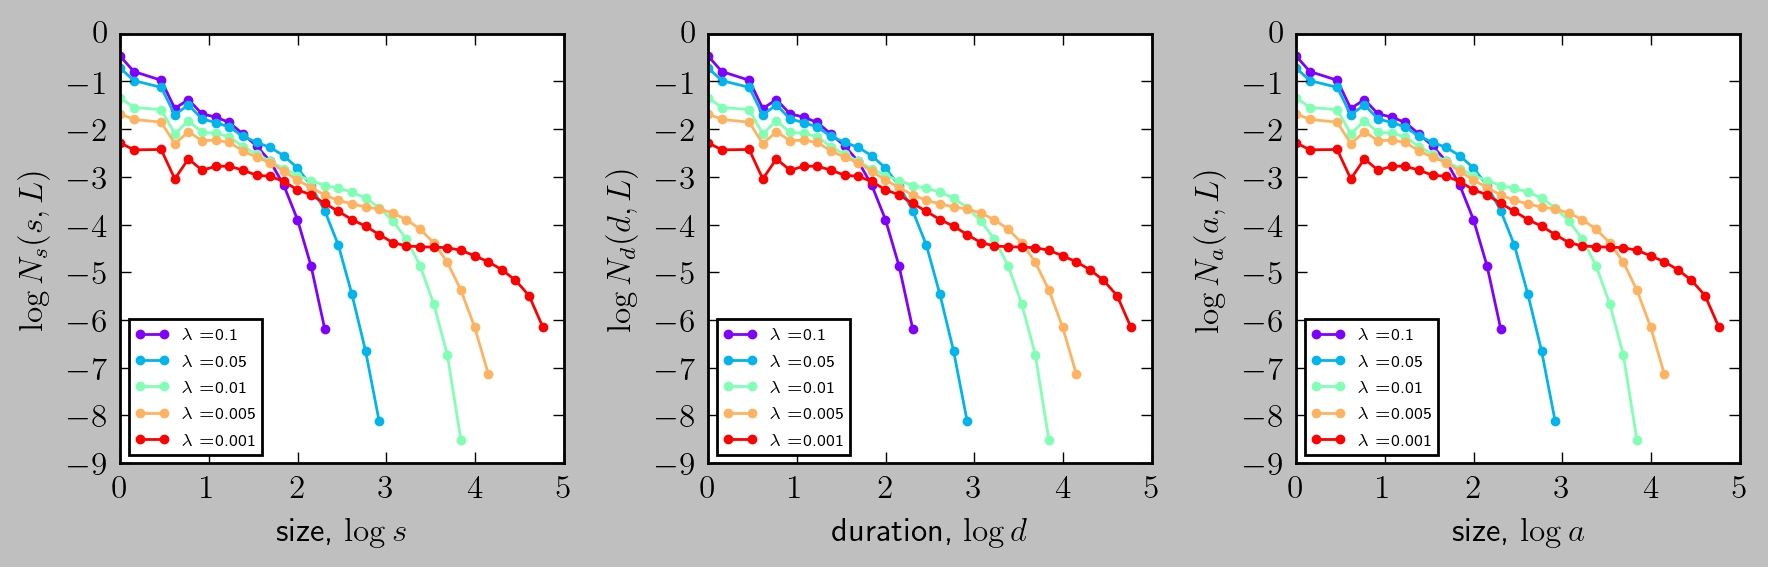

In [5]:
# -------------------- Create Figure  -------------------- #
seedrange = np.arange(5300,5305, 1)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(9, 3), dpi=200, frameon=True)
color = iter( cm.rainbow( np.linspace(0,1,len(seedrange)) ) )
for i in seedrange:  
    c = next( color )
    eta, lamb = plotD_plotSizes(i, c)

# -- Decoration --
ax1.set_ylabel(r'$\log N_s(s,L)$',fontweight='bold'); ax1.set_xlabel('size, $\log s$',fontweight='bold')
ax2.set_ylabel(r'$\log N_d(d,L)$',fontweight='bold'); ax2.set_xlabel('duration, $\log d$',fontweight='bold')
ax3.set_ylabel(r'$\log N_a(a,L)$',fontweight='bold'); ax3.set_xlabel('size, $\log a$',fontweight='bold')
ax1.legend(loc=3, fontsize=6)
ax2.legend(loc=3, fontsize=6)
ax3.legend(loc=3, fontsize=6)


#### Data collapse 

In [ ]:

# 1.211847389558233 2.7751004016064256
# 1.1716867469879517 2.0281124497991967
# 1.2720883534136547 1.5783132530120483

def plotD_plotSizes_rescaled(seed, c):
    
    ## Sizes w/ double counting
    x,y,params = plotSizes(seed, filetype='s');
    lambd = params[2];
#     tau = 1.223; sigma = 1.19143    # AM critical exponents 
    tau = 1.3026052104208419        # MM_3 critical exponents 
    sigma = 0.7705410821643286
    
    x_r = x * lambd**(1/sigma)
    y_r = y * lambd**(-tau/sigma)
    ax1.plot(np.log10(x_r), np.log10(y_r) , '.-', color=c, label = r"$\lambda=$"+str(round(lambd,6)))
    
    
    ## Sizes w/o double counting
    x,y,params = plotSizes(seed, filetype='a');  
    lambd = params[2];
#     tau = 1.179; sigma = 1.0982    # AM critical exponents 
    tau = 1.3206412825651301        # MM_3 critical exponents 
    sigma = 1.0230460921843687
    
    x_r = x * lambd**(1/sigma)
    y_r = y * lambd**(-tau/sigma)
    ax2.plot(np.log10(x_r), np.log10(y_r) , '.-', color=c, label = r"$\lambda=$"+str(round(lambd,6)))
    
    
    ## Durations
    x,y,params = plotSizes(seed, filetype='d');  
    lambd = params[2];
#     tau = 1.281; sigma = 1.595    # AM critical exponents 
    tau = 1.4018036072144289        # MM_3 critical exponents 
    sigma = 1.4018036072144289
    
    x_r = x * lambd**(1/sigma)
    y_r = y * lambd**(-tau/sigma)
    ax3.plot(np.log10(x_r), np.log10(y_r) , '.-', color=c, label = r"$\lambda=$"+str(round(lambd,6)))
    return params[3]

# 1.3026052104208419 0.7705410821643286
# 1.3206412825651301 1.0230460921843687
# 1.4018036072144289 1.4018036072144289

In [ ]:
# -------------------- Create Figure  -------------------- #
seedrange = np.arange(4300,4307, 1)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(9, 3), dpi=200, frameon=True)
color = iter( cm.rainbow( np.linspace(0,1,len(seedrange)) ) )
for i in seedrange:  
    c = next( color )
    eta = plotD_plotSizes_rescaled(i, c)


# -- Decoration --
ax1.set_ylabel(r'$N_s(s,L)$',fontweight='bold'); ax1.set_xlabel('size, $s$',fontweight='bold')
ax2.set_ylabel(r'$N_d(d,L)$',fontweight='bold'); ax2.set_xlabel('duration, $d$',fontweight='bold')
ax3.set_ylabel(r'$N_a(a,L)$',fontweight='bold'); ax3.set_xlabel('size, $a$',fontweight='bold')
ax1.legend(loc=3, fontsize=8)
ax2.legend(loc=3, fontsize=8)
ax3.legend(loc=3, fontsize=8)
fig.suptitle("MM - OBC, $L = 256, h_c = 3$")


#### Finding exponents? 

In [ ]:
# -------------------- Fitting to FSS  -------------------- #
def plotFSS_1(seed, c, tau, d, filetype):
    """ seed - seed of run to plot
        c - color of the line being plotted
        tau, d - exponents for rescaling
        filetype - which quantity to plot / file to draw from
    """    
    x,y,params = plotSizes(seed, filetype);  #x = np.log10(x); y = np.log10(y)
    lambd = float(params[2])
    ax1.plot(x * lambd**(1/sigma), y * lambd**(-tau/sigma), 
             '.-', color=c, label = "L="+str(params[1]))
             
             
def diff_1(tau, d,  x1,y1,params1,  x2,y2,params2,  filetype, plotYes):
    """ Computes the difference w/ rescaled axis of two given runs with a given exponent set. Seed1/2 are the seeds of our desired runs."""
    
    x1_r = np.log10(x1 * float(params1[2])**(1/d)) 
    y1_r = np.log10(y1 * float(params1[2])**(-tau/d))

    x2_r = np.log10(x2 * float(params2[2])**(1/d)) 
    y2_r = np.log10(y2 * float(params2[2])**(-tau/d))
    
    if plotYes==True:
        plotPolyFit(x1_r, y1_r, x2_r, y2_r)

    Xstart = max(x1_r[0], x2_r[0])
    Xend = min(x1_r[-1], x2_r[-1])
#     with warnings.catch_warnings():
#         warnings.simplefilter('ignore', np.RankWarning)
    z1 = np.polyfit(x1_r, y1_r, 10)
    z2 = np.polyfit(x2_r, y2_r, 10)
    p1 = np.poly1d(z1)
    p2 = np.poly1d(z2)
    xp = np.linspace(Xstart,Xend, 100)

    return np.sqrt( np.sum( (p2(xp) - p1(xp))**2 ) )


def plotPolyFit(x1_r, y1_r, x2_r, y2_r):

    Xstart = max(x1_r[0], x2_r[0])
    Xend = min(x1_r[-1], x2_r[-1])

    z1 = np.polyfit(x1_r, y1_r, 10)
    z2 = np.polyfit(x2_r, y2_r, 10)
    p1 = np.poly1d(z1)
    p2 = np.poly1d(z2)
    xp = np.linspace(Xstart,Xend, 100)

    fig1, ax1 = plt.subplots(1,1,figsize=(4, 3.5), dpi=120,frameon=False)
    ax1.plot(x1_r, y1_r, 'r-')
    ax1.plot(xp, p1(xp), 'r--')
    ax1.plot(x2_r, y2_r, 'b-')
    ax1.plot(xp, p2(xp), 'b--')
    fig.show()

    
def diffoverRange(tauRange, dRange, seed1, seed2, filetype, plotYes):
    x1,y1,params1 = plotSizes(seed1, filetype)
    x2,y2,params2 = plotSizes(seed2, filetype)
    
    Z = np.zeros((len(tauRange), len(dRange)))
    for xxx in range(len(tauRange)):
        for yyy in range(len(dRange)):
            Z[xxx, yyy] = diff_1(tauRange[xxx], dRange[yyy],  x1,y1,params1,  x2,y2,params2,  filetype, plotYes)
    return Z

def find_min_idx(x):
    k = x.argmin()
    ncol = x.shape[1]
    return k//ncol, k%ncol

In [ ]:
tauRange = np.linspace(0.5, 5, 500)
sigmaRange = np.linspace(0.5, 5, 500)

Zs = diffoverRange(tauRange, sigmaRange, 4302, 4305, 's', plotYes=False)
Za = diffoverRange(tauRange, sigmaRange, 4302, 4305, 'a', plotYes=False)
Zd = diffoverRange(tauRange, sigmaRange, 4302, 4305, 'd', plotYes=False)
# print(Z)

In [ ]:

Z = Zs #==============================================
tauBest=tauRange[find_min_idx(Z)[0]]
sigmaBest=sigmaRange[find_min_idx(Z)[1]]
print(tauBest, sigmaBest)

fig = plt.figure(figsize=(6,4), dpi=120, frameon=True)
ax = plt.axes()
heatmap = ax.contourf(sigmaRange, tauRange, Z, 50, cmap='viridis')
ax.plot(sigmaBest, tauBest, color='red', marker='o')

ax.set_ylabel(r'$\tau_s$')
ax.set_xlabel(r'$\sigma_s$')
fig.colorbar(heatmap)
ax.set_title('Manna; size $s$', fontweight='bold')
fig.tight_layout()

Z = Za #==============================================
tauBest=tauRange[find_min_idx(Z)[0]]
sigmaBest=sigmaRange[find_min_idx(Z)[1]]
print(tauBest, sigmaBest)

fig = plt.figure(figsize=(6,4), dpi=120, frameon=True)
ax = plt.axes()
heatmap = ax.contourf(sigmaRange, tauRange, Z, 50, cmap='viridis')
ax.plot(sigmaBest, tauBest, color='red', marker='o')

ax.set_ylabel(r'$\tau_s$')
ax.set_xlabel(r'$\sigma_s$')
fig.colorbar(heatmap)
ax.set_title('Manna; size $a$', fontweight='bold')
fig.tight_layout()


Z = Zd #==============================================
tauBest=tauRange[find_min_idx(Z)[0]]
sigmaBest=sigmaRange[find_min_idx(Z)[1]]
print(tauBest, sigmaBest)

fig = plt.figure(figsize=(6,4), dpi=120, frameon=True)
ax = plt.axes()
heatmap = ax.contourf(sigmaRange, tauRange, Z, 50, cmap='viridis')
ax.plot(sigmaBest, tauBest, color='red', marker='o')

ax.set_ylabel(r'$\tau_s$')
ax.set_xlabel(r'$\sigma_s$')
fig.colorbar(heatmap)
ax.set_title('Manna; duration $D$', fontweight='bold')
fig.tight_layout()



In [ ]:
x1,y1,params1 = plotSizes(4302, 's')
x2,y2,params2 = plotSizes(4305, 's')
tau = 1.2881763527054109
sigma = 0.7775551102204409
# 1.2881763527054109 0.7775551102204409
# tau = 1.325; sigma = 1.104026845637584

diff_1(tau, sigma,  x1,y1,params1,  x2,y2,params2,  's', True)

### MM w/ Firing top-left corner

#### Scaling Plots

In [ ]:
def plotD_plotSizes(seed, c):
    
    ## Sizes w/ double counting
    x,y,params = plotSizes(seed, filetype='s');  x = np.log10(x); y = np.log10(y)
    ax1.plot(x, y, '.-', color=c, label = r"$\lambda=$"+str(round(params[2],6)))
    
    ## Sizes w/o double counting
    x,y,params = plotSizes(seed, filetype='a');  x = np.log10(x); y = np.log10(y)
    ax3.plot(x, y, '.-', color=c, label = r"$\lambda=$"+str(round(params[2],6)))
    
    ## Durations
    x,y,params = plotSizes(seed, filetype='d');  x = np.log10(x); y = np.log10(y)
    ax2.plot(x, y, '.-', color=c,label = r"$\lambda=$"+str(round(params[2],6)))
    
    return params[3], params[2]

In [ ]:
# -------------------- Create Figure  -------------------- #
seedrange = np.arange(5400,5405, 1)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(9, 3), dpi=200, frameon=True)
color = iter( cm.rainbow( np.linspace(0,1,len(seedrange)) ) )
for i in seedrange:  
    c = next( color )
    eta, lamb = plotD_plotSizes(i, c)

# -- Decoration --
ax1.set_ylabel(r'$\log N_s(s,L)$',fontweight='bold'); ax1.set_xlabel('size, $\log s$',fontweight='bold')
ax2.set_ylabel(r'$\log N_d(d,L)$',fontweight='bold'); ax2.set_xlabel('duration, $\log d$',fontweight='bold')
ax3.set_ylabel(r'$\log N_a(a,L)$',fontweight='bold'); ax3.set_xlabel('size, $\log a$',fontweight='bold')
ax1.legend(loc=3, fontsize=6)
ax2.legend(loc=3, fontsize=6)
ax3.legend(loc=3, fontsize=6)


#### Data collapse 

In [ ]:

# 1.211847389558233 2.7751004016064256
# 1.1716867469879517 2.0281124497991967
# 1.2720883534136547 1.5783132530120483

def plotD_plotSizes_rescaled(seed, c):
    
    ## Sizes w/ double counting
    x,y,params = plotSizes(seed, filetype='s');
    lambd = params[2];
#     tau = 1.223; sigma = 1.19143    # AM critical exponents 
    tau = 1.3026052104208419        # MM_3 critical exponents 
    sigma = 0.7705410821643286
    
    x_r = x * lambd**(1/sigma)
    y_r = y * lambd**(-tau/sigma)
    ax1.plot(np.log10(x_r), np.log10(y_r) , '.-', color=c, label = r"$\lambda=$"+str(round(lambd,6)))
    
    
    ## Sizes w/o double counting
    x,y,params = plotSizes(seed, filetype='a');  
    lambd = params[2];
#     tau = 1.179; sigma = 1.0982    # AM critical exponents 
    tau = 1.3206412825651301        # MM_3 critical exponents 
    sigma = 1.0230460921843687
    
    x_r = x * lambd**(1/sigma)
    y_r = y * lambd**(-tau/sigma)
    ax2.plot(np.log10(x_r), np.log10(y_r) , '.-', color=c, label = r"$\lambda=$"+str(round(lambd,6)))
    
    
    ## Durations
    x,y,params = plotSizes(seed, filetype='d');  
    lambd = params[2];
#     tau = 1.281; sigma = 1.595    # AM critical exponents 
    tau = 1.4018036072144289        # MM_3 critical exponents 
    sigma = 1.4018036072144289
    
    x_r = x * lambd**(1/sigma)
    y_r = y * lambd**(-tau/sigma)
    ax3.plot(np.log10(x_r), np.log10(y_r) , '.-', color=c, label = r"$\lambda=$"+str(round(lambd,6)))
    return params[3]

# 1.3026052104208419 0.7705410821643286
# 1.3206412825651301 1.0230460921843687
# 1.4018036072144289 1.4018036072144289

In [ ]:
# -------------------- Create Figure  -------------------- #
seedrange = np.arange(4300,4307, 1)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(9, 3), dpi=200, frameon=True)
color = iter( cm.rainbow( np.linspace(0,1,len(seedrange)) ) )
for i in seedrange:  
    c = next( color )
    eta = plotD_plotSizes_rescaled(i, c)


# -- Decoration --
ax1.set_ylabel(r'$N_s(s,L)$',fontweight='bold'); ax1.set_xlabel('size, $s$',fontweight='bold')
ax2.set_ylabel(r'$N_d(d,L)$',fontweight='bold'); ax2.set_xlabel('duration, $d$',fontweight='bold')
ax3.set_ylabel(r'$N_a(a,L)$',fontweight='bold'); ax3.set_xlabel('size, $a$',fontweight='bold')
ax1.legend(loc=3, fontsize=8)
ax2.legend(loc=3, fontsize=8)
ax3.legend(loc=3, fontsize=8)
fig.suptitle("MM - OBC, $L = 256, h_c = 3$")


#### Finding exponents? 

In [ ]:
# -------------------- Fitting to FSS  -------------------- #
def plotFSS_1(seed, c, tau, d, filetype):
    """ seed - seed of run to plot
        c - color of the line being plotted
        tau, d - exponents for rescaling
        filetype - which quantity to plot / file to draw from
    """    
    x,y,params = plotSizes(seed, filetype);  #x = np.log10(x); y = np.log10(y)
    lambd = float(params[2])
    ax1.plot(x * lambd**(1/sigma), y * lambd**(-tau/sigma), 
             '.-', color=c, label = "L="+str(params[1]))
             
             
def diff_1(tau, d,  x1,y1,params1,  x2,y2,params2,  filetype, plotYes):
    """ Computes the difference w/ rescaled axis of two given runs with a given exponent set. Seed1/2 are the seeds of our desired runs."""
    
    x1_r = np.log10(x1 * float(params1[2])**(1/d)) 
    y1_r = np.log10(y1 * float(params1[2])**(-tau/d))

    x2_r = np.log10(x2 * float(params2[2])**(1/d)) 
    y2_r = np.log10(y2 * float(params2[2])**(-tau/d))
    
    if plotYes==True:
        plotPolyFit(x1_r, y1_r, x2_r, y2_r)

    Xstart = max(x1_r[0], x2_r[0])
    Xend = min(x1_r[-1], x2_r[-1])
#     with warnings.catch_warnings():
#         warnings.simplefilter('ignore', np.RankWarning)
    z1 = np.polyfit(x1_r, y1_r, 10)
    z2 = np.polyfit(x2_r, y2_r, 10)
    p1 = np.poly1d(z1)
    p2 = np.poly1d(z2)
    xp = np.linspace(Xstart,Xend, 100)

    return np.sqrt( np.sum( (p2(xp) - p1(xp))**2 ) )


def plotPolyFit(x1_r, y1_r, x2_r, y2_r):

    Xstart = max(x1_r[0], x2_r[0])
    Xend = min(x1_r[-1], x2_r[-1])

    z1 = np.polyfit(x1_r, y1_r, 10)
    z2 = np.polyfit(x2_r, y2_r, 10)
    p1 = np.poly1d(z1)
    p2 = np.poly1d(z2)
    xp = np.linspace(Xstart,Xend, 100)

    fig1, ax1 = plt.subplots(1,1,figsize=(4, 3.5), dpi=120,frameon=False)
    ax1.plot(x1_r, y1_r, 'r-')
    ax1.plot(xp, p1(xp), 'r--')
    ax1.plot(x2_r, y2_r, 'b-')
    ax1.plot(xp, p2(xp), 'b--')
    fig.show()

    
def diffoverRange(tauRange, dRange, seed1, seed2, filetype, plotYes):
    x1,y1,params1 = plotSizes(seed1, filetype)
    x2,y2,params2 = plotSizes(seed2, filetype)
    
    Z = np.zeros((len(tauRange), len(dRange)))
    for xxx in range(len(tauRange)):
        for yyy in range(len(dRange)):
            Z[xxx, yyy] = diff_1(tauRange[xxx], dRange[yyy],  x1,y1,params1,  x2,y2,params2,  filetype, plotYes)
    return Z

def find_min_idx(x):
    k = x.argmin()
    ncol = x.shape[1]
    return k//ncol, k%ncol

In [ ]:
tauRange = np.linspace(0.5, 5, 500)
sigmaRange = np.linspace(0.5, 5, 500)

Zs = diffoverRange(tauRange, sigmaRange, 4302, 4305, 's', plotYes=False)
Za = diffoverRange(tauRange, sigmaRange, 4302, 4305, 'a', plotYes=False)
Zd = diffoverRange(tauRange, sigmaRange, 4302, 4305, 'd', plotYes=False)
# print(Z)

In [ ]:

Z = Zs #==============================================
tauBest=tauRange[find_min_idx(Z)[0]]
sigmaBest=sigmaRange[find_min_idx(Z)[1]]
print(tauBest, sigmaBest)

fig = plt.figure(figsize=(6,4), dpi=120, frameon=True)
ax = plt.axes()
heatmap = ax.contourf(sigmaRange, tauRange, Z, 50, cmap='viridis')
ax.plot(sigmaBest, tauBest, color='red', marker='o')

ax.set_ylabel(r'$\tau_s$')
ax.set_xlabel(r'$\sigma_s$')
fig.colorbar(heatmap)
ax.set_title('Manna; size $s$', fontweight='bold')
fig.tight_layout()

Z = Za #==============================================
tauBest=tauRange[find_min_idx(Z)[0]]
sigmaBest=sigmaRange[find_min_idx(Z)[1]]
print(tauBest, sigmaBest)

fig = plt.figure(figsize=(6,4), dpi=120, frameon=True)
ax = plt.axes()
heatmap = ax.contourf(sigmaRange, tauRange, Z, 50, cmap='viridis')
ax.plot(sigmaBest, tauBest, color='red', marker='o')

ax.set_ylabel(r'$\tau_s$')
ax.set_xlabel(r'$\sigma_s$')
fig.colorbar(heatmap)
ax.set_title('Manna; size $a$', fontweight='bold')
fig.tight_layout()


Z = Zd #==============================================
tauBest=tauRange[find_min_idx(Z)[0]]
sigmaBest=sigmaRange[find_min_idx(Z)[1]]
print(tauBest, sigmaBest)

fig = plt.figure(figsize=(6,4), dpi=120, frameon=True)
ax = plt.axes()
heatmap = ax.contourf(sigmaRange, tauRange, Z, 50, cmap='viridis')
ax.plot(sigmaBest, tauBest, color='red', marker='o')

ax.set_ylabel(r'$\tau_s$')
ax.set_xlabel(r'$\sigma_s$')
fig.colorbar(heatmap)
ax.set_title('Manna; duration $D$', fontweight='bold')
fig.tight_layout()



In [ ]:
x1,y1,params1 = plotSizes(4302, 's')
x2,y2,params2 = plotSizes(4305, 's')
tau = 1.2881763527054109
sigma = 0.7775551102204409
# 1.2881763527054109 0.7775551102204409
# tau = 1.325; sigma = 1.104026845637584

diff_1(tau, sigma,  x1,y1,params1,  x2,y2,params2,  's', True)